In [20]:
import numpy as np
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange

Populating the interactive namespace from numpy and matplotlib


In [6]:
plt_extent = 'OICCK_Spacing'

In [7]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
100 5.0 10.0 
50 5.0 10.0 
25 5.0 10.0

In [4]:
varmodelpar = '''                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
varmodel.out                 -file for modeled variogram points output
2                            -number of directions to model points along
  45   0.0  1000   0.5      -  azm, dip, npoints, point separation
 135   0.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)
0   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
varcalc.out                  -    experimental output file 1
2   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
varmodelfit.var              -  file to save fit variogram model
'''
varmodel= gs.Program(program='varmodel',parfile='varmodel.par')
varmodel.run(parstr=varmodelpar.format())
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

Calling:  ['varmodel', 'varmodel.par']

varmodel version: 1.1.1

  output points file: varmodel.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  nst =           1
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            0      100000
  number of variogram files:            1
  variogram file: varcalc.out
  using variograms            1           4
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: varmodelfit.var
  Modeling points

varmodel completed successfully

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \


In [5]:
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \
0              1.0           0.5              1.0         0.010012   
1              1.0           1.0              1.0         0.010047   
2              1.0           1.5              1.0         0.010107   
3              1.0           2.0              1.0         0.010190   
4              1.0           2.5              1.0         0.010297   

   Variogram Number  Calculation Azimuth  Calculation Dip  
0               1.0                 45.0              0.0  
1               1.0                 45.0              0.0  
2               1.0                 45.0              0.0  
3               1.0                 45.0              0.0  
4               1.0                 45.0              0.0  


In [6]:
varg = ("1    0.01                   -nst, nugget effect\n\
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)")

print(varg)

1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)


In [ ]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat           -file with data
1  2  3  4  0  0              -  columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -  trimming limits
0                             -transform the data (0=no, 1=yes)
sgsim.trn                     -  file for output trans table
0                             -  consider ref. dist (0=no, 1=yes)
histsmth.out                  -  file with ref. dist distribution
1  2                          -  columns for vr and wt
0.0    15.0                   -  zmin,zmax(tail extrapolation)
1       0.0                   -  lower tail option, parameter
1      15.0                   -  upper tail option, parameter
1                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output
sgsim.out                     -file for simulation output
1                             -number of realizations to generate
{grid}
69069                         -random number seed
0     8                       -min and max original data for sim
48                            -number of simulated nodes to use
1                             -assign data to nodes (0=no, 1=yes)
1     3                       -multiple grid search (0=no, 1=yes),num
0                             -maximum data per octant (0=not used)
250  250.0  150.0              -maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -angles for search ellipsoid
51    51    11                -size of covariance lookup table
0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -  file with LVM, EXDR, or COLC variable
4                             -  column for secondary variable
{varg}

'''
sgsim= gs.Program(program='sgsim',parfile='sgsim.par')
sgsim.run(parstr=sgsimpar.format(varg = varg,
                                 grid = griddef
                                ))
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.head())

In [ ]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                         -file with data
addcoord.out                      -file for output
1                                 -realization number
{grid}
3 3 6                            -decimals for x, y, z (-1=exclude)
'''
addcoord= gs.Program(program='addcoord',parfile='addcoord.par')
addcoord.run(parstr=addcoordpar.format(datafl=sgsimfl.flname
                                ,grid = griddef
                                ))
addcoordfl = gs.DataFile(flname='addcoord.out', griddef = griddef,
                       readfl=True)
print(addcoordfl.data.head())

In [7]:
datafl = gs.DataFile(flname = 'addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)
print(datafl.data.head())

      X    Y    Z     value
0   5.0  5.0  5.0 -0.358949
1  15.0  5.0  5.0 -0.221326
2  25.0  5.0  5.0 -0.078976
3  35.0  5.0  5.0  0.097415
4  45.0  5.0  5.0 -0.034941


In [ ]:
gs.pixelplt(datafl)

In [ ]:
gs.write_gslib(datafl,'addcoord.out')

In [ ]:
datafl['value'] = 0.0

In [ ]:
dataflpd = pd.DataFrame(datafl.data, dtype = np.float32)

In [ ]:
gs.write_gslib(dataflpd,'dataflpd.out')
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
print(sgsimfl.data.head())

In [ ]:
def points_in_circle_np(radius, x0, y0):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1,10, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1,10, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y

In [ ]:
for j in range(495,95,-5):
    print(j)
    q = []
    a = pd.DataFrame(list(points_in_circle_np(j,500,250)))-4
    for i in range(5,500,5):
        a['z'] = i
        q.append(a)
        if i != 495:
            a = a.drop(columns='z')
    circle = np.vstack(q)
    circlepd = pd.DataFrame(circle, columns=['X','Y','Z'])
    idx,ingrid = griddef.coord_to_index1d(x=circlepd['X'],y=circlepd['Y'],z=circlepd['Z'])
    test = pd.DataFrame(np.vstack((sgsimfl.data['X'][idx],sgsimfl.data['Y'][idx],sgsimfl.data['Z'][idx],sgsimfl.data['value'][idx])).T,columns=['X','Y','Z','value'])
    print(len(idx))
    for k in idx:
        if k == -1:
            continue
        else:       
            sgsimfl.data['value'][k] = 2*np.power(math.e,(-0.6*np.power((3.25-(j/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1)) + np.power(math.e,(-2.25*np.power((1.25-(sgsimfl.data['Z'][k]/100)),2))) - .15 + np.random.uniform(low=0.01, high=0.08, size=(1))
            if j == 100:
                sgsimfl.data['value'][k] = 0       

In [ ]:
sgsimfl.data['value'][sgsimfl.data['value'] < 0] = 0

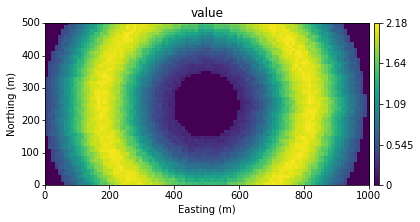

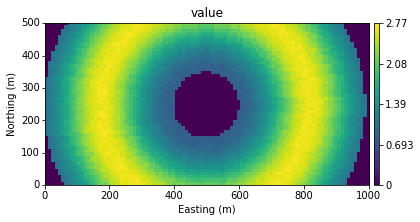

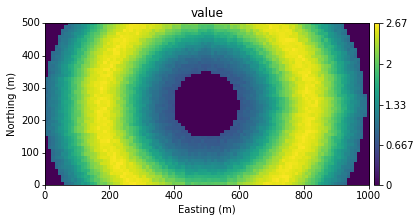

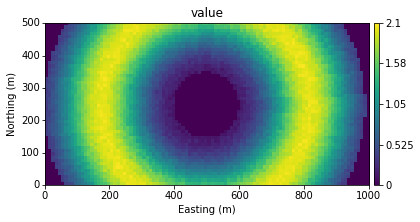

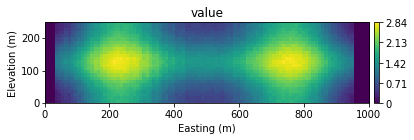

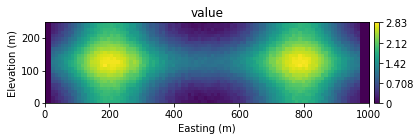

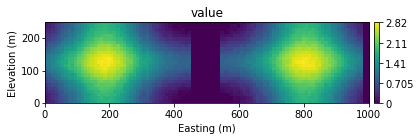

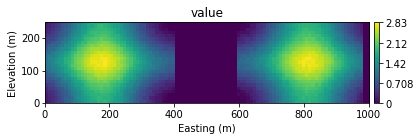

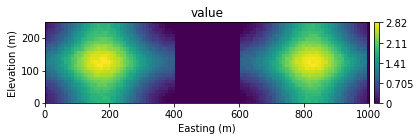

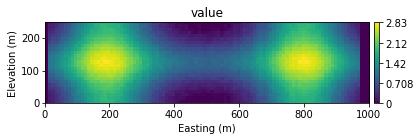

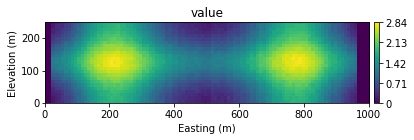

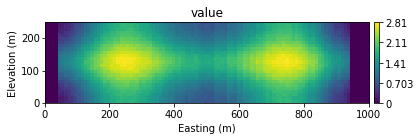

In [10]:
gs.pixelplt(sgsimfl,var='value',sliceno= 5)
gs.pixelplt(sgsimfl,var='value',sliceno= 10)
gs.pixelplt(sgsimfl,var='value',sliceno= 15)
gs.pixelplt(sgsimfl,var='value',sliceno= 20)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 5)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 10)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 15)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 20)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 25)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 35)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 40)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 45)

In [ ]:
# gs.write_gslib(sgsimfl,'dataflpd.out')
# sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
# print(sgsimfl.data.describe())

In [8]:
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
print(sgsimfl.data.describe())

                   X              Y              Z          value
count  125000.000000  125000.000000  125000.000000  125000.000000
mean      500.000000     250.000000     125.000000       1.263312
std       288.661855     144.309274      72.111314       0.790646
min         5.000000       5.000000       5.000000       0.000000
25%       252.500000     125.000000      65.000000       0.637438
50%       500.000000     250.000000     125.000000       1.310630
75%       747.500000     375.000000     185.000000       1.872845
max       995.000000     495.000000     245.000000       2.850073


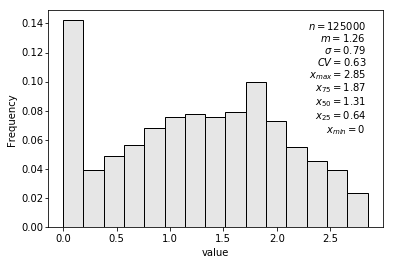

In [9]:
gs.histplt(sgsimfl.data['value'])

In [11]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}            - File with first grid
1  {varcol1}                        - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
80  80                       -  If 0, spacing in X, Y
300  45                     -  If 0, collar of the first sample, X and Y (inside sampling grid)
80  69069                    -  If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                            - Sample spacing downhole
1                          - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
300   995                       - Sampling grid: xmin, xmax
5   495                       -                ymin, ymax
5   245                       -                zmin, zmax
dhs.out        - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            -  If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out         - Keyout file
'''
gsample= gs.Program(program='gsample',parfile='gsample.par')
gsample.run(parstr=gsamplepar.format(datafl=sgsimfl.flname,
                                       varcol1=sgsimfl.gscol('value'),
                                         griddef=griddef
                                      ))

Calling:  ['gsample', 'gsample.par']

GSAMPLE Version: 1.000

PARAMETER FILE                  = gsample.par                                                                                                                                                                                                                                                     
-----------------------------------------------------------------------------

INPUT PARAMETERS 

Number of grids to sample       =   1
Total number of variables       =   1
 
Data file  1                    = 
dataflpd.out
Variable columns                =   4
 
Sample realization number       =   1
 
Input grid 
Input grid in X                 =  100        5.00   10.00
Input grid in Y                 =   50        5.00   10.00
Input grid in Z                 =   25        5.00   10.00
 
Sample option                   =   0
 
Consider regular spacing 

 
Spacing in X                    =    80.0    
Spacing in Y                    =    

In [21]:
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
print(dataflpoints.data.head())
dataflpoints.describe()

   Drill ID      X     Y      Z    MD  Block ID   value
0       1.0  300.0  45.0  245.0   0.0  120431.0  1.5383
1       1.0  300.0  45.0  235.0  10.0  115431.0  1.6245
2       1.0  300.0  45.0  225.0  20.0  110431.0  1.5862
3       1.0  300.0  45.0  215.0  30.0  105431.0  1.6991
4       1.0  300.0  45.0  205.0  40.0  100431.0  1.7097


Drill ID           MD       Block ID        value
count  1296.000000  1296.000000    1296.000000  1296.000000
mean     27.500000   115.000000   64963.000000     1.191663
std      15.591801    69.248587   34651.265979     0.751615
min       1.000000     0.000000    5431.000000     0.000000
25%      14.000000    57.500000   35197.000000     0.619725
50%      27.500000   115.000000   64963.000000     1.179900
75%      41.000000   172.500000   94729.000000     1.783075
max      54.000000   230.000000  124495.000000     2.780100

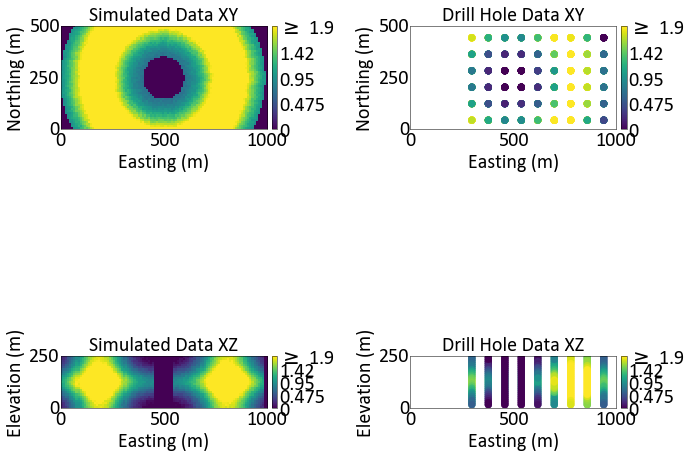

In [22]:
dataflpoints = dataflpoints[dataflpoints.data['Z'] != 0.1]
vlim = (0,1.9)
gs.set_style('pt20')
f, axes = plt.subplots(2, 2, figsize=(10, 10))
gs.locmap(dataflpoints,var = 'value',orient='xy', ax = axes[0,1],sliceno= 15,title = ('Drill Hole Data XY'),vlim=vlim)
gs.locmap(dataflpoints,var = 'value',orient='xz', ax = axes[1,1],sliceno= 15,title = ('Drill Hole Data XZ'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',sliceno= 15, ax = axes[0,0],title = ('Simulated Data XY'),vlim=vlim)
gs.pixelplt(sgsimfl,var='value',orient='xz',sliceno= 15, ax = axes[1,0],title = ('Simulated Data XZ'),vlim=vlim)
plt.tight_layout()
plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Donut_Data_{}.png'.format(plt_extent),vlim=vlim)


In [23]:
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [24]:
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()

X            Y            Z        value
count  1296.000000  1296.000000  1296.000000  1296.000000
mean    620.000000   245.000000   130.000000     1.191663
std     206.638855   136.678757    69.248589     0.751615
min     300.000000    45.000000    15.000000     0.000000
25%     460.000000   125.000000    72.500000     0.619725
50%     620.000000   245.000000   130.000000     1.179900
75%     780.000000   365.000000   187.500000     1.783075
max     940.000000   445.000000   245.000000     2.780100

In [25]:
gs.write_gslib(datasamplefl, 'datasamplefl.out')

In [26]:
datatest = np.asarray(datasamplefl)

In [27]:
tf.InteractiveSession.close(sess)
sess.close()

In [28]:
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

0.0
2.7801
1
Working on Node 10 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpl8yw_zjy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002169265A6A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling 

Epoch: 1100/5000 err = 0.00848151370882988
Cost_test : 0.0094140405
R^2:0.8894883394241333
Epoch: 1200/5000 err = 0.00772460550069809
Cost_test : 0.008946474
R^2:0.8900291323661804
Epoch: 1300/5000 err = 0.0077200522646307945
Cost_test : 0.008525126
R^2:0.8999163508415222
Epoch: 1400/5000 err = 0.007289836648851633
Cost_test : 0.008132533
R^2:0.9016173481941223
Epoch: 1500/5000 err = 0.006695560645312071
Cost_test : 0.007792924
R^2:0.910103440284729
Epoch: 1600/5000 err = 0.0068107969127595425
Cost_test : 0.007492688
R^2:0.9113774299621582
Epoch: 1700/5000 err = 0.0060481601394712925
Cost_test : 0.0071852272
R^2:0.9215795993804932
Epoch: 1800/5000 err = 0.005936264526098967
Cost_test : 0.0069024093
R^2:0.9194343090057373
Epoch: 1900/5000 err = 0.005402416456490755
Cost_test : 0.006628104
R^2:0.9280056357383728
Epoch: 2000/5000 err = 0.005680773872882128
Cost_test : 0.0064312667
R^2:0.9248696565628052
Epoch: 2100/5000 err = 0.0058560483157634735
Cost_test : 0.006168926
R^2:0.92067736387

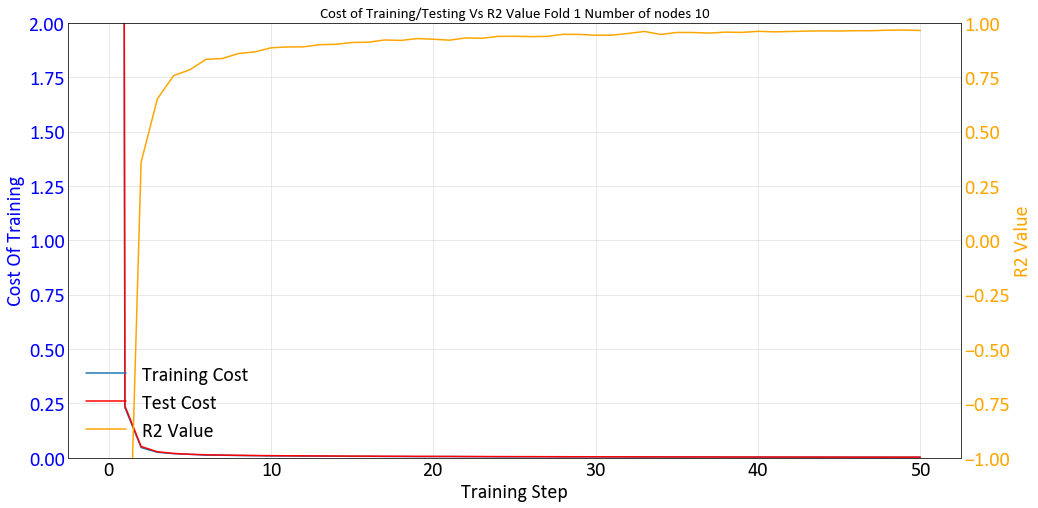

Working on Node 15 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp4jomm9ef', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002168359CCC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1200/5000 err = 0.009835540316998959
Cost_test : 0.01124279
R^2:0.8652983903884888
Epoch: 1300/5000 err = 0.008078270591795444
Cost_test : 0.010085837
R^2:0.8931085467338562
Epoch: 1400/5000 err = 0.007815137505531311
Cost_test : 0.0091364905
R^2:0.8961065411567688
Epoch: 1500/5000 err = 0.008044572547078133
Cost_test : 0.008365376
R^2:0.8948336839675903
Epoch: 1600/5000 err = 0.007241359446197748
Cost_test : 0.007743398
R^2:0.8976309299468994
Epoch: 1700/5000 err = 0.0060351830907166
Cost_test : 0.0072228294
R^2:0.9212278127670288
Epoch: 1800/5000 err = 0.005642622709274292
Cost_test : 0.0067683957
R^2:0.9267668128013611
Epoch: 1900/5000 err = 0.005521416664123535
Cost_test : 0.0063681356
R^2:0.9285831451416016
Epoch: 2000/5000 err = 0.005556461401283741
Cost_test : 0.0060386388
R^2:0.9184861779212952
Epoch: 2100/5000 err = 0.005702657625079155
Cost_test : 0.005746259
R^2:0.9209319353103638
Epoch: 2200/5000 err = 0.005042185541242361
Cost_test : 0.0054599405
R^2:0.9313752651214

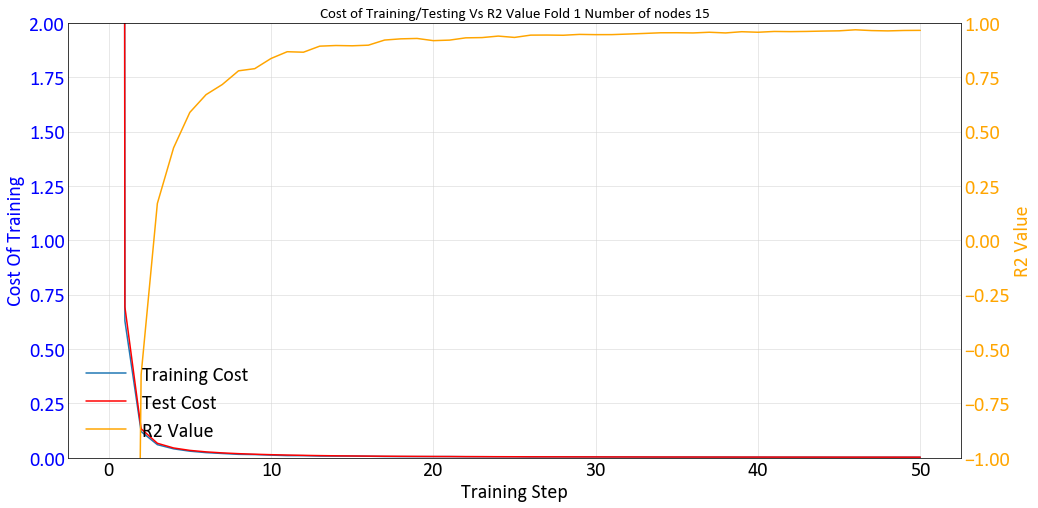

Working on Node 25 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpx8e7oz0f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002169039DFD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.008084968663752079
Cost_test : 0.008676663
R^2:0.8857735991477966
Epoch: 1200/5000 err = 0.008125603199005127
Cost_test : 0.007744914
R^2:0.8824167847633362
Epoch: 1300/5000 err = 0.006191972177475691
Cost_test : 0.0069507775
R^2:0.9120766520500183
Epoch: 1400/5000 err = 0.005630733445286751
Cost_test : 0.006269674
R^2:0.9252952933311462
Epoch: 1500/5000 err = 0.005014548543840647
Cost_test : 0.0057080947
R^2:0.9387401938438416
Epoch: 1600/5000 err = 0.004957244731485844
Cost_test : 0.0053175436
R^2:0.9243318438529968
Epoch: 1700/5000 err = 0.004304669797420502
Cost_test : 0.005002573
R^2:0.9421639442443848
Epoch: 1800/5000 err = 0.004057201091200113
Cost_test : 0.004707214
R^2:0.944229245185852
Epoch: 1900/5000 err = 0.003907449077814817
Cost_test : 0.0044829305
R^2:0.9474835991859436
Epoch: 2000/5000 err = 0.0041513750329613686
Cost_test : 0.004278864
R^2:0.9434481263160706
Epoch: 2100/5000 err = 0.0035366942174732685
Cost_test : 0.0040869163
R^2:0.9501024484

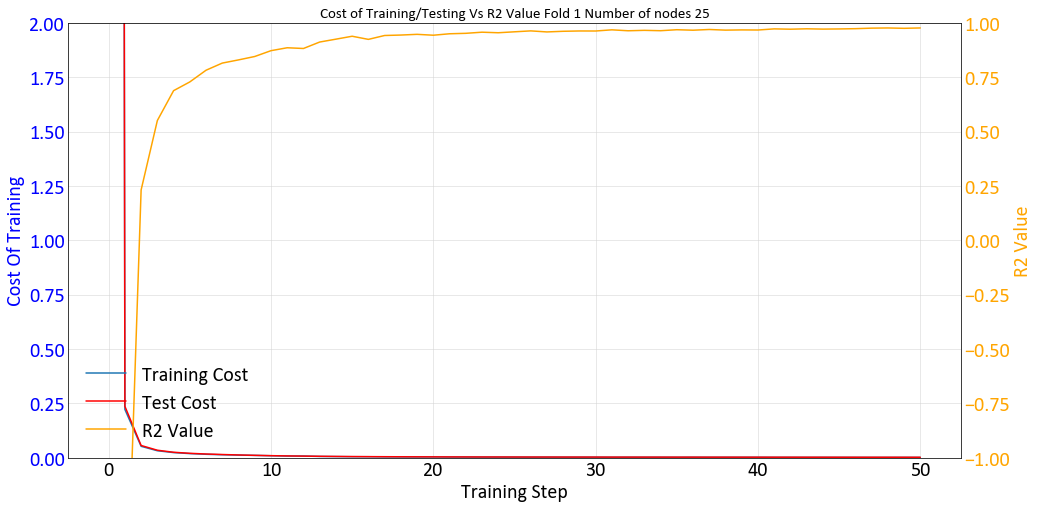

Working on Node 30 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpjc2yms15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021683567A58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.006239498499780893
Cost_test : 0.0063367416
R^2:0.9101920127868652
Epoch: 1200/5000 err = 0.005404097028076649
Cost_test : 0.005876032
R^2:0.9237023591995239
Epoch: 1300/5000 err = 0.005155152641236782
Cost_test : 0.0054893824
R^2:0.930907666683197
Epoch: 1400/5000 err = 0.004970188718289137
Cost_test : 0.005110843
R^2:0.9334877729415894
Epoch: 1500/5000 err = 0.004244762938469648
Cost_test : 0.0048456704
R^2:0.9403088688850403
Epoch: 1600/5000 err = 0.004256987012922764
Cost_test : 0.0045828167
R^2:0.9424287676811218
Epoch: 1700/5000 err = 0.004262757487595081
Cost_test : 0.0043270667
R^2:0.9401668906211853
Epoch: 1800/5000 err = 0.003735870122909546
Cost_test : 0.0041212584
R^2:0.9484534859657288
Epoch: 1900/5000 err = 0.0037702086847275496
Cost_test : 0.0039339564
R^2:0.9469117522239685
Epoch: 2000/5000 err = 0.0032127678859978914
Cost_test : 0.0037671633
R^2:0.9571533203125
Epoch: 2100/5000 err = 0.003184190485626459
Cost_test : 0.0036055394
R^2:0.957397639

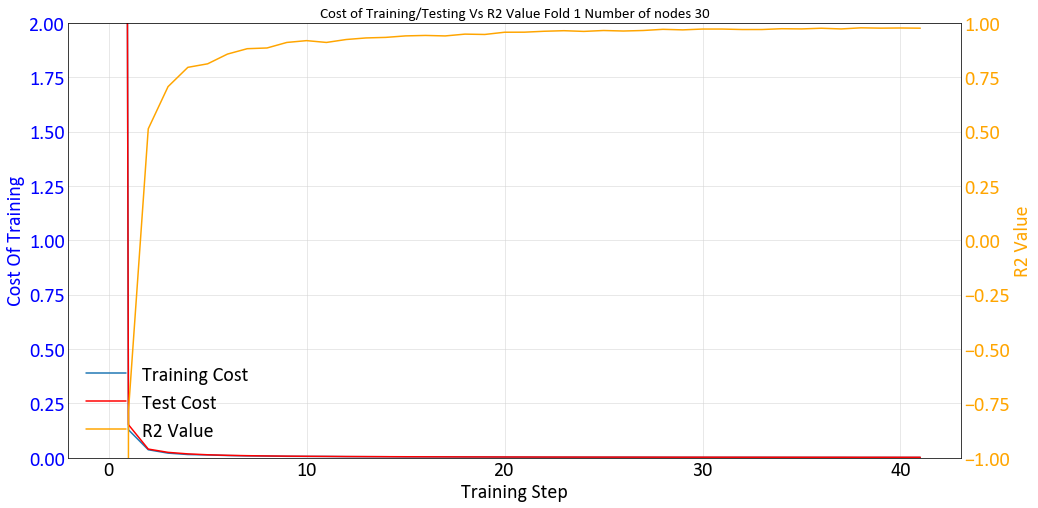

2
Working on Node 10 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpy33atudx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021671D5E320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.010095975361764431
Cost_test : 0.01005925
R^2:0.8647319674491882
Epoch: 1200/5000 err = 0.009573999792337418
Cost_test : 0.009327929
R^2:0.8709486126899719
Epoch: 1300/5000 err = 0.008511578664183617
Cost_test : 0.008726025
R^2:0.8894269466400146
Epoch: 1400/5000 err = 0.00843771081417799
Cost_test : 0.008198545
R^2:0.8885743618011475
Epoch: 1500/5000 err = 0.00783591903746128
Cost_test : 0.0077669444
R^2:0.8886192440986633
Epoch: 1600/5000 err = 0.007575970143079758
Cost_test : 0.0073762536
R^2:0.8973622918128967
Epoch: 1700/5000 err = 0.007392046507447958
Cost_test : 0.0070370375
R^2:0.898051917552948
Epoch: 1800/5000 err = 0.006085524335503578
Cost_test : 0.0067134066
R^2:0.9133152365684509
Epoch: 1900/5000 err = 0.005925525911152363
Cost_test : 0.0064205853
R^2:0.9188829064369202
Epoch: 2000/5000 err = 0.005858664400875568
Cost_test : 0.006187507
R^2:0.921751856803894
Epoch: 2100/5000 err = 0.0056038498878479
Cost_test : 0.005955698
R^2:0.9236695766448975
E

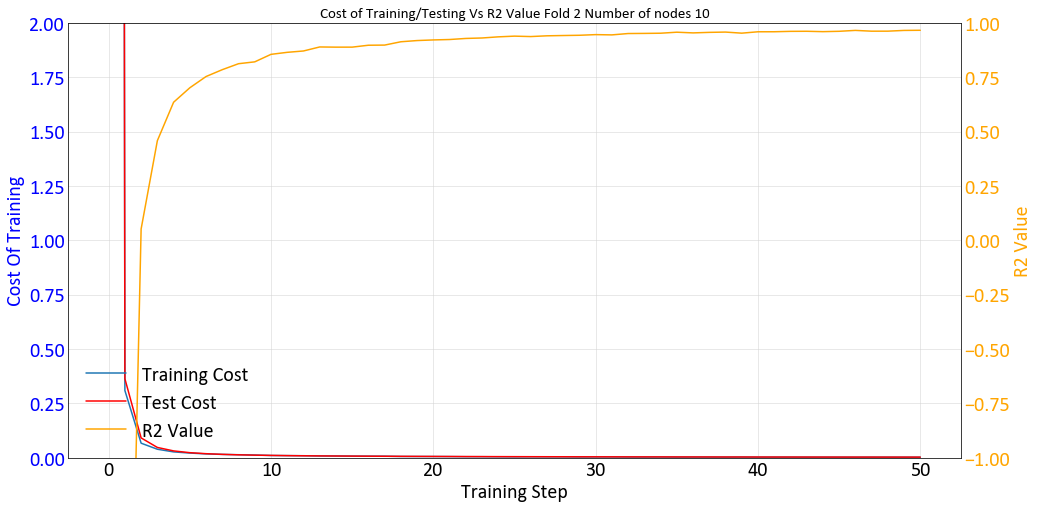

Working on Node 15 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp3th6k8be', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002169615CB00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.006684530060738325
Cost_test : 0.008304664
R^2:0.912955105304718
Epoch: 1200/5000 err = 0.005996700841933489
Cost_test : 0.007908286
R^2:0.9209955930709839
Epoch: 1300/5000 err = 0.005843076389282942
Cost_test : 0.007503694
R^2:0.9149872064590454
Epoch: 1400/5000 err = 0.005701533053070307
Cost_test : 0.0072338814
R^2:0.9235289692878723
Epoch: 1500/5000 err = 0.005211939103901386
Cost_test : 0.0069180042
R^2:0.931631326675415
Epoch: 1600/5000 err = 0.004833856597542763
Cost_test : 0.0066352766
R^2:0.9311931133270264
Epoch: 1700/5000 err = 0.004730860237032175
Cost_test : 0.0062910267
R^2:0.9331735372543335
Epoch: 1800/5000 err = 0.004355348646640778
Cost_test : 0.006084691
R^2:0.9389635920524597
Epoch: 1900/5000 err = 0.004159248434007168
Cost_test : 0.0057999324
R^2:0.9458974599838257
Epoch: 2000/5000 err = 0.004230013117194176
Cost_test : 0.005535676
R^2:0.9435089826583862
Epoch: 2100/5000 err = 0.004016310442239046
Cost_test : 0.0053004776
R^2:0.946290373802

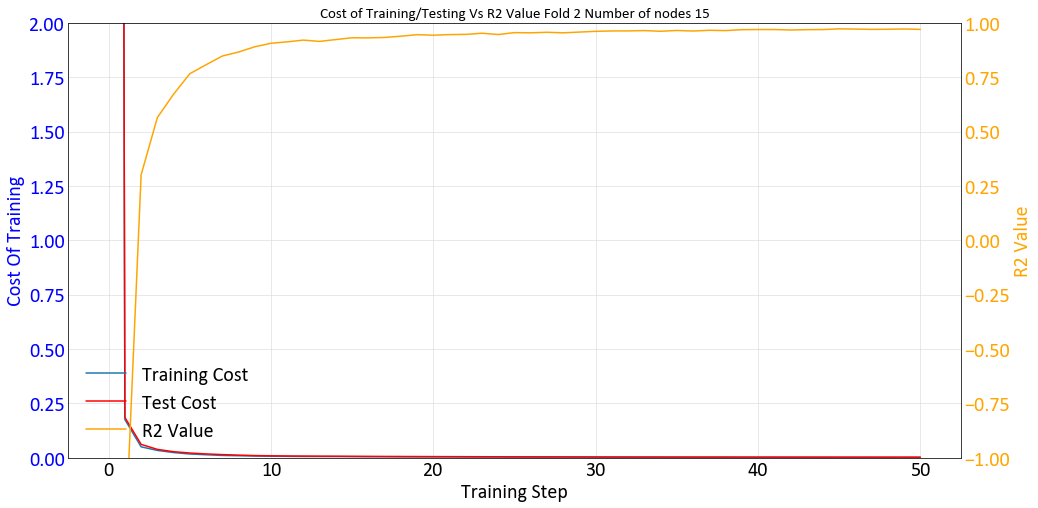

Working on Node 25 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpl82yg_2j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002168E105F28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.010926531627774239
Cost_test : 0.012802472
R^2:0.8496970534324646
Epoch: 1200/5000 err = 0.009206697344779968
Cost_test : 0.011631338
R^2:0.8761542439460754
Epoch: 1300/5000 err = 0.008639262057840824
Cost_test : 0.010665454
R^2:0.8848088979721069
Epoch: 1400/5000 err = 0.008107256144285202
Cost_test : 0.009853906
R^2:0.8840222358703613
Epoch: 1500/5000 err = 0.007679720409214497
Cost_test : 0.00913328
R^2:0.8965557217597961
Epoch: 1600/5000 err = 0.0073919533751904964
Cost_test : 0.008506695
R^2:0.898054838180542
Epoch: 1700/5000 err = 0.0067293220199644566
Cost_test : 0.007985479
R^2:0.8999985456466675
Epoch: 1800/5000 err = 0.0060410043224692345
Cost_test : 0.0074963192
R^2:0.9189789295196533
Epoch: 1900/5000 err = 0.0055106403306126595
Cost_test : 0.0070835967
R^2:0.92525315284729
Epoch: 2000/5000 err = 0.0050846002995967865
Cost_test : 0.006703298
R^2:0.9275171756744385
Epoch: 2100/5000 err = 0.0055251517333090305
Cost_test : 0.0063763657
R^2:0.92521125078

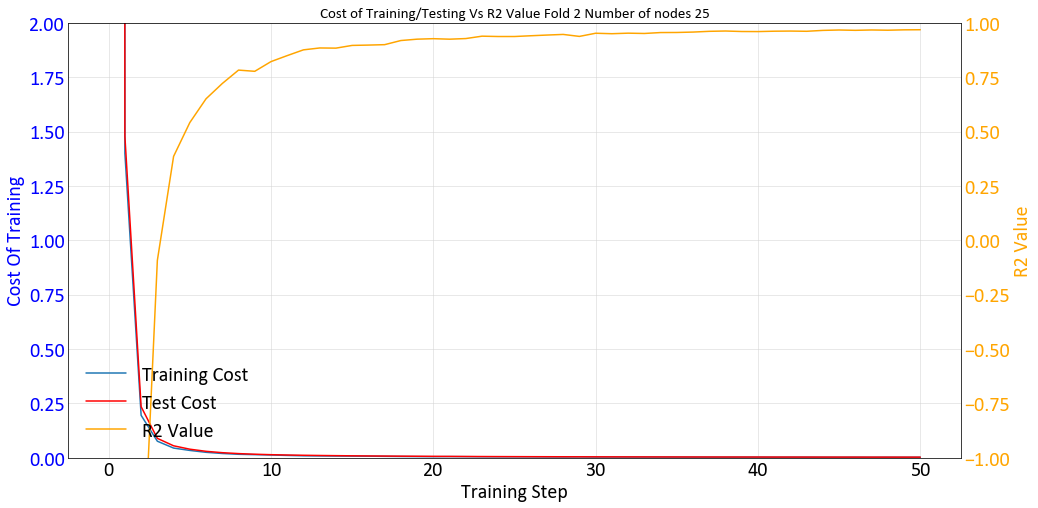

Working on Node 30 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpfxuyx4ll', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002168F7E2F60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.008592834696173668
Cost_test : 0.008581822
R^2:0.8827321529388428
Epoch: 1200/5000 err = 0.006669271737337112
Cost_test : 0.007840161
R^2:0.9105405211448669
Epoch: 1300/5000 err = 0.0060143377631902695
Cost_test : 0.0072445087
R^2:0.9164037704467773
Epoch: 1400/5000 err = 0.006139233708381653
Cost_test : 0.00669984
R^2:0.9176410436630249
Epoch: 1500/5000 err = 0.005220362450927496
Cost_test : 0.0062417304
R^2:0.9278000593185425
Epoch: 1600/5000 err = 0.005344786215573549
Cost_test : 0.005789687
R^2:0.9276904463768005
Epoch: 1700/5000 err = 0.004983670078217983
Cost_test : 0.0054684943
R^2:0.9291974306106567
Epoch: 1800/5000 err = 0.004636264871805906
Cost_test : 0.005194671
R^2:0.9332116842269897
Epoch: 1900/5000 err = 0.0042775957845151424
Cost_test : 0.0049110167
R^2:0.939501941204071
Epoch: 2000/5000 err = 0.003918306902050972
Cost_test : 0.0046936157
R^2:0.9449640512466431
Epoch: 2100/5000 err = 0.004017775412648916
Cost_test : 0.0044667814
R^2:0.9454072713

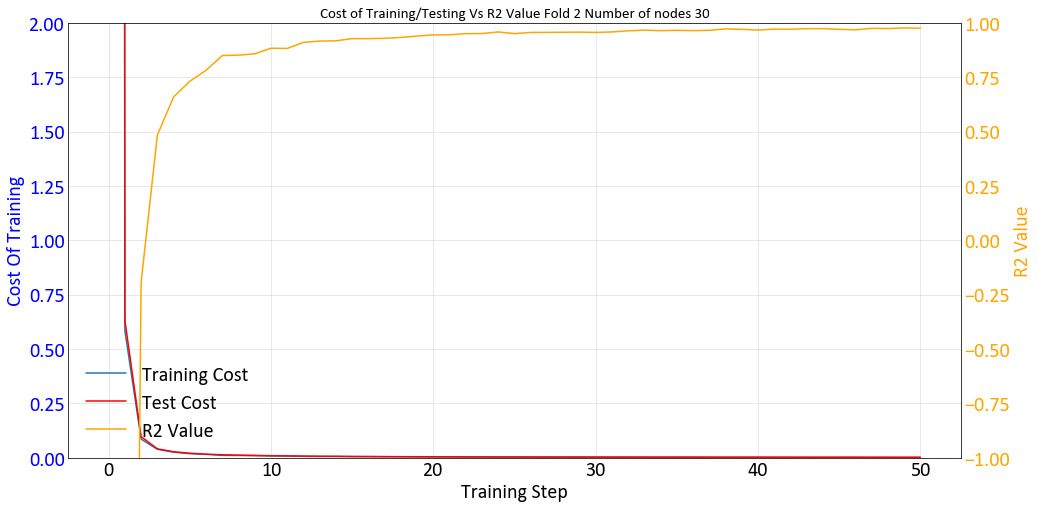

3
Working on Node 10 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpcpm0138i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000216902354A8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.0093015655875206
Cost_test : 0.009475317
R^2:0.8734814524650574
Epoch: 1200/5000 err = 0.008419061079621315
Cost_test : 0.008947518
R^2:0.8798798322677612
Epoch: 1300/5000 err = 0.008276808075606823
Cost_test : 0.008454485
R^2:0.8840160369873047
Epoch: 1400/5000 err = 0.007351704407483339
Cost_test : 0.008073798
R^2:0.8951575756072998
Epoch: 1500/5000 err = 0.00748133659362793
Cost_test : 0.0077167396
R^2:0.8943117260932922
Epoch: 1600/5000 err = 0.007391486316919327
Cost_test : 0.007417621
R^2:0.9027605652809143
Epoch: 1700/5000 err = 0.006643698550760746
Cost_test : 0.007151752
R^2:0.9060004949569702
Epoch: 1800/5000 err = 0.006749688647687435
Cost_test : 0.006901241
R^2:0.904301643371582
Epoch: 1900/5000 err = 0.006409178022295237
Cost_test : 0.006633751
R^2:0.9098291993141174
Epoch: 2000/5000 err = 0.005607595667243004
Cost_test : 0.006428869
R^2:0.9201403856277466
Epoch: 2100/5000 err = 0.005399704910814762
Cost_test : 0.0062260204
R^2:0.9224839210510254
E

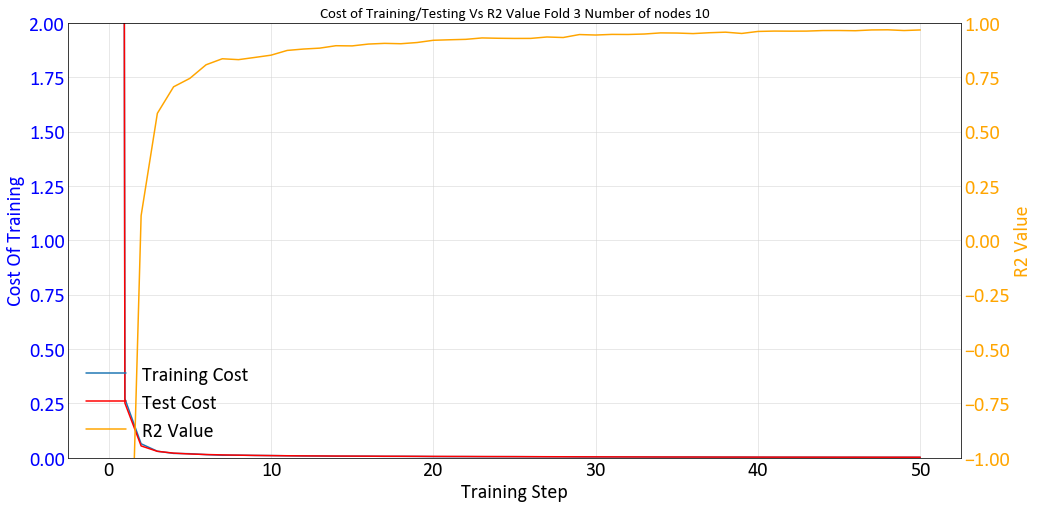

Working on Node 15 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp4aa8zsw4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021683005A58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.006681536789983511
Cost_test : 0.0076144855
R^2:0.905600905418396
Epoch: 1200/5000 err = 0.0065273866057395935
Cost_test : 0.0070484607
R^2:0.9089320302009583
Epoch: 1300/5000 err = 0.006267957855015993
Cost_test : 0.006577111
R^2:0.9096671342849731
Epoch: 1400/5000 err = 0.005877464544028044
Cost_test : 0.0061465832
R^2:0.9173638224601746
Epoch: 1500/5000 err = 0.005732463672757149
Cost_test : 0.0057915905
R^2:0.9245089292526245
Epoch: 1600/5000 err = 0.005107314325869083
Cost_test : 0.0054826844
R^2:0.92502760887146
Epoch: 1700/5000 err = 0.005092932842671871
Cost_test : 0.0052492963
R^2:0.9299380779266357
Epoch: 1800/5000 err = 0.004935394041240215
Cost_test : 0.004999377
R^2:0.9303130507469177
Epoch: 1900/5000 err = 0.004594427067786455
Cost_test : 0.004759467
R^2:0.9369207620620728
Epoch: 2000/5000 err = 0.004094179254025221
Cost_test : 0.004575297
R^2:0.9408078193664551
Epoch: 2100/5000 err = 0.004024587105959654
Cost_test : 0.0043992405
R^2:0.94380342960

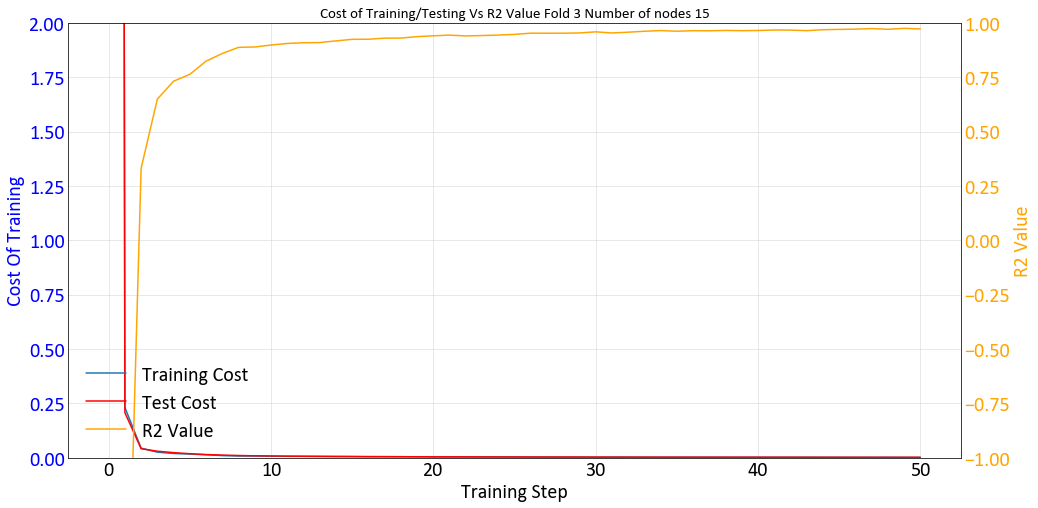

Working on Node 25 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpyqa9cbkb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002168D321C18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

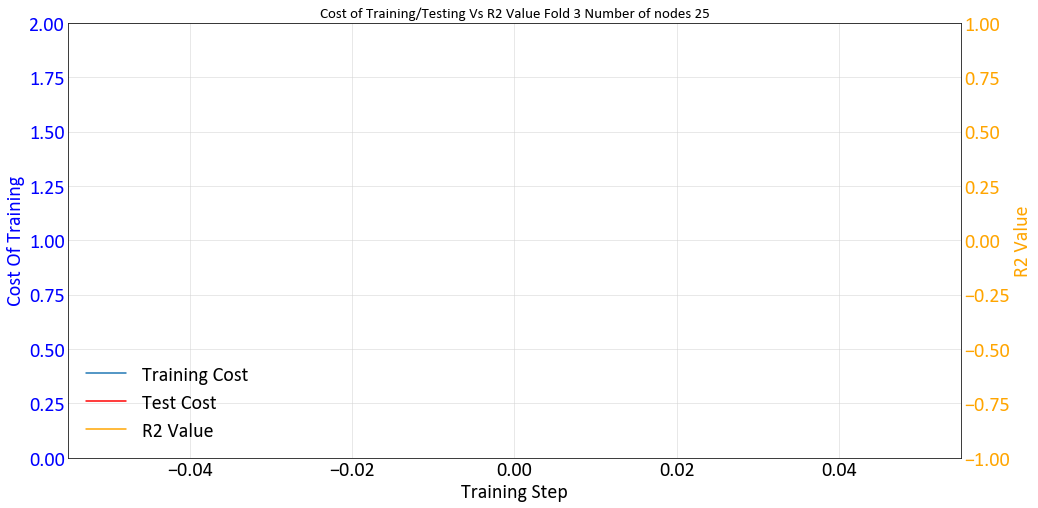

Working on Node 30 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpt84ksl2e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002169631BBA8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.00823965948075056
Cost_test : 0.00818791
R^2:0.8833367228507996
Epoch: 1200/5000 err = 0.008329040370881557
Cost_test : 0.0076131136
R^2:0.8838030695915222
Epoch: 1300/5000 err = 0.007273257244378328
Cost_test : 0.0071926764
R^2:0.9029181599617004
Epoch: 1400/5000 err = 0.005621600896120071
Cost_test : 0.006751584
R^2:0.9206880331039429
Epoch: 1500/5000 err = 0.006021780893206596
Cost_test : 0.006359907
R^2:0.9161533713340759
Epoch: 1600/5000 err = 0.004807262681424618
Cost_test : 0.006063999
R^2:0.934071958065033
Epoch: 1700/5000 err = 0.004863865673542023
Cost_test : 0.0057364576
R^2:0.9302312135696411
Epoch: 1800/5000 err = 0.005068697966635227
Cost_test : 0.0055333227
R^2:0.9289207458496094
Epoch: 1900/5000 err = 0.004418433178216219
Cost_test : 0.0051514516
R^2:0.938420295715332
Epoch: 2000/5000 err = 0.0039000436663627625
Cost_test : 0.00493293
R^2:0.9433026909828186
Epoch: 2100/5000 err = 0.004012447316199541
Cost_test : 0.0046719834
R^2:0.94529736042022

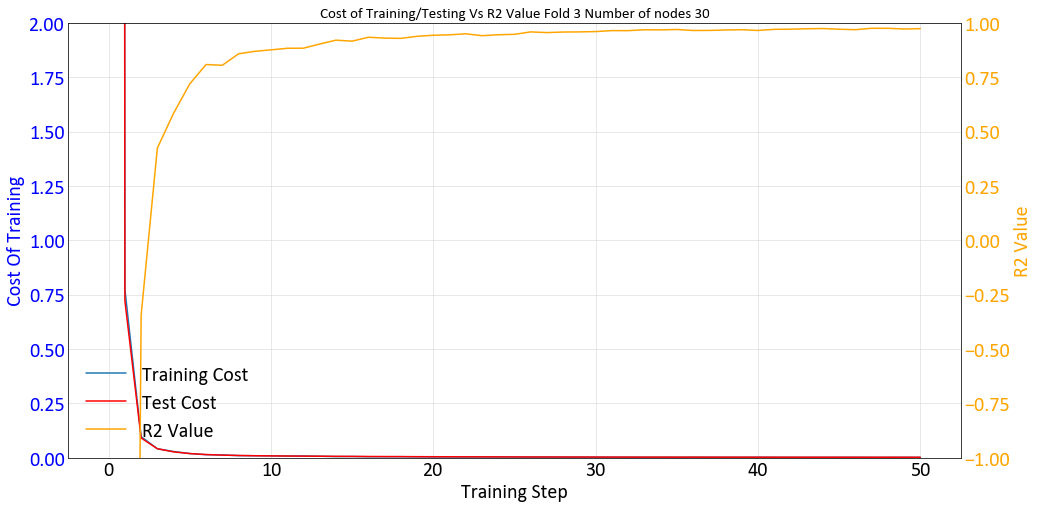

4
Working on Node 10 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpaa6pe65x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021683732E48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.008824490010738373
Cost_test : 0.009217684
R^2:0.8779540061950684
Epoch: 1200/5000 err = 0.00855910312384367
Cost_test : 0.008772198
R^2:0.8855929374694824
Epoch: 1300/5000 err = 0.007989520207047462
Cost_test : 0.008369196
R^2:0.8904626965522766
Epoch: 1400/5000 err = 0.00776769919320941
Cost_test : 0.007976339
R^2:0.8924036622047424
Epoch: 1500/5000 err = 0.007081771269440651
Cost_test : 0.007619977
R^2:0.8951588869094849
Epoch: 1600/5000 err = 0.007204812951385975
Cost_test : 0.007280704
R^2:0.8970125913619995
Epoch: 1700/5000 err = 0.00688772089779377
Cost_test : 0.006953833
R^2:0.9005997180938721
Epoch: 1800/5000 err = 0.006226939614862204
Cost_test : 0.0066559175
R^2:0.9098829030990601
Epoch: 1900/5000 err = 0.006251527927815914
Cost_test : 0.0063718758
R^2:0.9138002991676331
Epoch: 2000/5000 err = 0.0056307436898350716
Cost_test : 0.006083209
R^2:0.9259449243545532
Epoch: 2100/5000 err = 0.005591996945440769
Cost_test : 0.005815765
R^2:0.9198435544967651

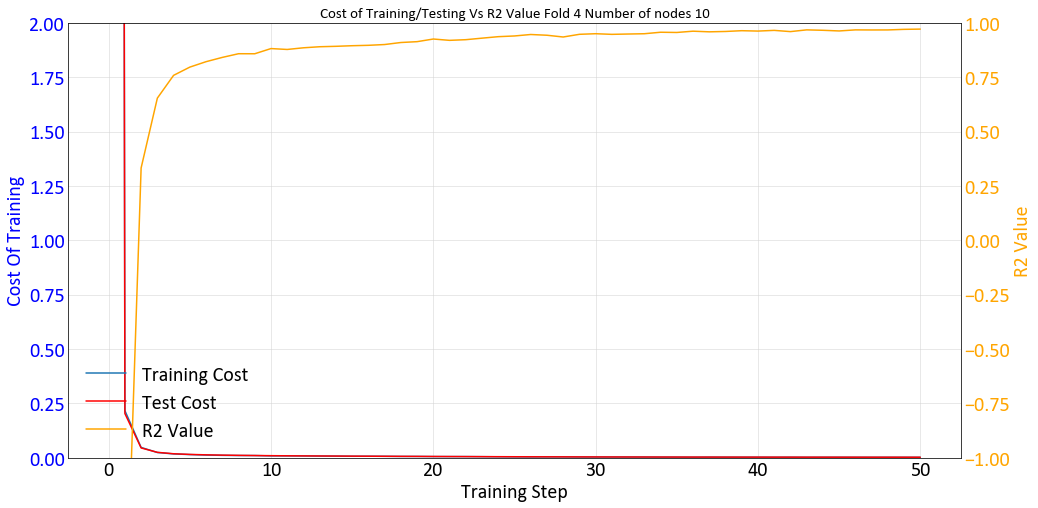

Working on Node 15 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp89a_zejp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002168D7BCF28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.006545108277350664
Cost_test : 0.007433812
R^2:0.9062249064445496
Epoch: 1200/5000 err = 0.006589462049305439
Cost_test : 0.006923379
R^2:0.9135107398033142
Epoch: 1300/5000 err = 0.0059032863937318325
Cost_test : 0.0064680977
R^2:0.9206290245056152
Epoch: 1400/5000 err = 0.0055792927742004395
Cost_test : 0.006112781
R^2:0.9246209859848022
Epoch: 1500/5000 err = 0.005050478968769312
Cost_test : 0.0058207326
R^2:0.9315976500511169
Epoch: 1600/5000 err = 0.00523021025583148
Cost_test : 0.005555375
R^2:0.9292265176773071
Epoch: 1700/5000 err = 0.0041865017265081406
Cost_test : 0.005298911
R^2:0.9430248737335205
Epoch: 1800/5000 err = 0.004373841919004917
Cost_test : 0.0051043634
R^2:0.9424645900726318
Epoch: 1900/5000 err = 0.004565658513456583
Cost_test : 0.0048964145
R^2:0.9377973675727844
Epoch: 2000/5000 err = 0.004107300192117691
Cost_test : 0.00471042
R^2:0.9407303929328918
Epoch: 2100/5000 err = 0.004039015620946884
Cost_test : 0.0045632417
R^2:0.9448830485

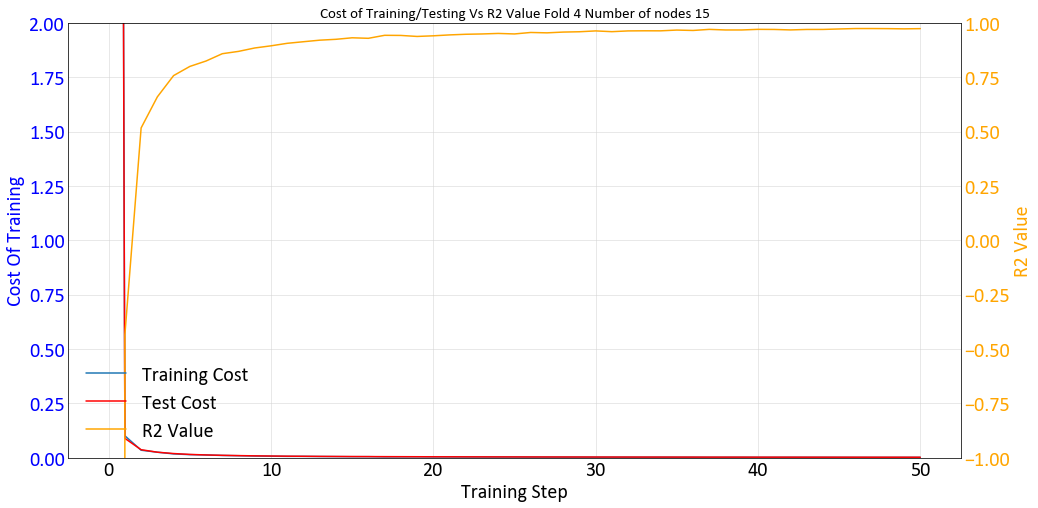

Working on Node 25 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmphck7t9yt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021671C51320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.010609466582536697
Cost_test : 0.0118251
R^2:0.8567090630531311
Epoch: 1200/5000 err = 0.009577859193086624
Cost_test : 0.011006089
R^2:0.8714510798454285
Epoch: 1300/5000 err = 0.00933979731053114
Cost_test : 0.010232423
R^2:0.8672089576721191
Epoch: 1400/5000 err = 0.00886890385299921
Cost_test : 0.009578206
R^2:0.8744686245918274
Epoch: 1500/5000 err = 0.007995049469172955
Cost_test : 0.00899483
R^2:0.8934283256530762
Epoch: 1600/5000 err = 0.007489578332751989
Cost_test : 0.008397649
R^2:0.8931646347045898
Epoch: 1700/5000 err = 0.00651421258226037
Cost_test : 0.007917223
R^2:0.9131625294685364
Epoch: 1800/5000 err = 0.006855471059679985
Cost_test : 0.007431411
R^2:0.8997292518615723
Epoch: 1900/5000 err = 0.005942690186202526
Cost_test : 0.007066825
R^2:0.9200250506401062
Epoch: 2000/5000 err = 0.005886132828891277
Cost_test : 0.00670149
R^2:0.9133486151695251
Epoch: 2100/5000 err = 0.005706094205379486
Cost_test : 0.00640049
R^2:0.9240016937255859
Epoch: 

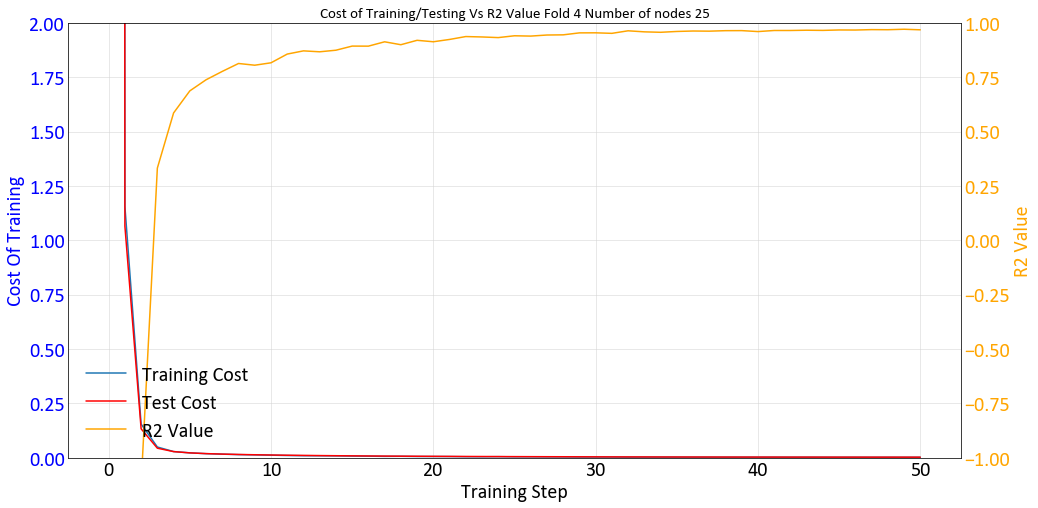

Working on Node 30 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp46lo4y8b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021676CD5358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

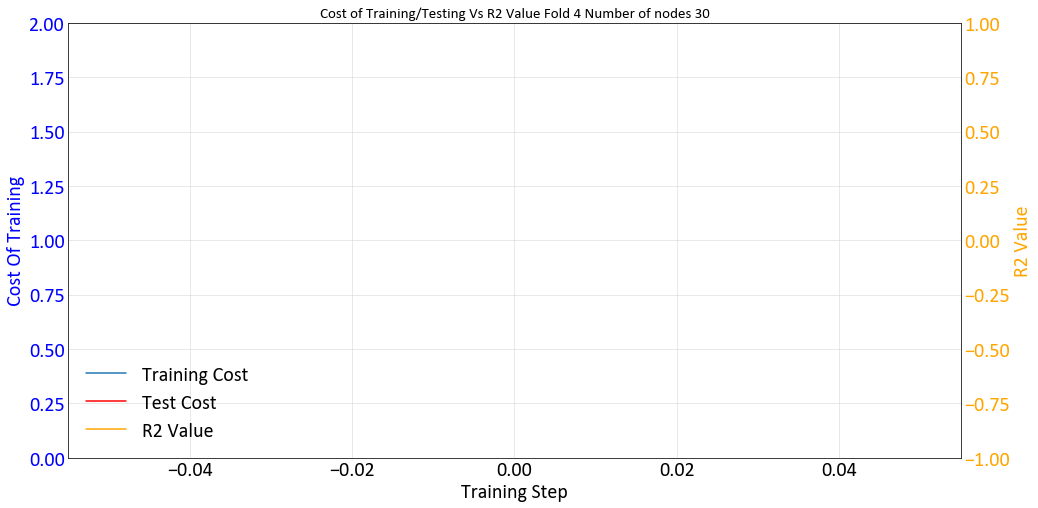

5
Working on Node 10 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpgyz5tikl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021690134A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.009134840220212936
Cost_test : 0.009873608
R^2:0.8840387463569641
Epoch: 1200/5000 err = 0.008544491603970528
Cost_test : 0.009269474
R^2:0.891862690448761
Epoch: 1300/5000 err = 0.008675438351929188
Cost_test : 0.008784589
R^2:0.8856578469276428
Epoch: 1400/5000 err = 0.007154651917517185
Cost_test : 0.008398105
R^2:0.9077883958816528
Epoch: 1500/5000 err = 0.007145381532609463
Cost_test : 0.007973899
R^2:0.9026545286178589
Epoch: 1600/5000 err = 0.006841521710157394
Cost_test : 0.0076747737
R^2:0.9072860479354858
Epoch: 1700/5000 err = 0.006200070027261972
Cost_test : 0.007324578
R^2:0.9146188497543335
Epoch: 1800/5000 err = 0.00600616866722703
Cost_test : 0.00705803
R^2:0.9213851094245911
Epoch: 1900/5000 err = 0.006162902805954218
Cost_test : 0.0067510135
R^2:0.9163457751274109
Epoch: 2000/5000 err = 0.005471012555062771
Cost_test : 0.0064806454
R^2:0.9300706386566162
Epoch: 2100/5000 err = 0.0052364603616297245
Cost_test : 0.0062340284
R^2:0.92813742160797

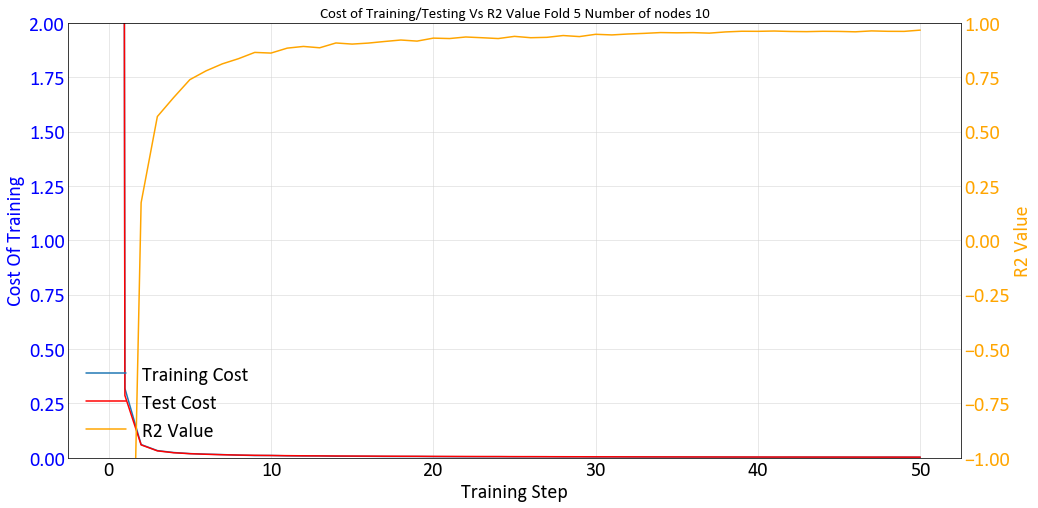

Working on Node 15 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmps_0e5c8f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021683051A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.00625206995755434
Cost_test : 0.007948962
R^2:0.9175623059272766
Epoch: 1200/5000 err = 0.005701845046132803
Cost_test : 0.0075330967
R^2:0.9237840175628662
Epoch: 1300/5000 err = 0.005462127737700939
Cost_test : 0.00719496
R^2:0.9258173108100891
Epoch: 1400/5000 err = 0.0054560257121920586
Cost_test : 0.0068782605
R^2:0.9264431595802307
Epoch: 1500/5000 err = 0.0047746747732162476
Cost_test : 0.006600201
R^2:0.9370007514953613
Epoch: 1600/5000 err = 0.004411720670759678
Cost_test : 0.006374093
R^2:0.9396869540214539
Epoch: 1700/5000 err = 0.004246230702847242
Cost_test : 0.0061657894
R^2:0.9409407377243042
Epoch: 1800/5000 err = 0.004023011773824692
Cost_test : 0.005911127
R^2:0.945801317691803
Epoch: 1900/5000 err = 0.0037625206168740988
Cost_test : 0.0056964573
R^2:0.9475414156913757
Epoch: 2000/5000 err = 0.0033577270805835724
Cost_test : 0.005476807
R^2:0.9520387053489685
Epoch: 2100/5000 err = 0.0033565396443009377
Cost_test : 0.0053004124
R^2:0.953959822

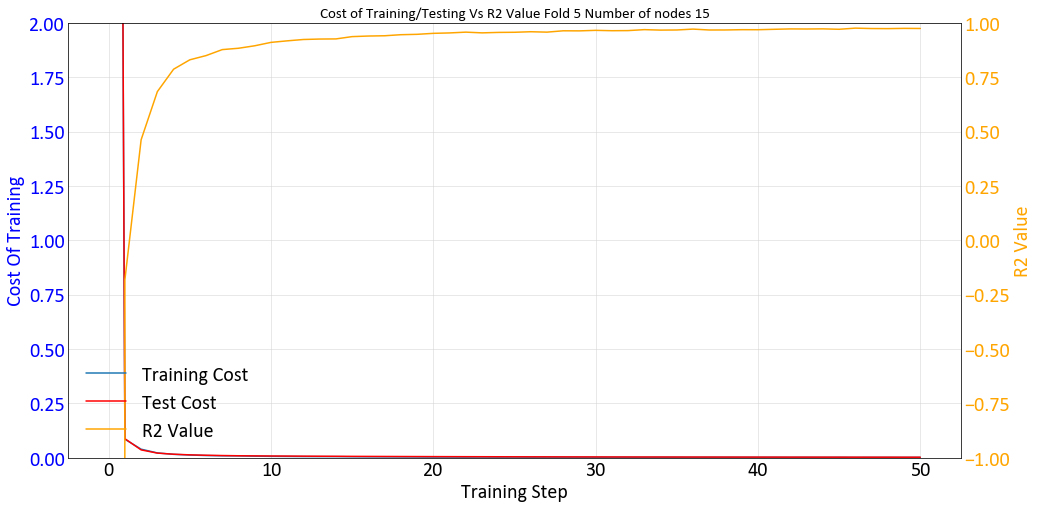

Working on Node 25 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpbtwia557', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021692F32550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.01098898146301508
Cost_test : 0.013479908
R^2:0.8527960777282715
Epoch: 1200/5000 err = 0.010812139138579369
Cost_test : 0.012571439
R^2:0.8518098592758179
Epoch: 1300/5000 err = 0.01012636348605156
Cost_test : 0.011806525
R^2:0.8661307096481323
Epoch: 1400/5000 err = 0.008736024610698223
Cost_test : 0.01115135
R^2:0.8750852346420288
Epoch: 1500/5000 err = 0.009455281309783459
Cost_test : 0.010572898
R^2:0.8736967444419861
Epoch: 1600/5000 err = 0.006962157785892487
Cost_test : 0.010016174
R^2:0.901238203048706
Epoch: 1700/5000 err = 0.007156329695135355
Cost_test : 0.009563853
R^2:0.9036034345626831
Epoch: 1800/5000 err = 0.006595462094992399
Cost_test : 0.009104205
R^2:0.9123678803443909
Epoch: 1900/5000 err = 0.006307295057922602
Cost_test : 0.008720772
R^2:0.915774941444397
Epoch: 2000/5000 err = 0.006202314980328083
Cost_test : 0.008376589
R^2:0.9148891568183899
Epoch: 2100/5000 err = 0.005856637842953205
Cost_test : 0.008032057
R^2:0.9197618961334229
Epoc

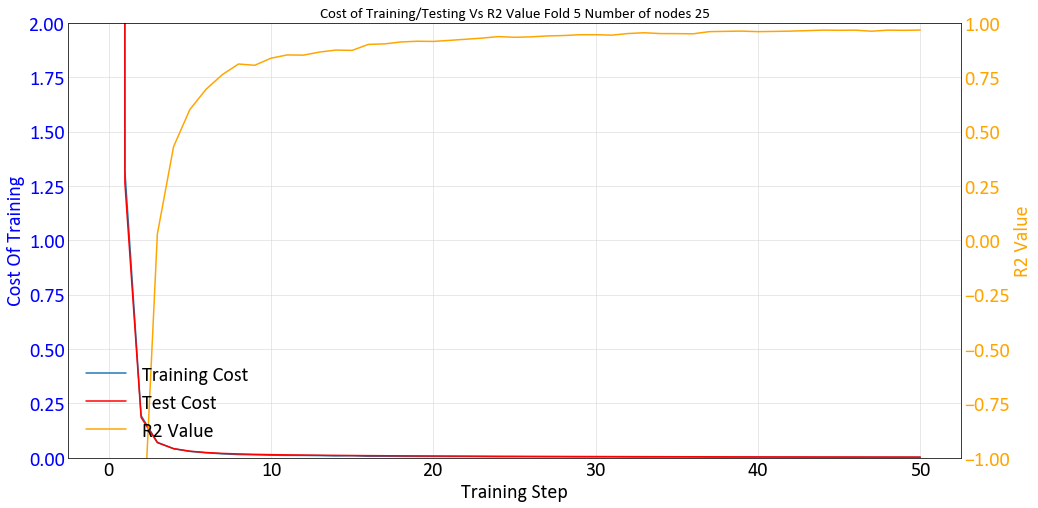

Working on Node 30 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpwysctg4r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000216925FDBE0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.008649739436805248
Cost_test : 0.008785762
R^2:0.8840858340263367
Epoch: 1200/5000 err = 0.00737294927239418
Cost_test : 0.007947639
R^2:0.9005796313285828
Epoch: 1300/5000 err = 0.007374617736786604
Cost_test : 0.0072381385
R^2:0.8977652192115784
Epoch: 1400/5000 err = 0.006556680426001549
Cost_test : 0.0066876505
R^2:0.9123355746269226
Epoch: 1500/5000 err = 0.006121888756752014
Cost_test : 0.0061975475
R^2:0.9130425453186035
Epoch: 1600/5000 err = 0.006205209996551275
Cost_test : 0.005801324
R^2:0.914790689945221
Epoch: 1700/5000 err = 0.004995744675397873
Cost_test : 0.005471509
R^2:0.931962251663208
Epoch: 1800/5000 err = 0.00490840757265687
Cost_test : 0.0051569752
R^2:0.9303292036056519
Epoch: 1900/5000 err = 0.004395284224301577
Cost_test : 0.0049013817
R^2:0.9387035965919495
Epoch: 2000/5000 err = 0.005062797572463751
Cost_test : 0.004710338
R^2:0.9309712052345276
Epoch: 2100/5000 err = 0.004140772856771946
Cost_test : 0.0045275693
R^2:0.94438272714614

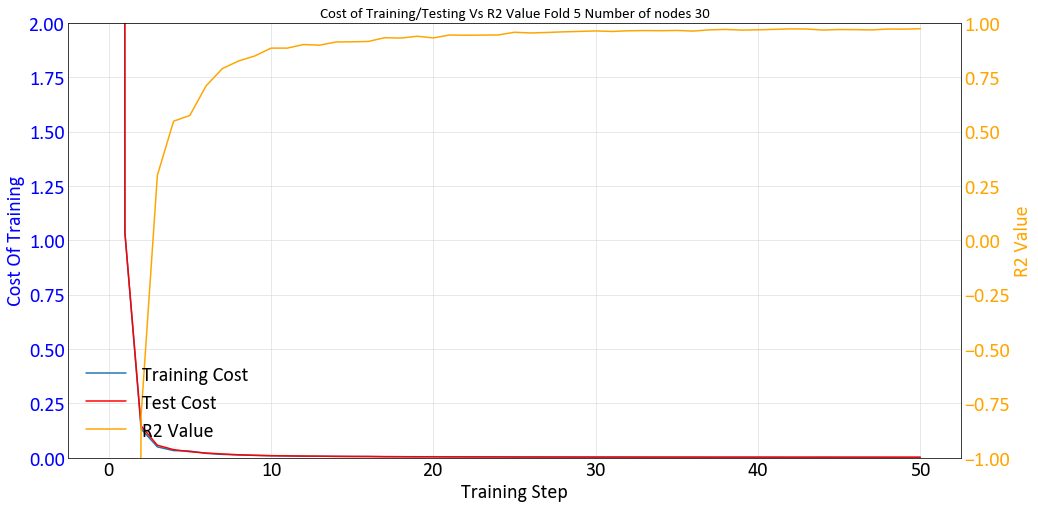

In [29]:
from sklearn.model_selection import KFold
#Prediction Grid
x,y,z = griddef.gridcoord()
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])
print(min_val)
print(max_val)
datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)
data_x = np.hstack((x.reshape(len(x),1),y.reshape(len(y),1),z.reshape(len(z),1)))/100
kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(datatest)
fold_num= 0
columns = ['X','Y','Z','value']
n_batch = 1
RFB_type = 'Gaussian'
for train_index, test_index in kf.split(datatest):
    fold_num += 1
    print(fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    data_train, data_test = datatest[train_index,0:3]/100, datatest[test_index,0:3]/100
    target_train, target_test = datatest[train_index,3:4], datatest[test_index,3:4]
    gs.write_gslib(pd.DataFrame(np.hstack((data_train*100,target_train*(max_val-min_val)+min_val)),columns=columns), './data/data_train_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(np.hstack((data_test*100,target_test*(max_val-min_val)+min_val)),columns=columns), './data/data_test_{}.dat'.format(fold_num))
    row = 0
    NN = 'ERBFN' # RBFN or GRNN or 'EBFN'
    data_type = 'Continuous' # Continuous or Categorical
    test_nodes = [10,15,25,30]
    pred_all = np.zeros((len(test_nodes)*data_x.shape[0],target_train.shape[1]))
    pred_all_row = np.zeros((data_x.shape[0],target_train.shape[1],len(test_nodes)))
    info_matrix = np.zeros((len(test_nodes),8))
    for nodes in test_nodes:
        c_t = []
        c_test = []
        c_r2 = []
        start_time = time.time()
        print("Working on Node {} fold {} ".format(nodes,fold_num))
        k = nodes
        data_trainpd = pd.DataFrame(data_train)
        data = data_trainpd

        with tf.device('/device:CPU:0'):
            #clustering
            def input_fn():
              return tf.train.limit_epochs(
                  tf.convert_to_tensor(data_train, dtype=tf.float32), num_epochs=1)

            kmeans = tf.contrib.factorization.KMeansClustering(
                num_clusters=nodes, use_mini_batch=False)


            # train
            num_iterations = 10
            previous_centers = None
            for _ in range(num_iterations):
              kmeans.train(input_fn)
              cluster_centers = kmeans.cluster_centers()
              #if previous_centers is not None:
                #print('delta:', cluster_centers - previous_centers)
              previous_centers = cluster_centers
              #print('score:', kmeans.score(input_fn))
            #print('cluster centers:', cluster_centers)
            
            
        with tf.device('/device:GPU:0'):
            from tensorflow.python.framework import ops
            ops.reset_default_graph()


            RANDOM_SEED = 42
            tf.set_random_seed(RANDOM_SEED)

            N_INSTANCES = np.shape(data_train)[0]
            N_INPUT = data_train.shape[0]
            N_FEATURE = data_train.shape[1]
            N_CLASSES = target_train.shape[1]
            TRAIN_SIZE = int(N_INSTANCES)
            batch_size = int(np.shape(data_train)[0]/n_batch)
            training_epochs = 5000
            if nodes >= 2:
                training_epochs = 5000
            if nodes >= 25:
                training_epochs = 5000
            if nodes >= 100:
                training_epochs = 5000
            if nodes >= 1000:
                training_epochs = 5000
            learning_rate = 0.01
            epsilon = 0.001
            display_step = 100
            hidden_size = nodes

            target_ = np.zeros((N_INSTANCES, N_CLASSES))
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            x_data = tf.placeholder(shape=[None, N_FEATURE], dtype=tf.float32, name = 'Features')
            y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32, name = 'Known_Values')


            dist = np.zeros((k,k))
            for i in range (0,k):
                for j in range (0,k):
                    dist[i:j] = distance.euclidean(cluster_centers[i], cluster_centers[j])
                    maxdist = dist.max()
            sigma = maxdist/np.sqrt(2*k)
            if nodes == 1 :
                beta = 0.2
            else:        
                beta = 1/math.pow(2*sigma,2)

            #EBFN
            if NN == 'ERBFN':
                def rbf_network(input_layer, cluster_centers ,weights):

                    exp_list= []
                    with tf.name_scope('Cluster_Centers'):
                        yy = weights['cluster_centers']

                    with tf.name_scope('Input_Layer'):
                        input_layer

                    for i in range(nodes):
                        with tf.name_scope('Covariance_Matrix'):
                            vv = weights['cov_mat'][:,:,i]
                            symA = 0.5 * tf.math.add(vv , tf.transpose(vv))

                        with tf.name_scope('Mahalanobis_Distance'):
                            cc_i = yy[i]

                            diff = tf.subtract(input_layer, cc_i , name = 'subtract')

                            dt = tf.transpose(diff,name = 'Transpose')

                            M1 = tf.matmul(diff,symA,name = 'M1')

                            M2 = tf.matmul(M1,dt,name = 'M2')

                            sqrt = tf.math.sqrt(tf.math.abs(M2),name = 'sqrt')

                            diag = tf.linalg.tensor_diag_part(sqrt,name = 'diag') 

                        with tf.name_scope('Gaussian_Activation_Layer'):
                            gauss_f = tf.math.exp((-tf.math.pow((weights['beta'][:,i]*diag), 2)))
                            exp_list.append(gauss_f)

                    with tf.name_scope('Output_Layer'):        
                        layer2_act = tf.stack(exp_list)   
                        output = tf.add(tf.matmul(layer2_act, weights['output'],transpose_a=True,name = 'mult_layer2_by_weights'), bias['output'], 
                                    name = 'add_bias_to_output')     
                    return output


            weights = {
                'h1': tf.Variable(tf.ones([N_FEATURE, N_FEATURE,nodes]), name = 'layer1_dims'),
                'output': tf.Variable(tf.ones([nodes, N_CLASSES]), name = 'layer2_output_Weights'),
                'cov_mat': tf.Variable(tf.ones(shape = [N_FEATURE,N_FEATURE,nodes]), name = 'cov'),
                'beta' : tf.Variable(tf.constant(beta,shape = [1,nodes]) ,name = 'beta'),            
                'cluster_centers' : tf.Variable(tf.constant(np.asarray(cluster_centers).reshape(nodes,N_FEATURE),
                                    shape = [nodes,N_FEATURE]), name = 'cluster_center')
            }

            bias = {
                'output' : tf.Variable([0],name='output_bias',dtype=tf.float32)  
            }


            pred = rbf_network(x_data, cluster_centers ,weights)

            if data_type == 'Continuous':
                with tf.name_scope('cost'):
                    cost = tf.reduce_mean(tf.square(pred - y_target))
                    #cost = tf.math.reduce_sum(tf.square(pred - y_target)) 
                    my_opt = tf.train.AdamOptimizer(learning_rate,beta1=0.5).minimize(cost)  
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    total_error = tf.reduce_sum(tf.square(tf.subtract(y_target, tf.reduce_mean(y_target))))
                    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_target, pred)))
                    accuracy = tf.subtract(1.00, tf.divide(unexplained_error, total_error))

            if data_type == 'Categorical':
                with tf.name_scope('cost'):
                    if N_CLASSES == 1:
                        cost = tf.reduce_mean(tf.square(tf.round(pred) - y_target)) 
                    else:
                        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = pred))
                    my_opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    correct_prediction = tf.equal(tf.round(pred), y_target)
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#             tf.summary.histogram("cov_mat", weights['cov_mat'])
#             tf.summary.histogram("Weights_Output_Layer", weights['output'])
#             tf.summary.histogram("Bias_Output_Layer", bias['output'])




            init = tf.global_variables_initializer()
            sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
            merged = tf.summary.merge_all()
            saver = tf.train.Saver()
            writer = tf.summary.FileWriter('./test',sess.graph)
            sess.run(init)
            tol = 0.00001
            epoch, err, acc=0, 1, 0
            # Training loop
            #saver.restore(sess,'./spatial/test_dataset_{}.ckpt'.format(nodes))
            while epoch <= training_epochs and err >= tol and acc <= 0.98:

                avg_cost = 0.
                acc = 0.
                total_batch = int(data_train.shape[0] / batch_size)
                for i in range(total_batch):
                    randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
                    batch_xs = data_train[randidx , :]
                    batch_ys = target_train[randidx , :]
                    sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
                    avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                    acc += sess.run(accuracy, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                err = avg_cost
                if epoch % 100 == 0:
                    #summary = sess.run([merged],feed_dict={x_data: batch_xs, y_target: batch_ys})
                    #writer.add_summary(summary,epoch)
                    print("Epoch: {}/{} err = {}".format(epoch, training_epochs, avg_cost))
                    print('Cost_test :',sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_t.append(avg_cost)
                    c_test.append(sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_r2.append(acc)
                    if data_type == 'Categorical': 
                        print("Accuracy:{}".format(acc))
                    else:
                        print("R^2:{}".format(acc))    

                epoch +=1

            print ("End of learning process")
            print ("Final epoch = {}/{} ".format(epoch, training_epochs))
            print ("Final error = {}".format(err) )
            print ("Final R^2 = {}".format(acc) )
            saver.save(sess,'./spatial/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            w = np.vsplit(data_x,500)[0].shape[0]
            pred1 = np.zeros((data_x.shape[0],N_CLASSES))
            for i in range(0,500):
                pred1[i*w:(1+i)*w,0:N_CLASSES] = (sess.run(pred, feed_dict={x_data:np.vsplit(data_x,500)[i]}))*(max_val-min_val)+min_val
                pred_all[i*w+(row*data_x.shape[0]):(1+i)*w+(row*data_x.shape[0]),0:N_CLASSES] = pred1[i*w:(1+i)*w,0:N_CLASSES]
                pred_all_row[i*w:(1+i)*w,0:N_CLASSES,row] = pred1[i*w:(1+i)*w,0:N_CLASSES]

            writer = tf.summary.FileWriter("sess_graph", sess.graph)
            saver.save(sess,'test/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            sess.close() 

            gs.write_gslib(pd.DataFrame(pred1), './predictions/real_{}_{}.dat'.format(nodes,fold_num))

            info_matrix[row,0] = k
            info_matrix[row,1] = beta
            info_matrix[row,2] = 0 #r2_score(sgsimfl['value'],pred1)
            info_matrix[row,3] = np.mean(pred1)
            info_matrix[row,4] = np.var(pred1)
            info_matrix[row,5] = 0 #mean_squared_error(sgsimfl['value'],pred1)
            info_matrix[row,6] = err
            info_matrix[row,7] = (time.time() - start_time) 
            row +=1
            tf.InteractiveSession.close(sess)
        print(info_matrix)
        SMALL_SIZE = 15
        plt.rc('font', size=SMALL_SIZE)
        plt.rc('axes', titlesize=SMALL_SIZE)
        f, (ax1) = plt.subplots(1, 1,figsize=(16, 8))
        ax1.set_ylim([0,2])
        ax1.plot(range(len(c_t)), c_t, label ='Training Cost')
        ax1.plot(range(len(c_t)), c_test, color="red",label ='Test Cost')
        ax1.set_xlabel('Training Step')
        ax1.grid(True)
        ax1.set_title('Cost of Training/Testing Vs R2 Value Fold {} Number of nodes {}'.format(fold_num,nodes))
        ax1.set_ylabel('Cost Of Training', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.plot(range(len(c_t)), c_r2,'-',color="orange",label ='R2 Value')
        ax2.set_ylim([-1,1])
        ax2.set_ylabel('R2 Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=3)
        plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Training_R2_ERBFN_{}_{}_{}.png'.format(nodes,fold_num,plt_extent))
        plt.show()


    ensemble = numpy.nanmean(pred_all_row, axis = 2)
    gs.write_gslib(pd.DataFrame(ensemble), './predictions/ensemble_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(pred_all), './predictions/all_real_{}.dat'.format(fold_num))

In [64]:
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
2                                 -number of directions
0 90 200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  80  40                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill



NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
2                            -number of directions to model points along
    0.0  00.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0:0.99    0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        175     175     225    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
25    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
800.0  800.0  800.0              -maximum search radii
0.0  0.0   0.0                 -angles for search ellipsoid
0                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.62 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""

In [65]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
for fold in range(1,6):
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))

    

    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold))

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_1.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   80.0000000000000     
   40.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   10.0000000000000     
   5.00000000000000     
  output file: ./vargs/varcalc_1.out
  legacy output?      

 Final objective value =   2.631504499212516E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.4.7

  data file = ./data/data_train_2.dat                 
  columns =            0           1           2           3           4
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_2.out               
  nx, xmn, xsiz =          100   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

 Working on the kriging 
   currently on estimate     10000
   currently on estimate     20000
   currently on estimate     30000
   currently on estimate     40000
   currently on estimate     50000
   currently on estimate     60000
   currently on estimate     70000
   currently on estimate     80000
   currently on estimate     90000
   currently on estimate    100000
   currently on estimate    110000
   currently on estimate    120000

 KT3DN Version:    7.4.7 Finished

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_4.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.0000000000

 Final objective value =   2.715249386315698E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.4.7

  data file = ./data/data_train_5.dat                 
  columns =            0           1           2           3           4
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./predictions/kt3dn_5.out               
  nx, xmn, xsiz =          100   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

In [13]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
100 5.0 10.0 
50 5.0 10.0 
25 5.0 10.0

In [18]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21          -  trimming limits
./declus/declus_{fold}.sum                  -file for summary output
./declus/declus_{fold}.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
99  10.0  110.0               -number of cell sizes, min size, max size
100                           -number of origin offsets
"""


varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
2                                 -number of directions
0  90   200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  10  5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
2                            -number of directions to model points along
    0.0  00.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0:0.99    0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        175     175     225    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
0                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}              -file with data
0  {xyzcol}  {varcol}  {seisnscol}                 -  columns for DH,X,Y,Z,var,sec var
-99    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./ML+OICCK/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
10    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
500  500  500              -maximum search radii
 0   0.0   0.0                 -angles for search ellipsoid
7                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0  {corr}  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
{seisfl}                     -gridded file with drift/mean
{seiscol}                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""

In [19]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
declus = gs.Program('declus')   

griddef2 = gs.GridDef(gridfl='griddef2.txt')

for fold in range(1,6):
    
    sesi_data = gs.DataFile('predictions\ensemble_{}.dat'.format(fold))
    
    sesi_data = gaussian_filter((sesi_data.data['0']),sigma = 0)
    
    gs.write_gslib(pd.DataFrame(sesi_data),'predictions\smooth_ensemble_{}.dat'.format(fold))
    
    sesi_data = gs.DataFile('predictions\smooth_ensemble_{}.dat'.format(fold))
    
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))
    
    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('value'),
                         fold = fold))
    
    Testdat = gs.DataFile('declus/declus_{}.out'.format(fold),griddef=griddef)
    
    idx,ingrid = griddef.coord_to_index1d(x=Testdat.data['X'],y=Testdat.data['Y'],z=Testdat.data['Z'])
    
    Testdat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Testdat,'./data/data_test_NS_{}.dat'.format(fold))
    
    Testdat = gs.DataFile('./data/data_test_NS_{}.dat'.format(fold))   
    
    
    
    idx,ingrid = griddef.coord_to_index1d(x=Traindat.data['X'],y=Traindat.data['Y'],z=Traindat.data['Z']) 
    
    Traindat['sesi_data'] = sesi_data.data['0'][idx].values
    
    gs.write_gslib(Traindat,'./data/data_train_NS_{}.dat'.format(fold))
    
    Traindat = gs.DataFile('./data/data_train_NS_{}.dat'.format(fold))
    

    
#     Traindat = gs.DataFile('declus.out',griddef=griddef)  
        
#     for i in range(len(Traindat['value'])):
#         if Traindat['sesi_data'].isna()[i] == True:
#             Traindat['sesi_data'][i] = Traindat['value'][i]
            
    gs.write_gslib(Traindat,'./nscore/runfl_{}.out'.format(fold))      

    Traindat = gs.DataFile('nscore/runfl_{}.out'.format(fold),griddef=griddef)
    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))


    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open('./vargs/varmodel_{}.var'.format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    declus_mean = np.min(np.asarray(gs.DataFile('./declus/declus_{}.sum'.format(fold)).data['Declustered Mean'][gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                                 seisfl = sesi_data.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             seiscol = sesi_data.gscol('0'),
                             griddef = griddef2,
                             varg = varg,
                             mean = declus_mean,
                             seisnscol = Traindat.gscol('sesi_data'),
                             corr = np.corrcoef(Traindat.data.dropna()['value'],Traindat.data.dropna()['sesi_data'])[0,1],
                             fold = fold))
    
    
    kt3dnfl = gs.DataFile('./ML+ICCK/kt3dn_{}.out'.format(fold))
    
    kt3dnfl.data['Back Transform'] = kt3dnfl.data['Estimate']
    
    gs.write_gslib(kt3dnfl,'./backtr/backtr_UDDH_{}.out'.format(fold))
    

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_1.dat                 
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = ./declus/declus_1.sum                   
 output file = ./declus/declus_1.out                   
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =           99       10.000000      110.000000
 offsets =          100


There are     1036 data with:
  mean value            =      1.19386
  minimum and maximum   =      0.00000     2.78010
  size of data vol in X =    639.99994
  size of data vol in Y =    399.99997
  size of data vol in Z =    230.00000

  declustered mean      =      1.11288
  min and max weight    =      0.53257     4.11938
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.
Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: nscore/runfl_1

 Final objective value =   2.438125302030037E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.4.7

  data file = nscore/runfl_2.out                      
  columns =            0           1           2           3           4
           5
  trimming limits =   -99.0000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./ML+OICCK/kt3dn_2.out                  
  nx, xmn, xsiz =           50   5.01000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

   currently on estimate      6250
   currently on estimate     12500
   currently on estimate     18750
   currently on estimate     25000
   currently on estimate     31250
   currently on estimate     37500
   currently on estimate     43750
   currently on estimate     50000
   currently on estimate     56250
   currently on estimate     62500

 KT3DN Version:    7.4.7 Finished

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = ./data/data_train_4.dat                 
 columns =            1           2           3           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = ./declus/declus_4.sum                   
 output file = ./declus/declus_4.out                   
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =           99       10.000000      110.000000
 offsets =          100


There are     1037 data with:
  mean value            =      1.17715
  minimum and maximum   =      0.00000     2.78010
  siz

 Final objective value =   2.497975103234816E-003
  Modeling points

varmodel completed successfully

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.4.7

  data file = nscore/runfl_5.out                      
  columns =            0           1           2           3           4
           5
  trimming limits =   -99.0000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = ./ML+OICCK/kt3dn_5.out                  
  nx, xmn, xsiz =           50   5.01000000000000        10.0000000000000     
  ny, ymn, ysiz =           50   5.00000000000000        10.0000000000000     
  nz

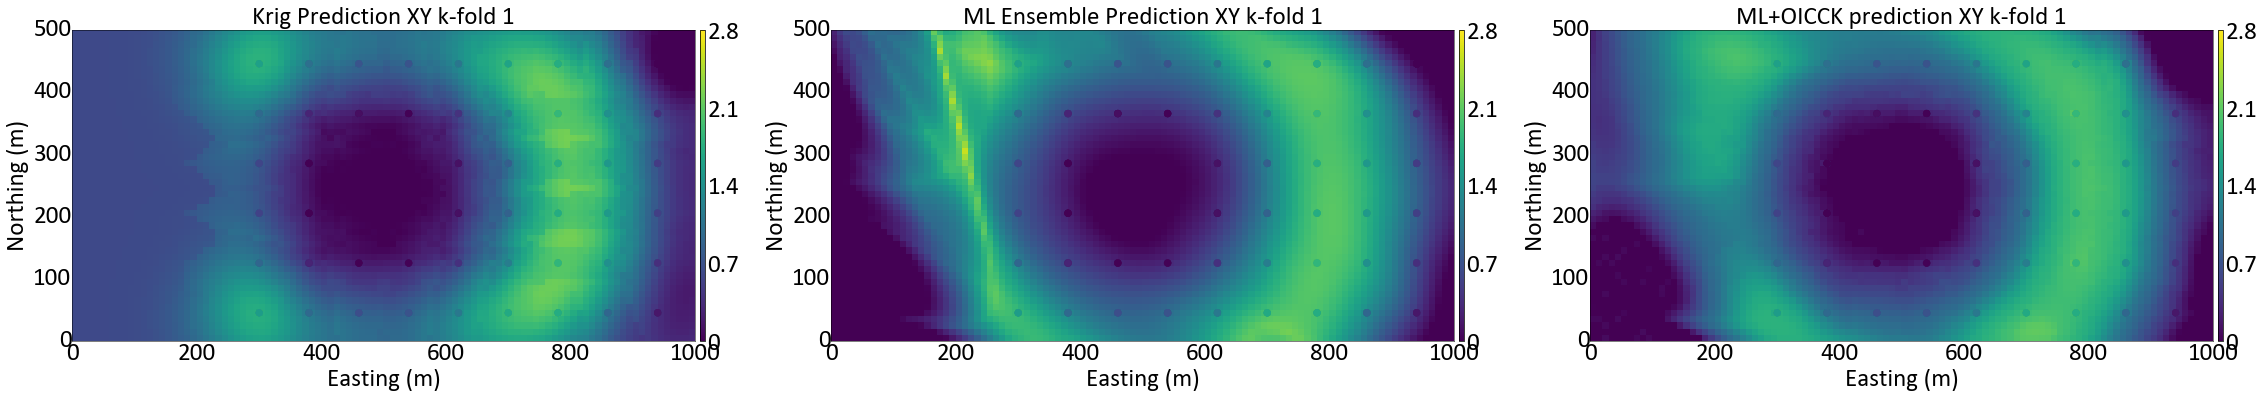

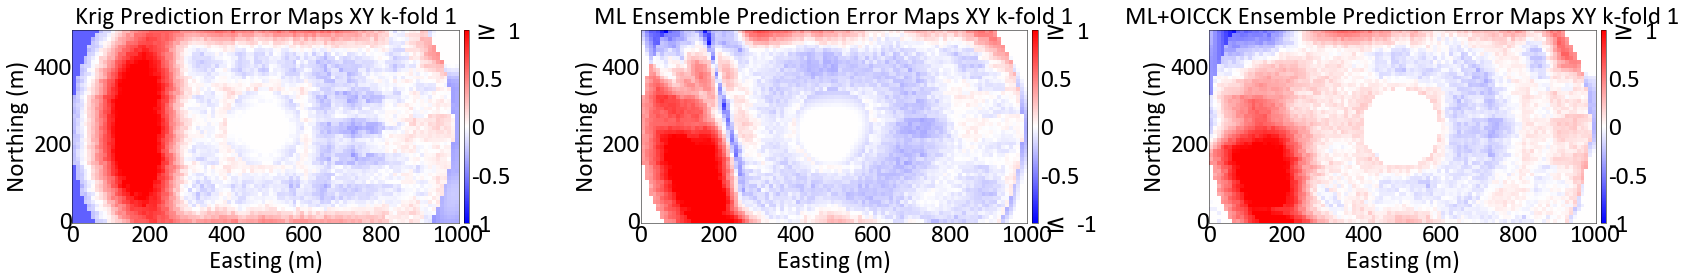

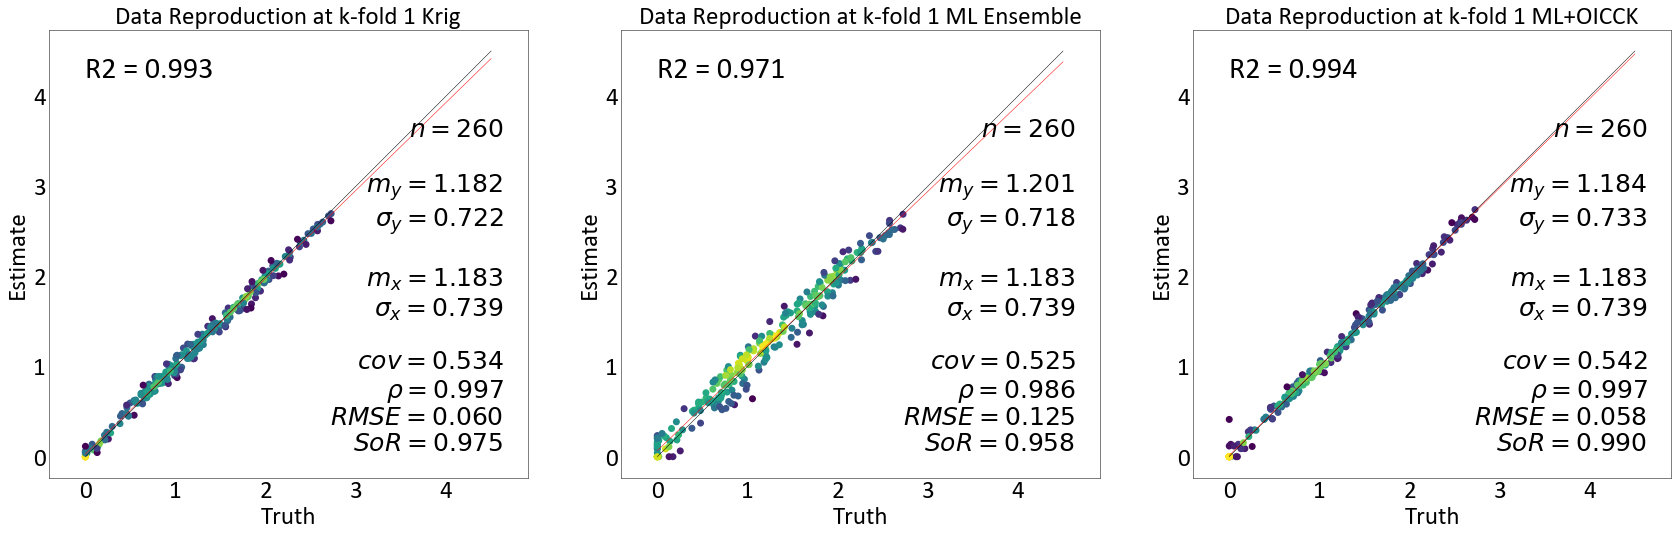

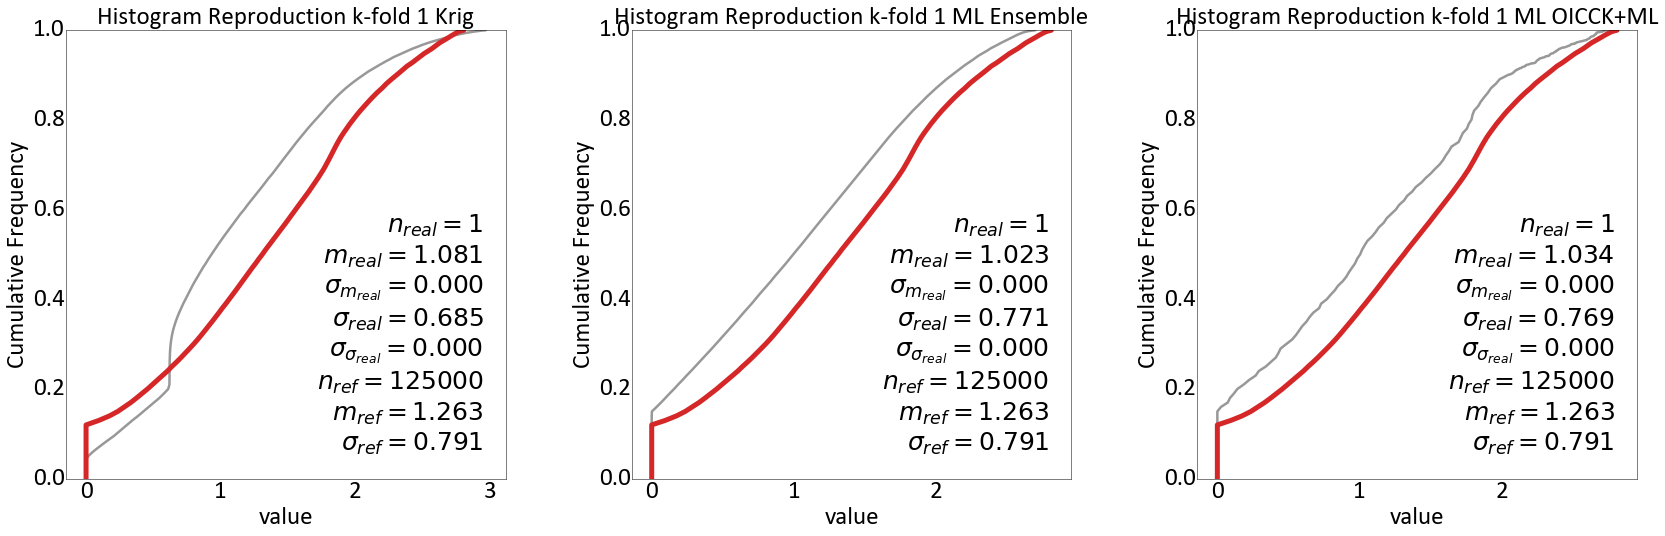

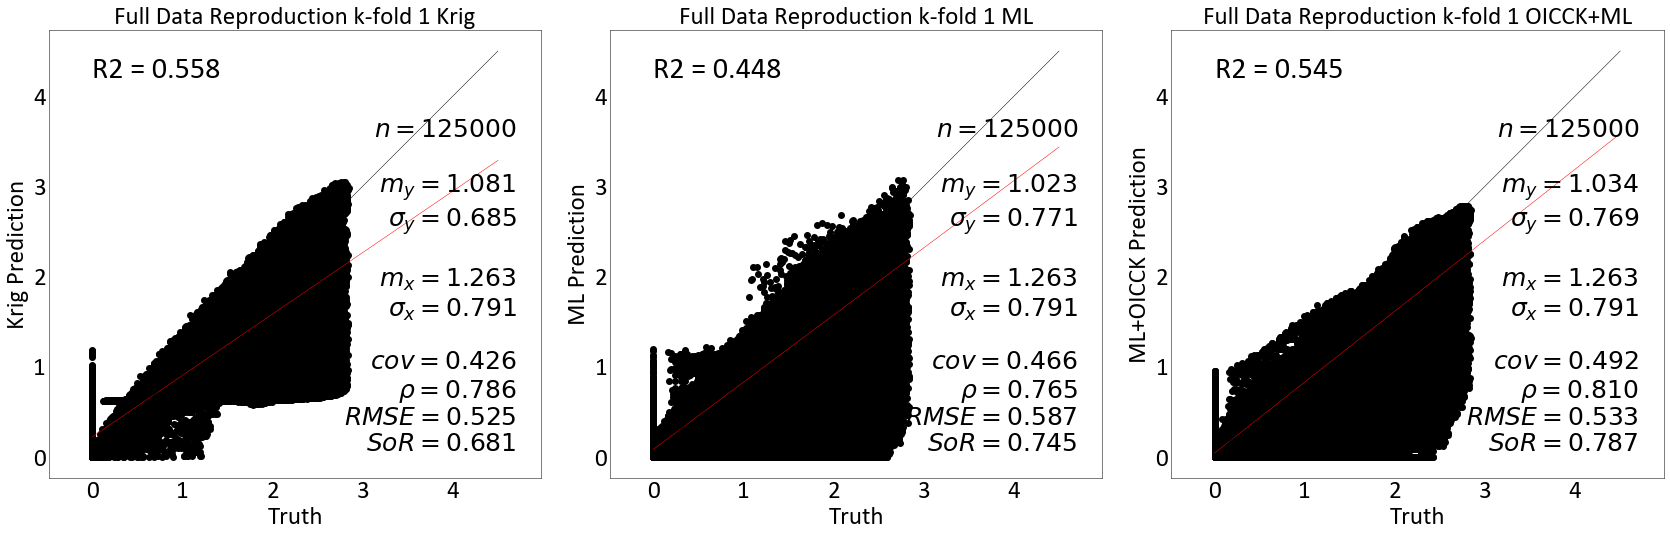

the r2 for krig k-fold 0.9934123217693964
the r2 for ML k-fold 0.9711593212631286
the r2 for krig full 0.5584671107616669
the r2 for ML full 0.4481222275444462


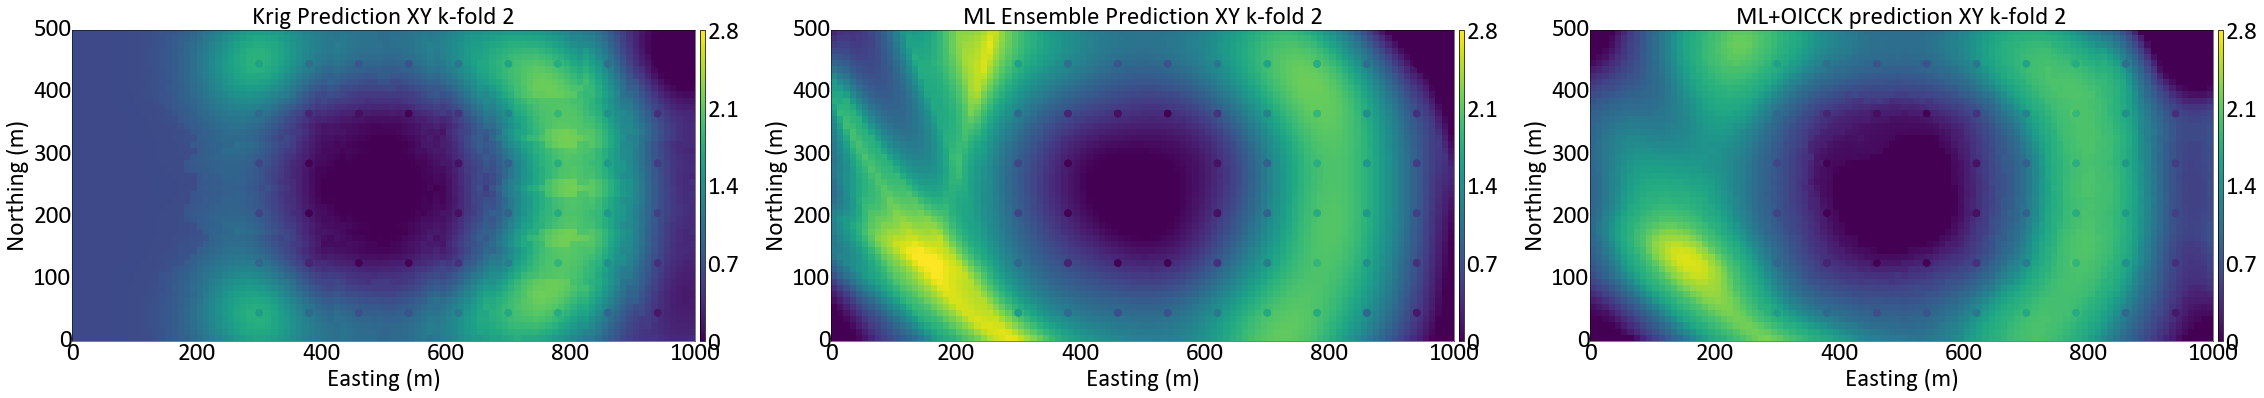

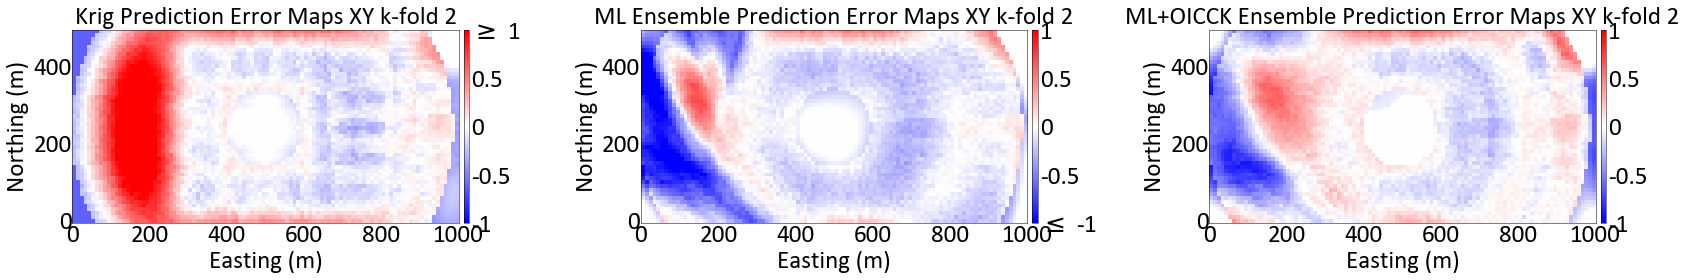

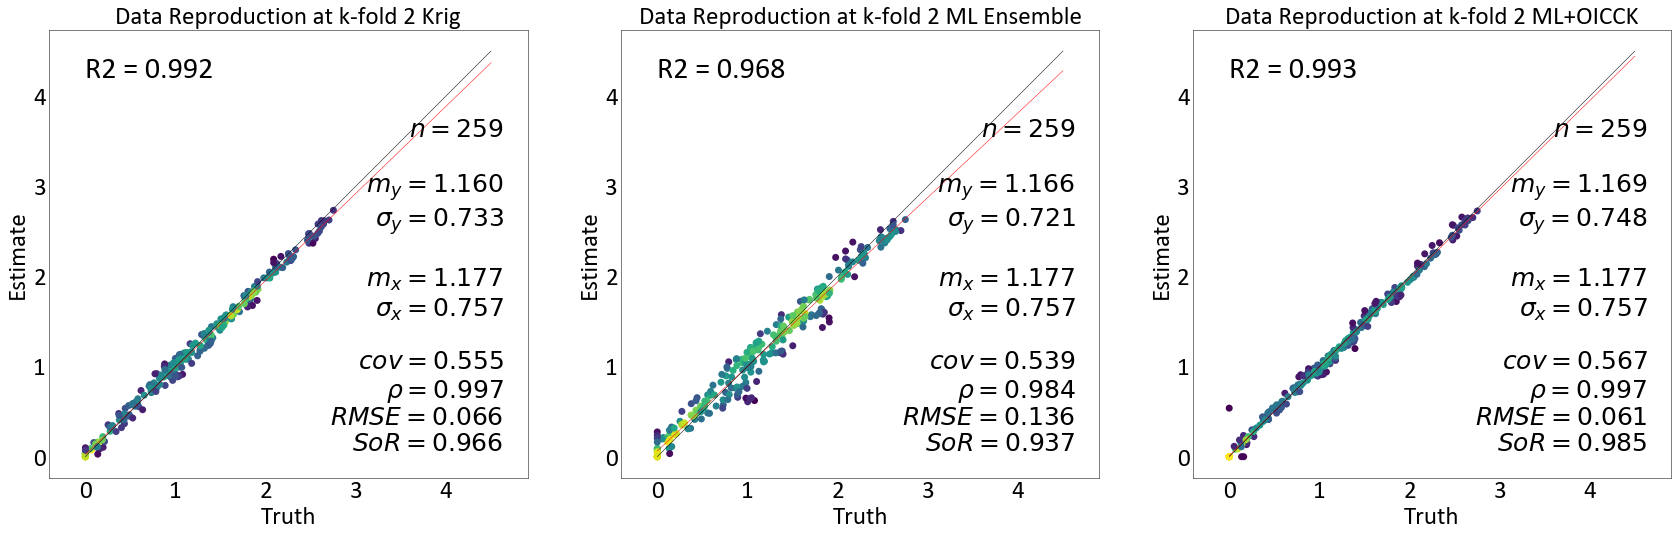

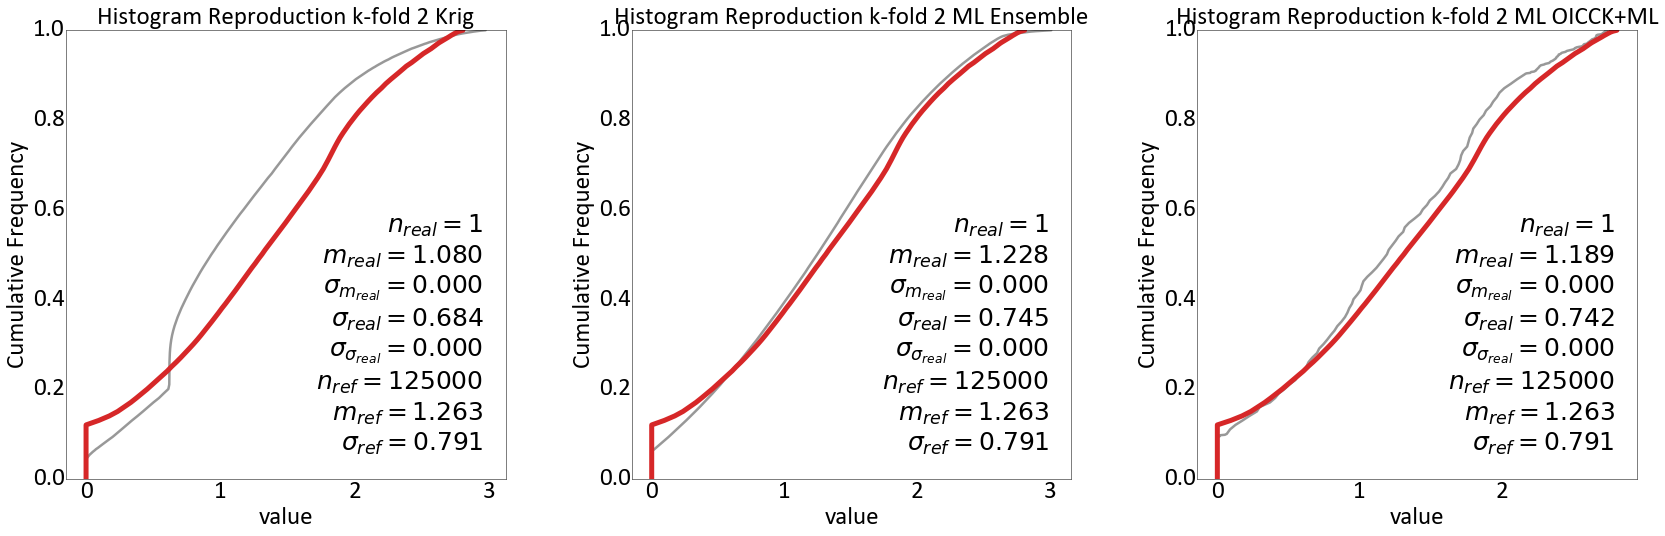

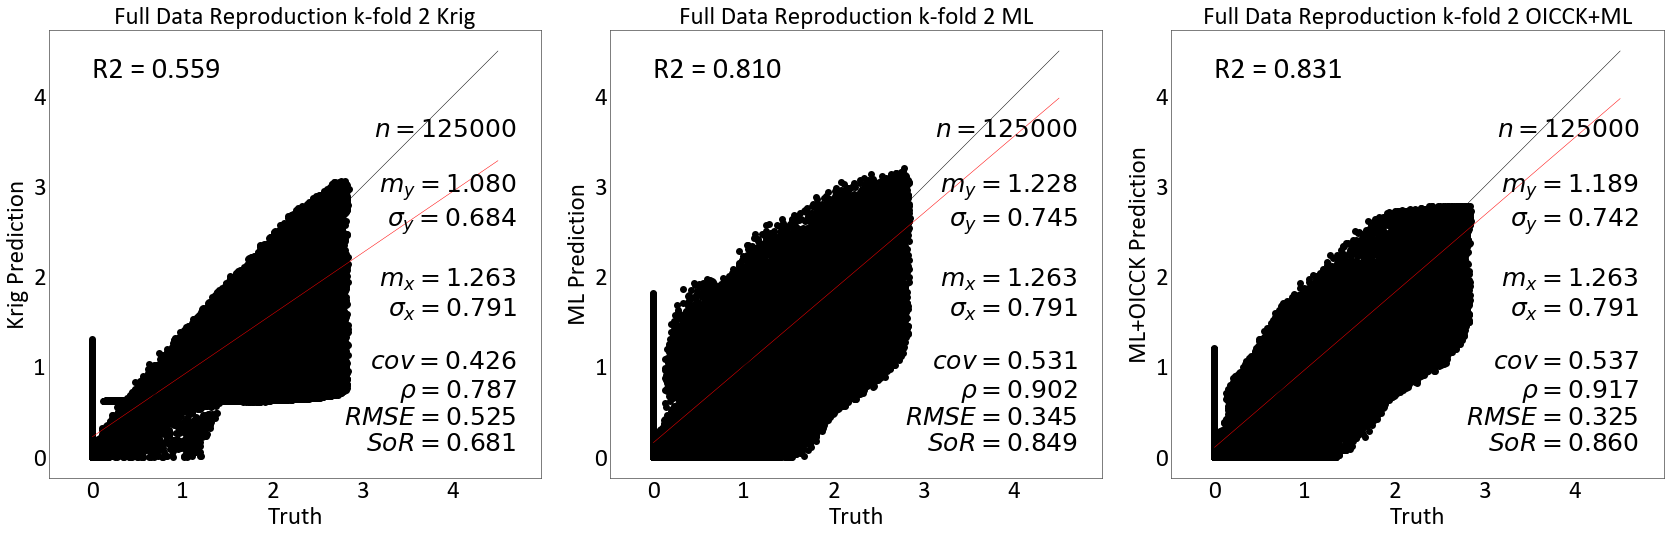

the r2 for krig k-fold 0.9923678445823085
the r2 for ML k-fold 0.9677157017414334
the r2 for krig full 0.559407874442039
the r2 for ML full 0.8099331793860025


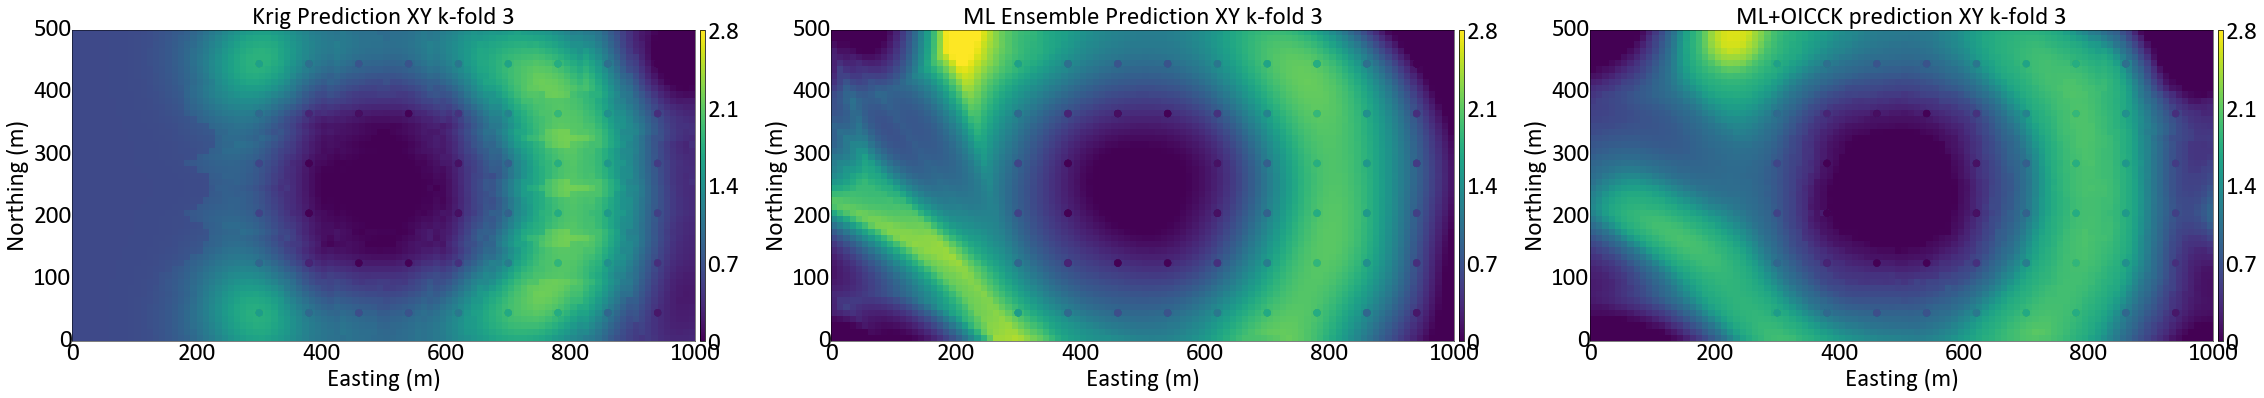

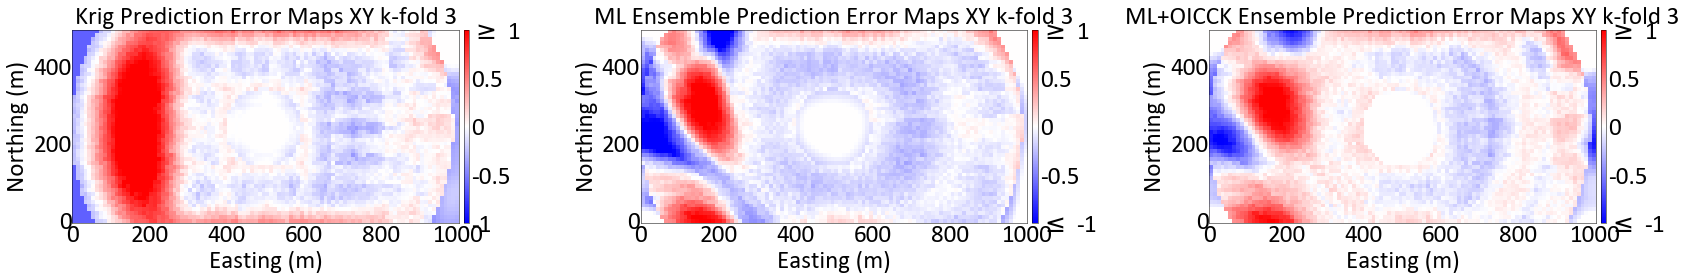

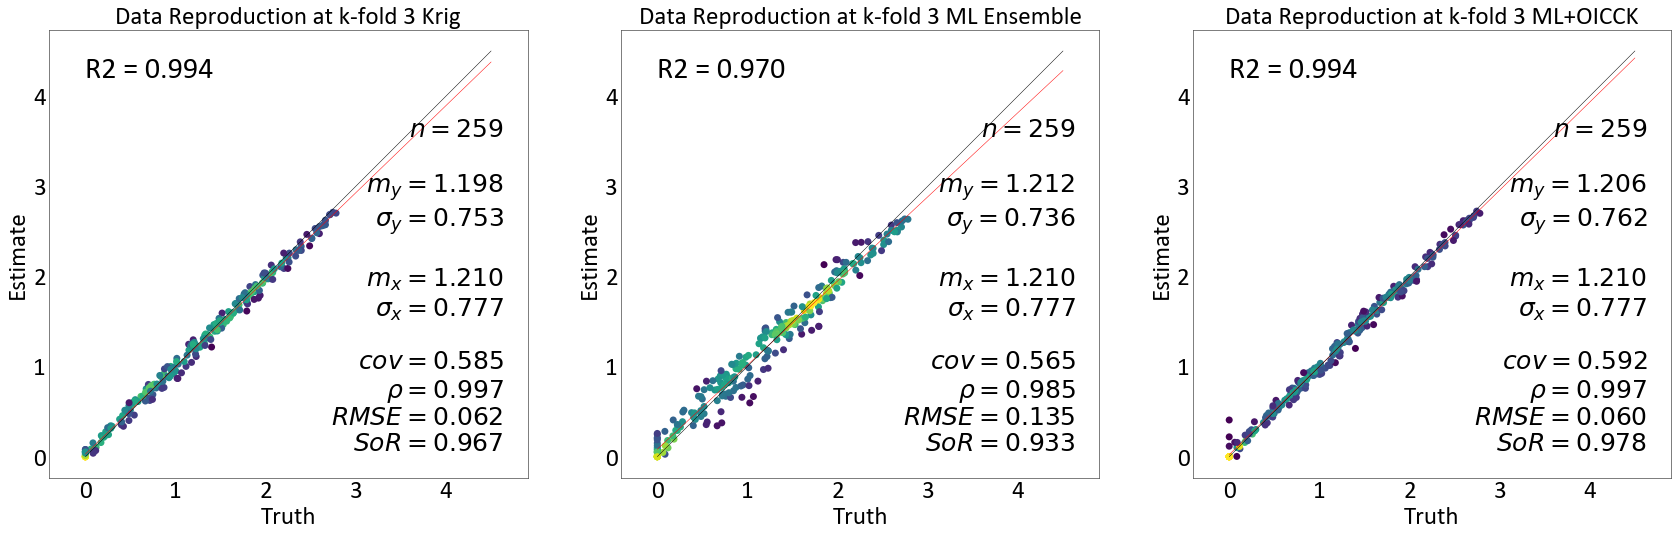

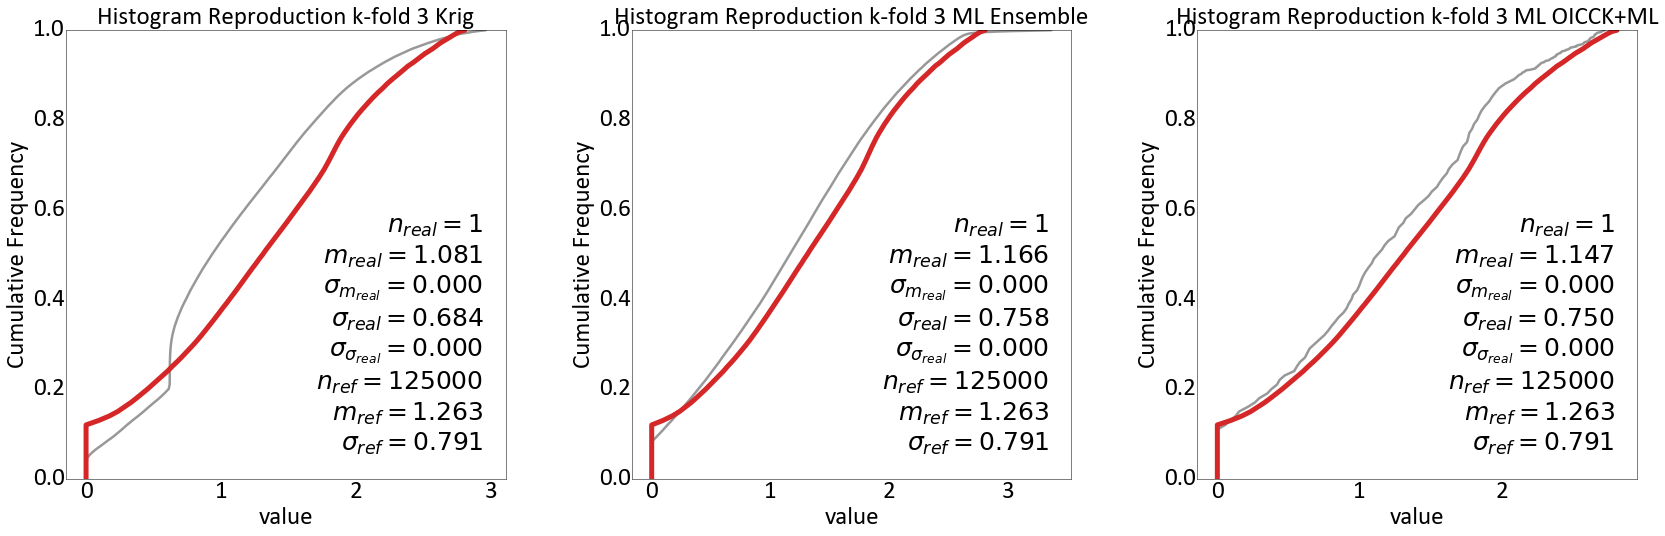

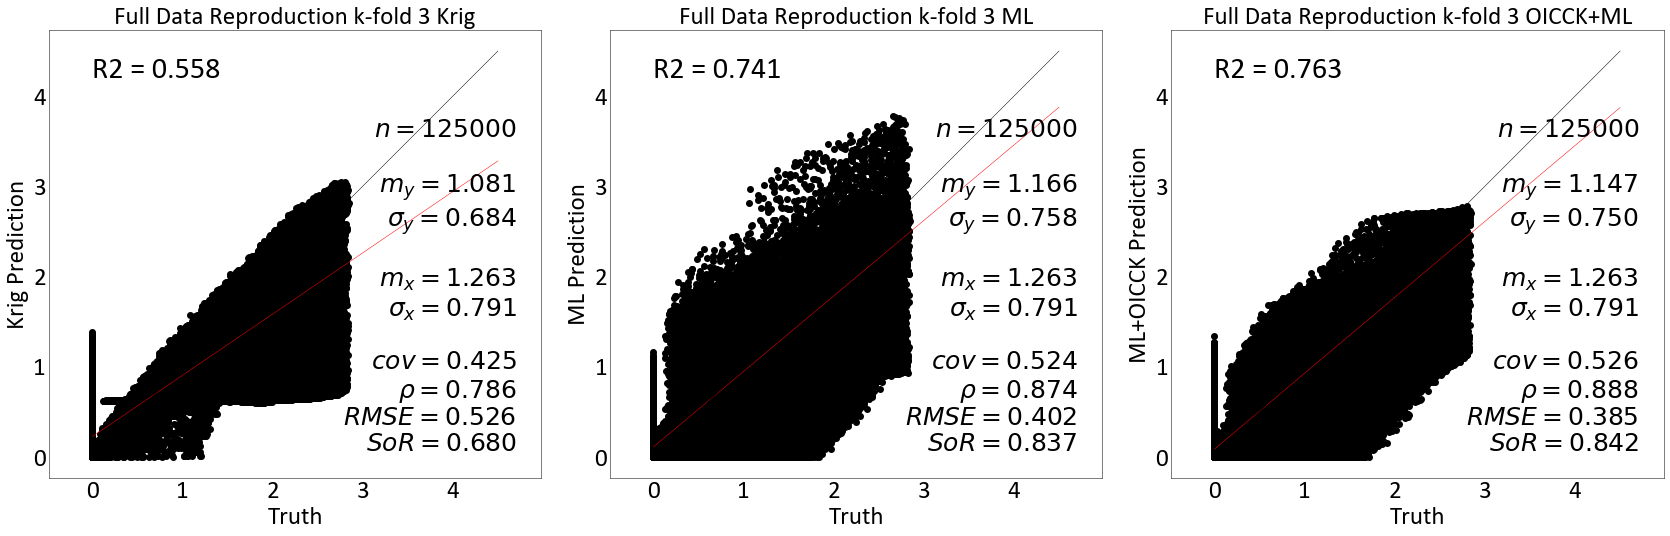

the r2 for krig k-fold 0.9936585230486072
the r2 for ML k-fold 0.9695886684832414
the r2 for krig full 0.5580183875676612
the r2 for ML full 0.7408962898294434


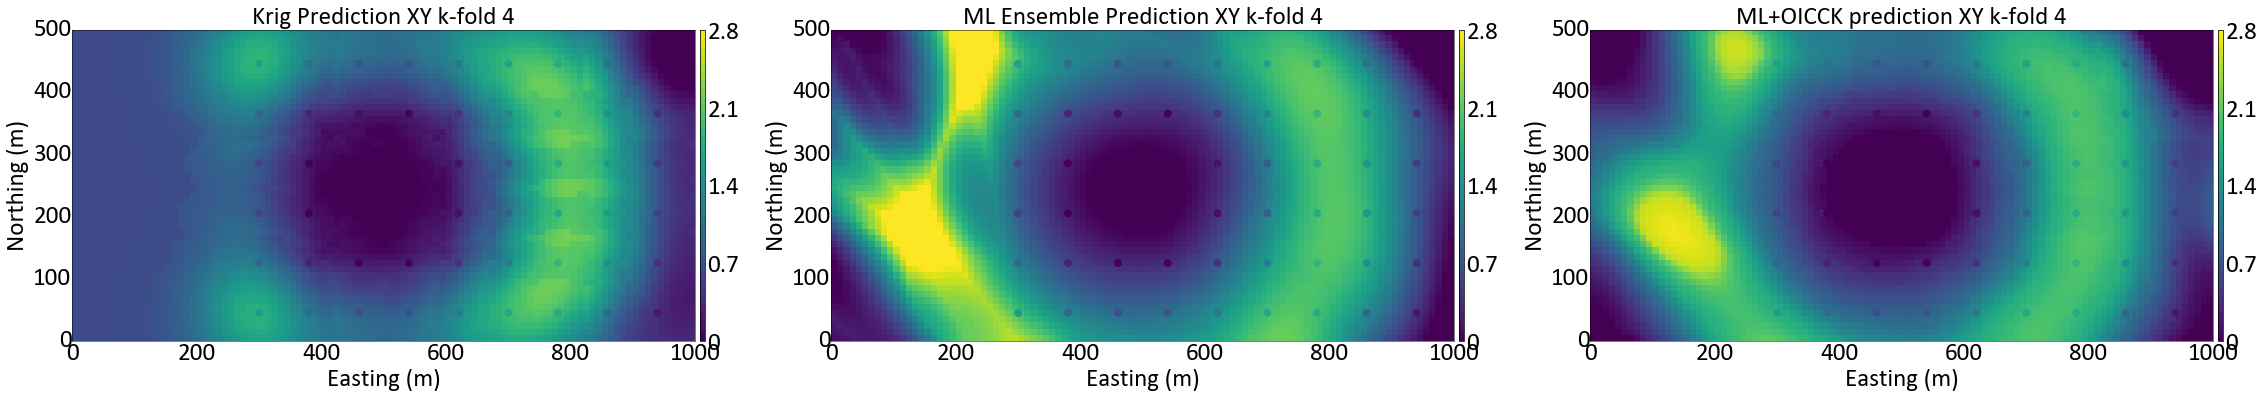

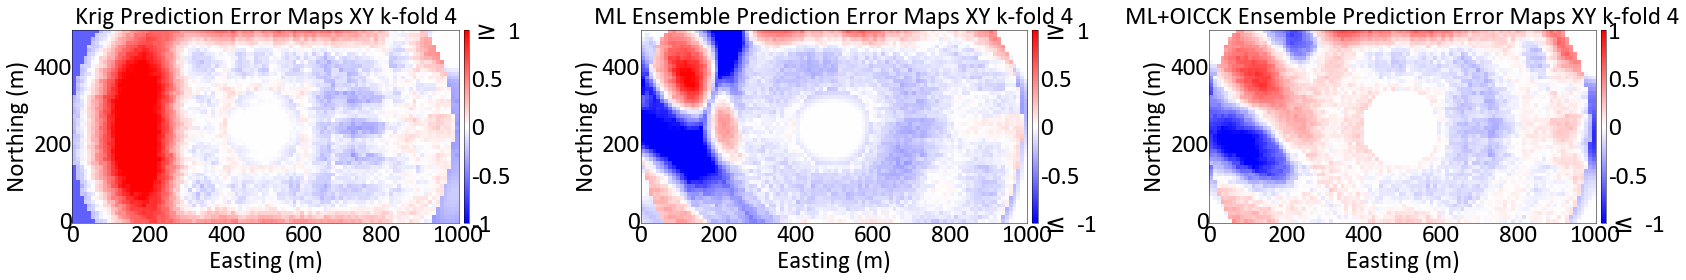

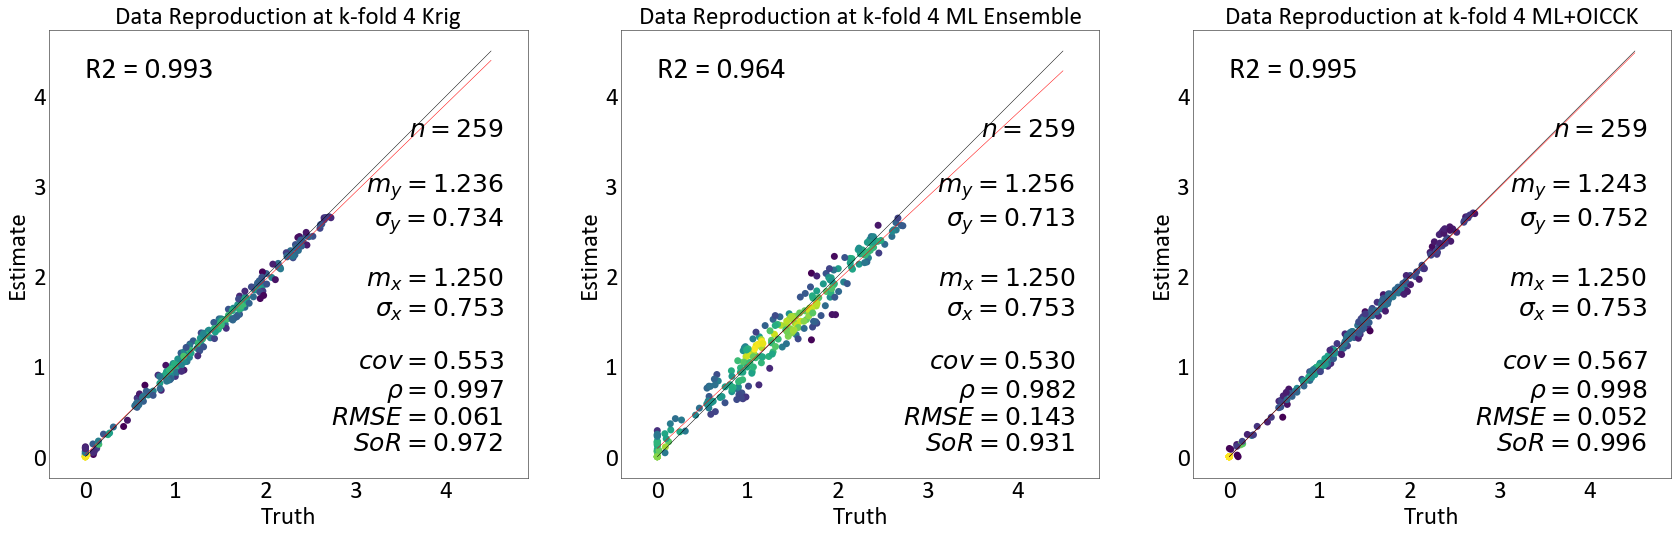

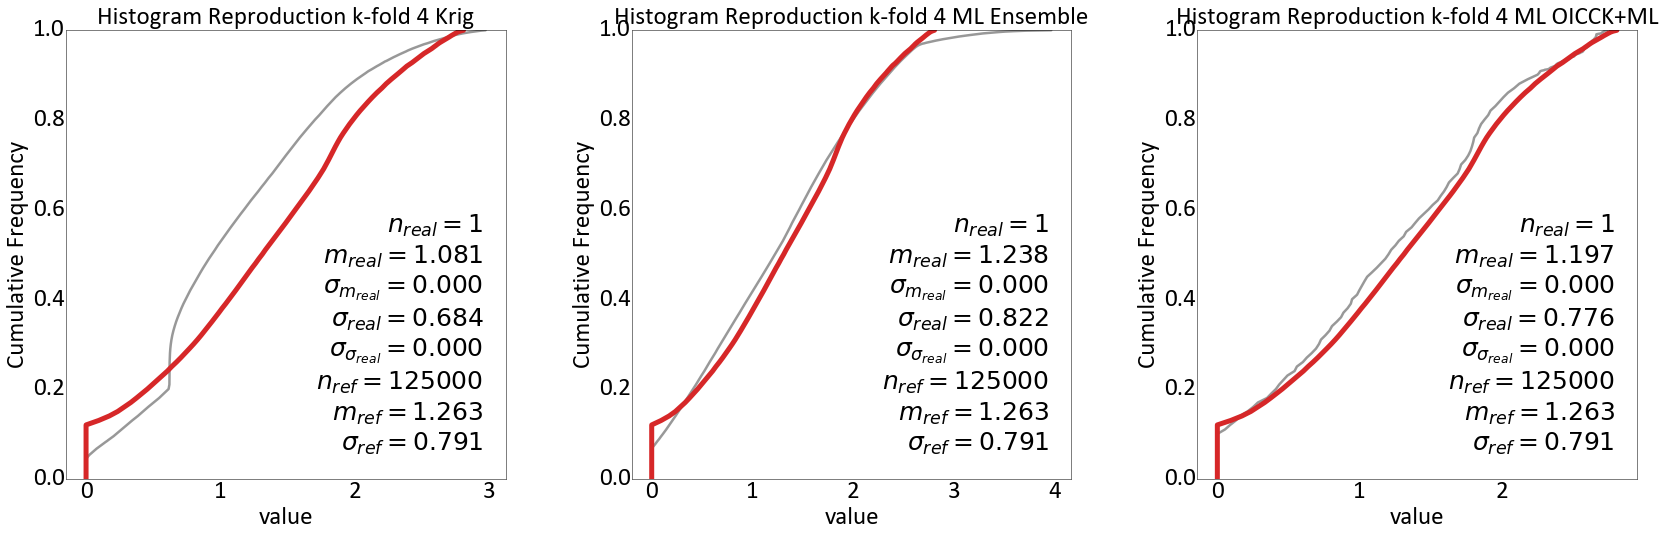

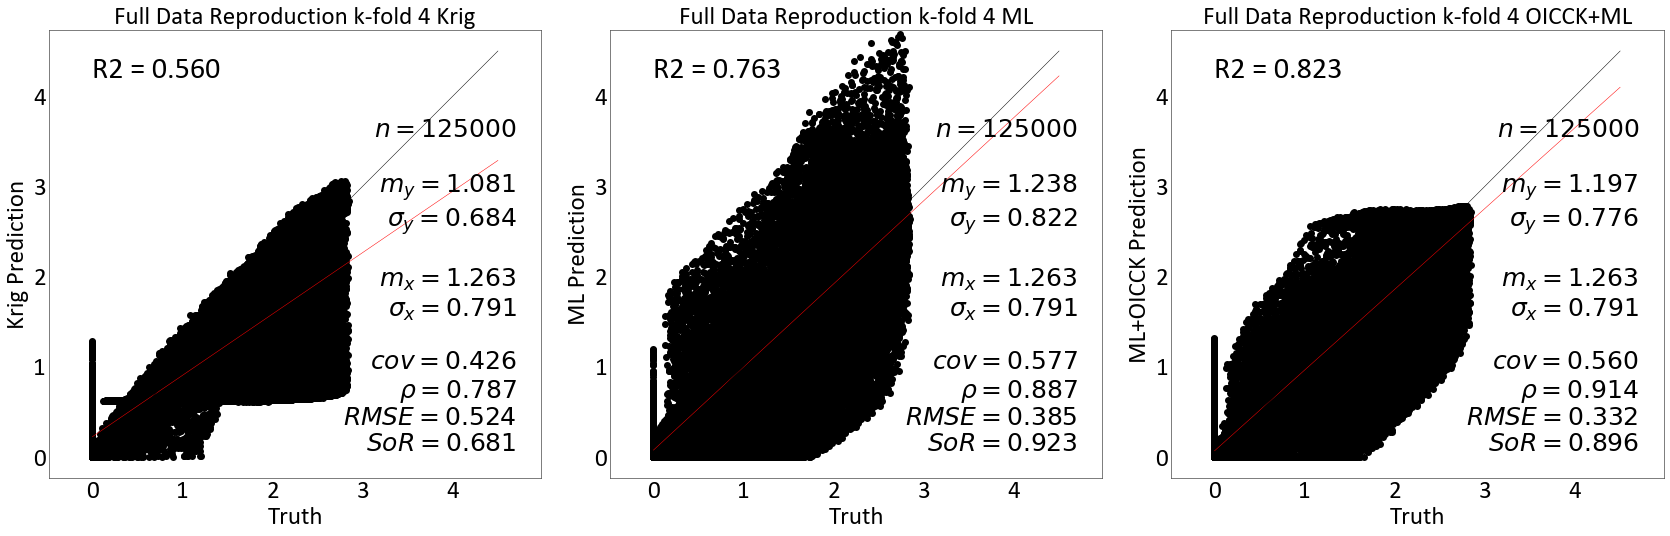

the r2 for krig k-fold 0.9934489574794956
the r2 for ML k-fold 0.9638216225653915
the r2 for krig full 0.5599369345626656
the r2 for ML full 0.7627050349407457


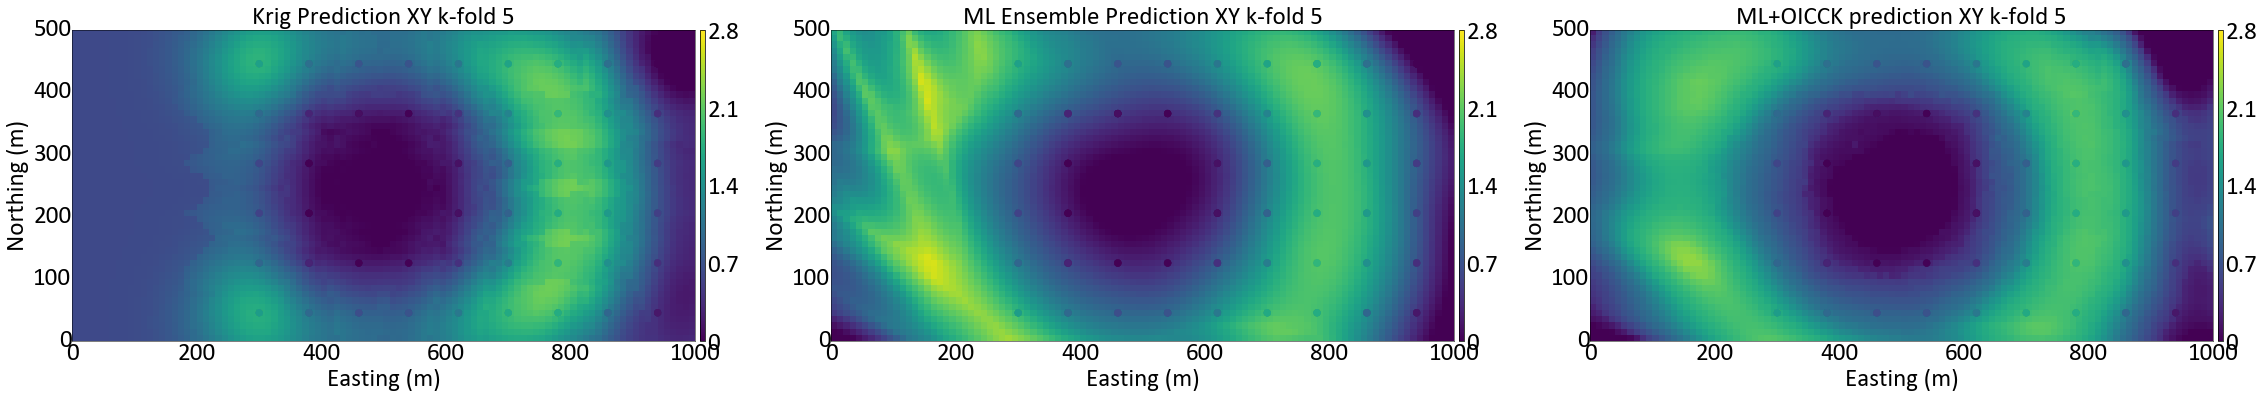

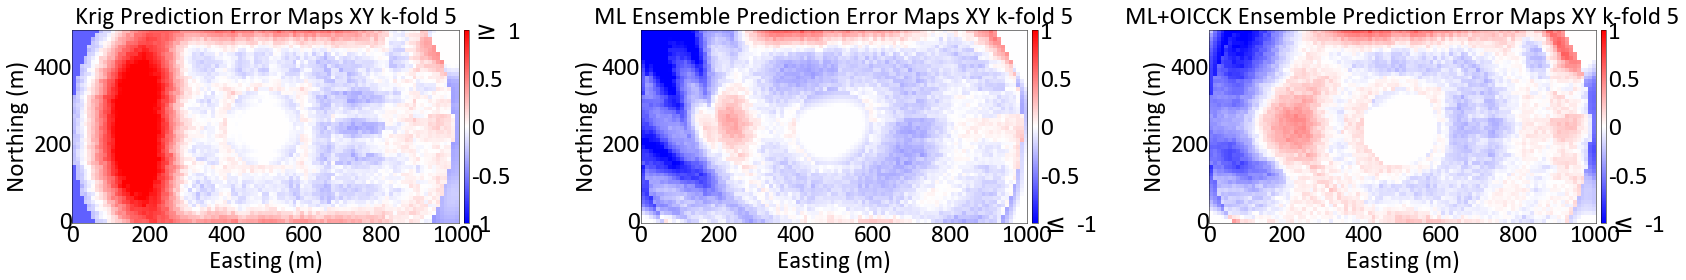

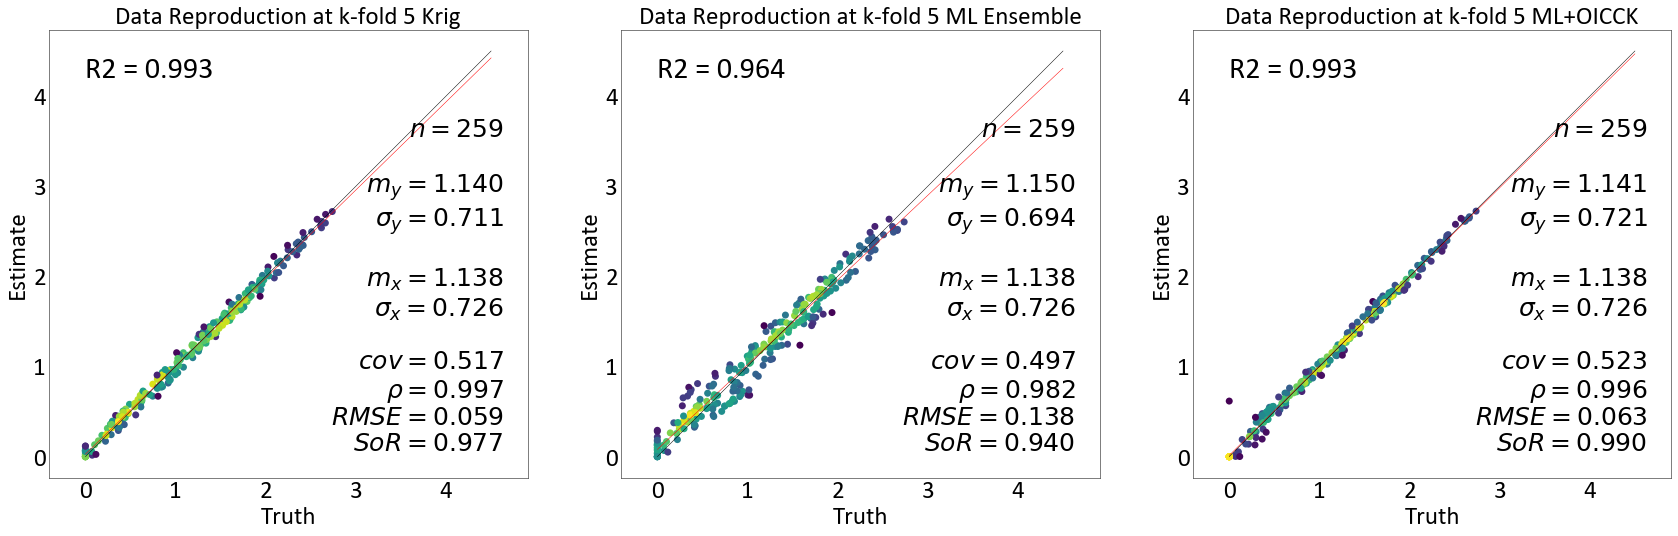

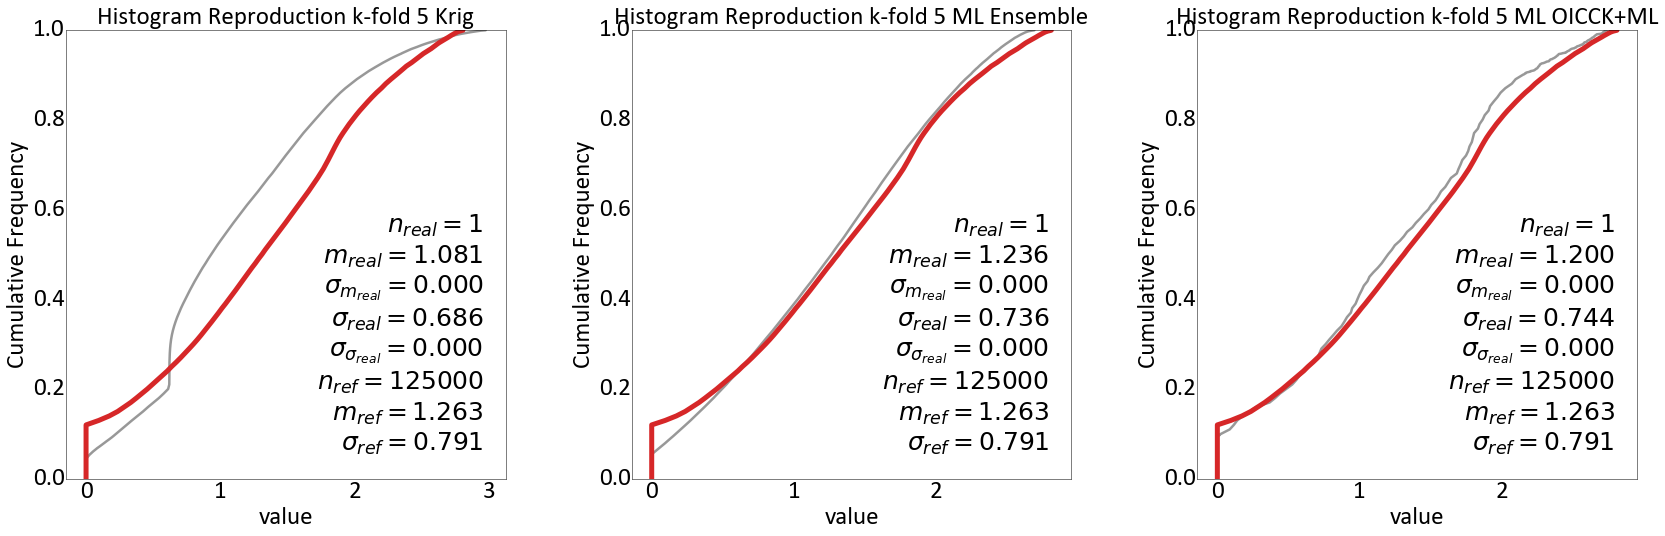

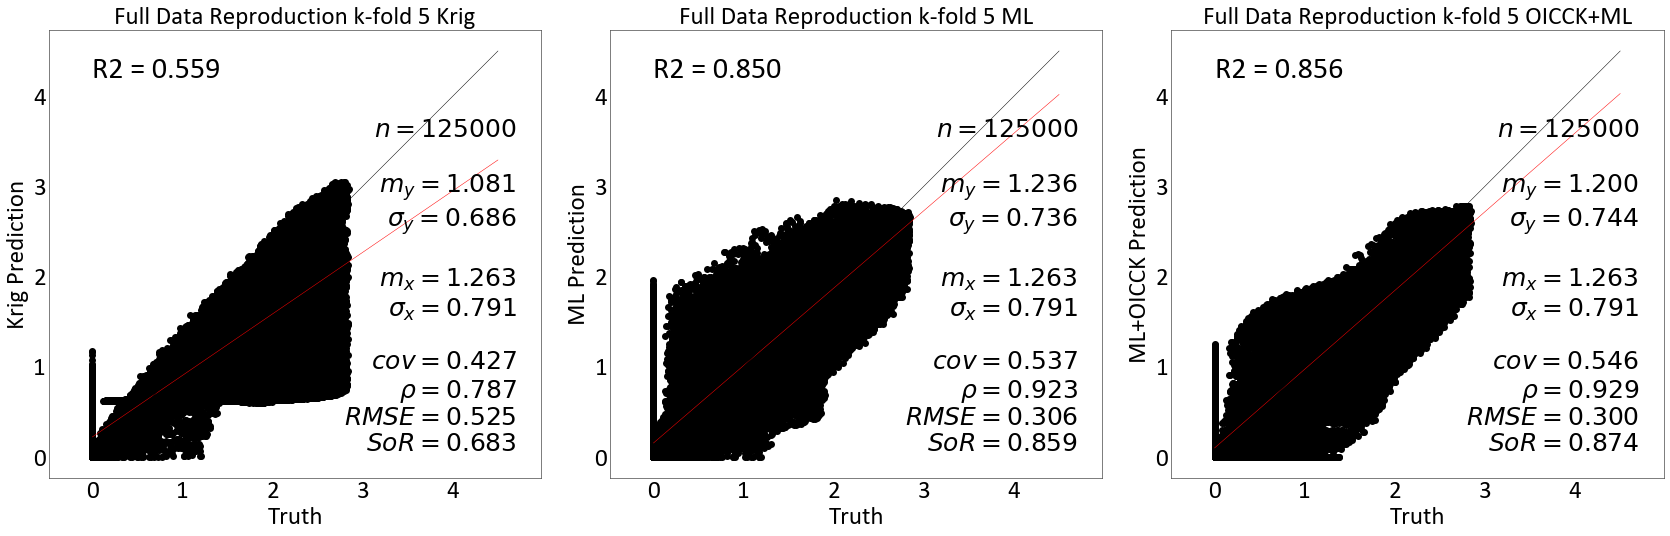

the r2 for krig k-fold 0.9934061030030507
the r2 for ML k-fold 0.9637951890534447
the r2 for krig full 0.5591537796080889
the r2 for ML full 0.8503794125398203
the average r2 of the krig is 0.9932587499765717
the average r2 of the ML is 0.967216100621328
the average r2 of the ML_oICCK is 0.0
the average rmse of the krig is 0.06161333803392261
the average rmse of the ML is 0.13576884493046093
the average rmse of the ML_oicck is 0.0
the average r2 of the full model for krig is 0.5589968173884243
the average r2 of the full model for ML is 0.7224072288480916
the average r2 of the full model for ML_oicck is 0.0
the average rmse of the full model for krig is 0.5250509547562647
the average rmse of the full model for ML is 0.4165668122611637
the average rmse of the full model for ML_oicck is 0.3843542542798913


In [23]:
sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
gs.set_style('pt25')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
vlim =(0,2.8)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
r2_krg_full = 0 
r2_ML_full = 0
mse_krg_full = 0
mse_ML_full = 0
mse_ML_icck = 0
r2_ML_icck = 0
r2_ML_icck_full = 0
mse_ML_icck_full = 0
mse_ML_oicck = 0
r2_ML_oicck = 0
r2_ML_oicck_full = 0
mse_ML_oicck_full = 0

r_2_Full_ML_List = []
r_2_kfold_ML_List = []
rmse_Full_ML_List = []
rmse_kfold_ML_List = []
mean_ML = []
sigma_ML = []

r_2_Full_krig_List = []
r_2_kfold_krig_List = []
rmse_Full_krig_List = []
rmse_kfold_krig_List = []
mean_krig = []
sigma_krig = []

r_2_Full_ML_icck_List = []
r_2_kfold_ML_icck_List = []
rmse_Full_ML_icck_List = []
rmse_kfold_ML_icck_List = []
mean_ML_icck = []
sigma_ML_icck = []

r_2_Full_ML_oicck_List = []
r_2_kfold_ML_oicck_List = []
rmse_Full_ML_oicck_List = []
rmse_kfold_ML_oicck_List = []
mean_ML_oicck = []
sigma_ML_oicck = []

var = 'value'
sigma = 0
for fold in range(1,6):
    i += 1
    testfile = gs.DataFile('./data/data_test_{}.dat'.format(fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    pltdat_kt3dn.data['Estimate'][pltdat_kt3dn.data['Estimate'] < 0] = 0
    pltdat_ml = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
    pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = sigma))
    pltdat_ml[pltdat_ml < 0] = 0
    #pltdat_ml_icck = gs.DataFile('./backtr/backtr_UDDH_ICCK_{}.out'.format(fold),griddef=griddef)
    #pltdat_ml_icck.data['Back Transform'][pltdat_ml_icck.data['Back Transform'] < 0] = 0
    pltdat_ml_oicck = gs.DataFile('./backtr/backtr_UDDH_OICCK_{}.out'.format(fold),griddef=griddef)
    pltdat_ml_oicck.data['Back Transform'][pltdat_ml_oicck.data['Back Transform'] < 0] = 0
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    f, axes = plt.subplots(1, 3, figsize=(32, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    #axes[3].set_aspect('equal', 'box')

    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'Krig Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'Krig Prediction XY k-fold {}'.format(fold))

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Ensemble Prediction XY k-fold {}'.format(fold))

#     ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
#                 title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno)
#     ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML+ICCK prediction XY k-fold {}'.format(fold))
    ax5 = gs.pixelplt(pltdat_ml_oicck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno)
    ax5 = gs.locmap(datasamplefl,griddef=griddef, ax=ax5,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML+OICCK prediction XY k-fold {}'.format(fold))
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/pix_xy_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))

    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    #axes[3].set_aspect('equal', 'box')
    
    ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_kt3dn.data['Estimate']),ax = axes[0],
                title = 'Krig Prediction Error Maps XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr',griddef=griddef)
    #ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'krig prediction XY', orient = 'xz')

    ax3 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction Error Maps XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
    
#     ax4 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml_icck.data['Back Transform']),griddef=griddef,ax = axes[2],vlim=(-1,1),
#                 title = 'ML+ICCK Ensemble Prediction Error Maps XY k-fold {}'.format(fold), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z',orient = 'xy',var = var , vlim=vlim,title = 'ML+OICCK prediction XY')
    ax5 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml_oicck.data['Back Transform']),griddef=griddef,ax = axes[2],vlim=(-1,1),
                title = 'ML+OICCK Ensemble Prediction Error Maps XY k-fold {}'.format(fold), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/error_xy_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    #axes[3].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values,xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} Krig'.format(fold),dens=True,ax = axes[0],vlim=(0,4.5))
    
    ax2.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values)),size=30)
    
    ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} ML Ensemble'.format(fold),dens=True,ax = axes[1],vlim=(0,4.5))
    
    ax3.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml[idx])),size=30)
    
#     ax4 = gs.scatxval(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values,xlabel='Truth', ylabel='Estimate',
#          title = 'Data Reproduction at k-fold {} ML+ICCK'.format(fold),dens=True,ax = axes[2],vlim=(0,5))
    
#     ax4.text(0,4.7,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values)),size=25)
    
    ax5 = gs.scatxval(testfile.data[var],pltdat_ml_oicck.data['Back Transform'][idx].values,xlabel='Truth', ylabel='Estimate',
         title = 'Data Reproduction at k-fold {} ML+OICCK'.format(fold),dens=True,ax = axes[2],vlim=(0,4.5))
    
    ax5.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml_oicck.data['Back Transform'][idx].values)),size=30)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/kfold_datarep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],sgsimfl['value'],ax=axes[0],lw=5,title = 'Histogram Reproduction k-fold {} Krig'.format(fold),griddef=griddef,nreal=1)


    ax3 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[1],lw=5,title = 'Histogram Reproduction k-fold {} ML Ensemble'.format(fold),griddef=griddef,nreal=1)

#     ax4 = gs.histpltsim(pltdat_ml_icck.data['Back Transform'],sgsimfl['value'],ax=axes[2],lw=5,griddef=griddef,nreal=1,
#                        title = 'Histogram Reproduction k-fold {} ML ICCK+ML'.format(fold))
    ax4 = gs.histpltsim(pltdat_ml_oicck.data['Back Transform'],sgsimfl['value'],ax=axes[2],lw=5,griddef=griddef,nreal=1,
                       title = 'Histogram Reproduction k-fold {} ML OICCK+ML'.format(fold))

    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/histsim_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
   # axes[3].set_aspect('equal', 'box')
    ax2 = gs.scatxval(sgsimfl['value'],pltdat_kt3dn.data['Estimate'],ax=axes[0],griddef=griddef,xlabel='Truth'
                      ,title = 'Full Data Reproduction k-fold {} Krig'.format(fold), ylabel ='Krig Prediction',vlim =(0,4.5),desn=True)
    ax2.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])),size=30)

    ax3 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[1],griddef=griddef,xlabel='Truth',ylabel='ML Prediction',
                      title = 'Full Data Reproduction k-fold {} ML'.format(fold),label ='ML Prediction',vlim =(0,4.5),desn=True)
    ax3.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml)),size=30)
#     ax4 = gs.scatxval(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'],ax=axes[2],griddef=griddef,xlabel='Truth', ylabel ='ML+OICCK Prediction',
#                       vlim =(0,5),title = 'Full Data Reproduction k-fold {} ICCK+ML'.format(fold))
#     ax4.text(0,4.7,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])),size=25)
    ax5 = gs.scatxval(sgsimfl['value'],pltdat_ml_oicck.data['Back Transform'],ax=axes[2],griddef=griddef,xlabel='Truth', ylabel ='ML+OICCK Prediction',
                      vlim =(0,4.5),title = 'Full Data Reproduction k-fold {} OICCK+ML'.format(fold))
    ax5.text(0,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml_oicck.data['Back Transform'])),size=30)
    
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/full_datarep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()
    
    print('the r2 for krig k-fold {}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
    print('the r2 for krig full {}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))
    
    r_2_Full_ML_List.append(r2_score(sgsimfl['value'],pltdat_ml))
    r_2_kfold_ML_List.append(r2_score(testfile.data[var],pltdat_ml[idx]))
    #r_2_Full_ML_icck_List.append(r2_score(sgsimfl['value'],pltdat_ml_icck.data['Back Transform']))
    #r_2_kfold_ML_icck_List.append(r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx]))
    r_2_Full_ML_oicck_List.append(r2_score(sgsimfl['value'],pltdat_ml_oicck.data['Back Transform']))
    r_2_kfold_ML_oicck_List.append(r2_score(testfile.data[var],pltdat_ml_oicck.data['Back Transform'][idx]))
    r_2_Full_krig_List.append(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate']))
    r_2_kfold_krig_List.append(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx]))

    rmse_Full_ML_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_ml)))
    rmse_kfold_ML_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_ml[idx])))
    #rmse_Full_ML_icck_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])))
    #rmse_kfold_ML_icck_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])))
    rmse_Full_ML_oicck_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_ml_oicck.data['Back Transform'])))
    rmse_kfold_ML_oicck_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_ml_oicck.data['Back Transform'][idx])))
    rmse_Full_krig_List.append(np.sqrt(mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    rmse_kfold_krig_List.append(np.sqrt(mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    
    mean_ML.append(np.mean(pltdat_ml))
    sigma_ML.append(np.std(pltdat_ml))
#     mean_ML_icck.append(np.mean(pltdat_ml_icck.data['Back Transform']))
#     sigma_ML_icck.append(np.std(pltdat_ml_icck.data['Back Transform']))
    mean_ML_oicck.append(np.mean(pltdat_ml_oicck.data['Back Transform']))
    sigma_ML_oicck.append(np.std(pltdat_ml_oicck.data['Back Transform']))
    mean_krig.append(np.mean(pltdat_kt3dn.data['Estimate']))
    sigma_krig.append(np.std(pltdat_kt3dn.data['Estimate']))
    
    
    
    mse_krg = mse_krg + mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    mse_ML = mse_ML + mean_squared_error(testfile.data[var],pltdat_ml[idx])
    #mse_ML_icck = mse_ML_icck + mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg = r2_krg + r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    r2_ML = r2_ML + r2_score(testfile.data[var],pltdat_ml[idx])
    #r2_ML_icck = r2_ML_icck + r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg_full = r2_krg_full + r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    r2_ML_full = r2_ML_full + r2_score(sgsimfl['value'],pltdat_ml)
    #r2_ML_icck_full = r2_ML_icck_full + r2_score(sgsimfl['value'].values,pltdat_ml_icck.data['Back Transform'].values)
    mse_krg_full = mse_krg_full + mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    mse_ML_full = mse_ML_full + mean_squared_error(sgsimfl['value'],pltdat_ml)
    #mse_ML_icck_full = mse_ML_icck_full + mean_squared_error(sgsimfl['value'],pltdat_ml_icck.data['Back Transform'])
    mse_ML_oicck_full = mse_ML_oicck_full + mean_squared_error(sgsimfl['value'],pltdat_ml_oicck.data['Back Transform'])
    
    gs.write_gslib(pd.DataFrame(pltdat_ml),'./predictions/ML_pred_{}.dat'.format(fold))
    
print('the average r2 of the krig is {}'.format(r2_krg/i))
print('the average r2 of the ML is {}'.format(r2_ML/i))
#print('the average r2 of the ML_ICCK is {}'.format(r2_ML_icck/i))
print('the average r2 of the ML_oICCK is {}'.format(r2_ML_oicck/i))
print('the average rmse of the krig is {}'.format(np.sqrt(mse_krg/i)))
print('the average rmse of the ML is {}'.format(np.sqrt(mse_ML/i)))
#print('the average rmse of the ML_icck is {}'.format(np.sqrt(mse_ML_icck/i)))
print('the average rmse of the ML_oicck is {}'.format(np.sqrt(mse_ML_oicck/i)))
print('the average r2 of the full model for krig is {}'.format(r2_krg_full/i))
print('the average r2 of the full model for ML is {}'.format(r2_ML_full/i))
#print('the average r2 of the full model for ML_icck is {}'.format(r2_ML_icck_full/i))
print('the average r2 of the full model for ML_oicck is {}'.format(r2_ML_oicck_full/i))
print('the average rmse of the full model for krig is {}'.format(np.sqrt(mse_krg_full/i)))
print('the average rmse of the full model for ML is {}'.format(np.sqrt(mse_ML_full/i)))
#print('the average rmse of the full model for ML_icck is {}'.format(np.sqrt(mse_ML_icck_full/i)))
print('the average rmse of the full model for ML_oicck is {}'.format(np.sqrt(mse_ML_oicck_full/i)))

In [73]:
num_folds = [1,2,3,4,5]
ML_Stats = np.vstack((num_folds,rmse_kfold_ML_List,r_2_kfold_ML_List,rmse_Full_ML_List,r_2_Full_ML_List,sigma_ML,mean_ML)).T
#ML_icck_Stats = np.vstack((num_folds,rmse_kfold_ML_icck_List,r_2_kfold_ML_icck_List,rmse_Full_ML_icck_List,r_2_Full_ML_icck_List,sigma_ML_icck,mean_ML_icck)).T
Krig_Stats = np.vstack((num_folds,rmse_kfold_krig_List,r_2_kfold_krig_List,rmse_Full_krig_List,r_2_Full_krig_List,sigma_krig,mean_krig)).T
ML_oicck_Stats = np.vstack((num_folds,rmse_kfold_ML_oicck_List,r_2_kfold_ML_oicck_List,rmse_Full_ML_oicck_List,r_2_Full_ML_oicck_List,sigma_ML_oicck,mean_ML_oicck)).T


In [74]:
np.savetxt('ML_stats.csv', ML_Stats, delimiter = ',')
np.savetxt('Krig_stats.csv', Krig_Stats, delimiter = ',')
#np.savetxt('ML_icck_stats.csv', ML_icck_Stats, delimiter = ',')
np.savetxt('ML_oicck_stats.csv', ML_oicck_Stats, delimiter = ',')

In [75]:
# sgsimfl = gs.DataFile(flname = 'dataflpd.out', griddef=griddef,readfl=True)
# dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
#                        readfl=True)
# test_nodes = [10,15,25,30]
# gs.set_style('pt60')
# datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
# del datasamplefl['Drill ID']
# del datasamplefl['MD']
# del datasamplefl['Block ID']
# datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
# datasamplefl.describe()
# datatest = np.asmatrix(datasamplefl)
# slinceno=20
# vlim =(0,2.9)
# r2_krg = 0
# r2_ML = 0
# i=0
# mse_krg = 0
# mse_ML = 0
# r2_krg_full = 0 
# r2_ML_full = 0
# mse_krg_full = 0
# mse_ML_full = 0
# mse_ML_icck = 0
# r2_ML_icck = 0
# r2_ML_icck_full = 0
# mse_ML_icck_full = 0

# var = 'value'
# sigma = 0
# for nodes in test_nodes:
#     i += 1
#     testfile = gs.DataFile('./data/data_test_3.dat'.format(nodes))

#     pltdat_ml = gs.DataFile('./predictions/real_{}_3.dat'.format(nodes),griddef=griddef)
    
#     pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = 0))
#     pltdat_ml[pltdat_ml < 0] = 0
#     idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
#     f, axes = plt.subplots(1, 5, figsize=(100, 18))
    
#     ax1 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[0],
#                 title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes),vlim=vlim, sliceno=slinceno)
#     ax1 = gs.locmap(datasamplefl,griddef=griddef, ax=ax1,sliceno=slinceno,
#                     x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes))
    
#     ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
#                 title = 'ML Prediction XY k-fold 3 Kernels {}'.format(nodes),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    
#     ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
#     title = 'Data Reproduction at k-fold 3 ML Kernels {} '.format(nodes),dens=True,ax = axes[2])
    
#     ax4 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[3],
#                         title = 'Histogram Reproduction k-fold 3 ML Kernels {}'.format(nodes),griddef=griddef,nreal=1)
    
#     ax5 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[4],griddef=griddef,xlabel='Truth',
#                   title = 'Full Data Reproduction k-fold 3 Kernels {}'.format(nodes),label ='ML Prediction',vlim =vlim,desn=True)
#     axes[0].set_aspect('equal', 'box')
#     axes[1].set_aspect('equal', 'box')
#     axes[2].set_aspect('equal', 'box')
#     axes[4].set_aspect('equal', 'box')
    
#     plt.tight_layout()
#     plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/nodes_comp_ERBFN_{}_{}.png'.format(plt_extent,nodes))
#     plt.show()
    
#     print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
#     print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))

In [76]:
# dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
#                        readfl=True)
# f, axes = plt.subplots(2, 2, figsize=(16, 16))
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[0,0], griddef = griddef,  title = 'Simulated Truth XY')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[0,1], griddef = griddef,orient='xy', title = 'Location Map of Drill Holes XY')
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[1,0], griddef = griddef,orient='xz', title = 'Simulated Truth XZ')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[1,1], griddef = griddef,orient='xz', title = 'Location Map of Drill Holes XZ')
# plt.tight_layout()
# plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Data_01.png')
# plt.show()

In [77]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat        -file with lithology information
0   7                        -   lithology column (0=not used), code
{datafl}             -file with data
1   {col}                -   number of variables, column numbers
-1.0e21     1.0e21    -   trimming limits
./vargs/varsim_reals_{p_type}_{fold}.out      -output file for variograms of realizations
./vargs/varsim_avg_{p_type}_{fold}.out        -output file for average variogram
{griddef}
1                  -number of realizations
3  100                 -number of directions, number of lags
1  0  0              -ixd(1),iyd(1),izd(1)
0  1  0              -ixd(2),iyd(2),izd(2)
0  0  1              -ixd(2),iyd(2),izd(2)
0                     -standardize sill? (0=no, 1=yes)
1                     -number of variograms
1   1   1             -tail variable, head variable, variogram type
"""

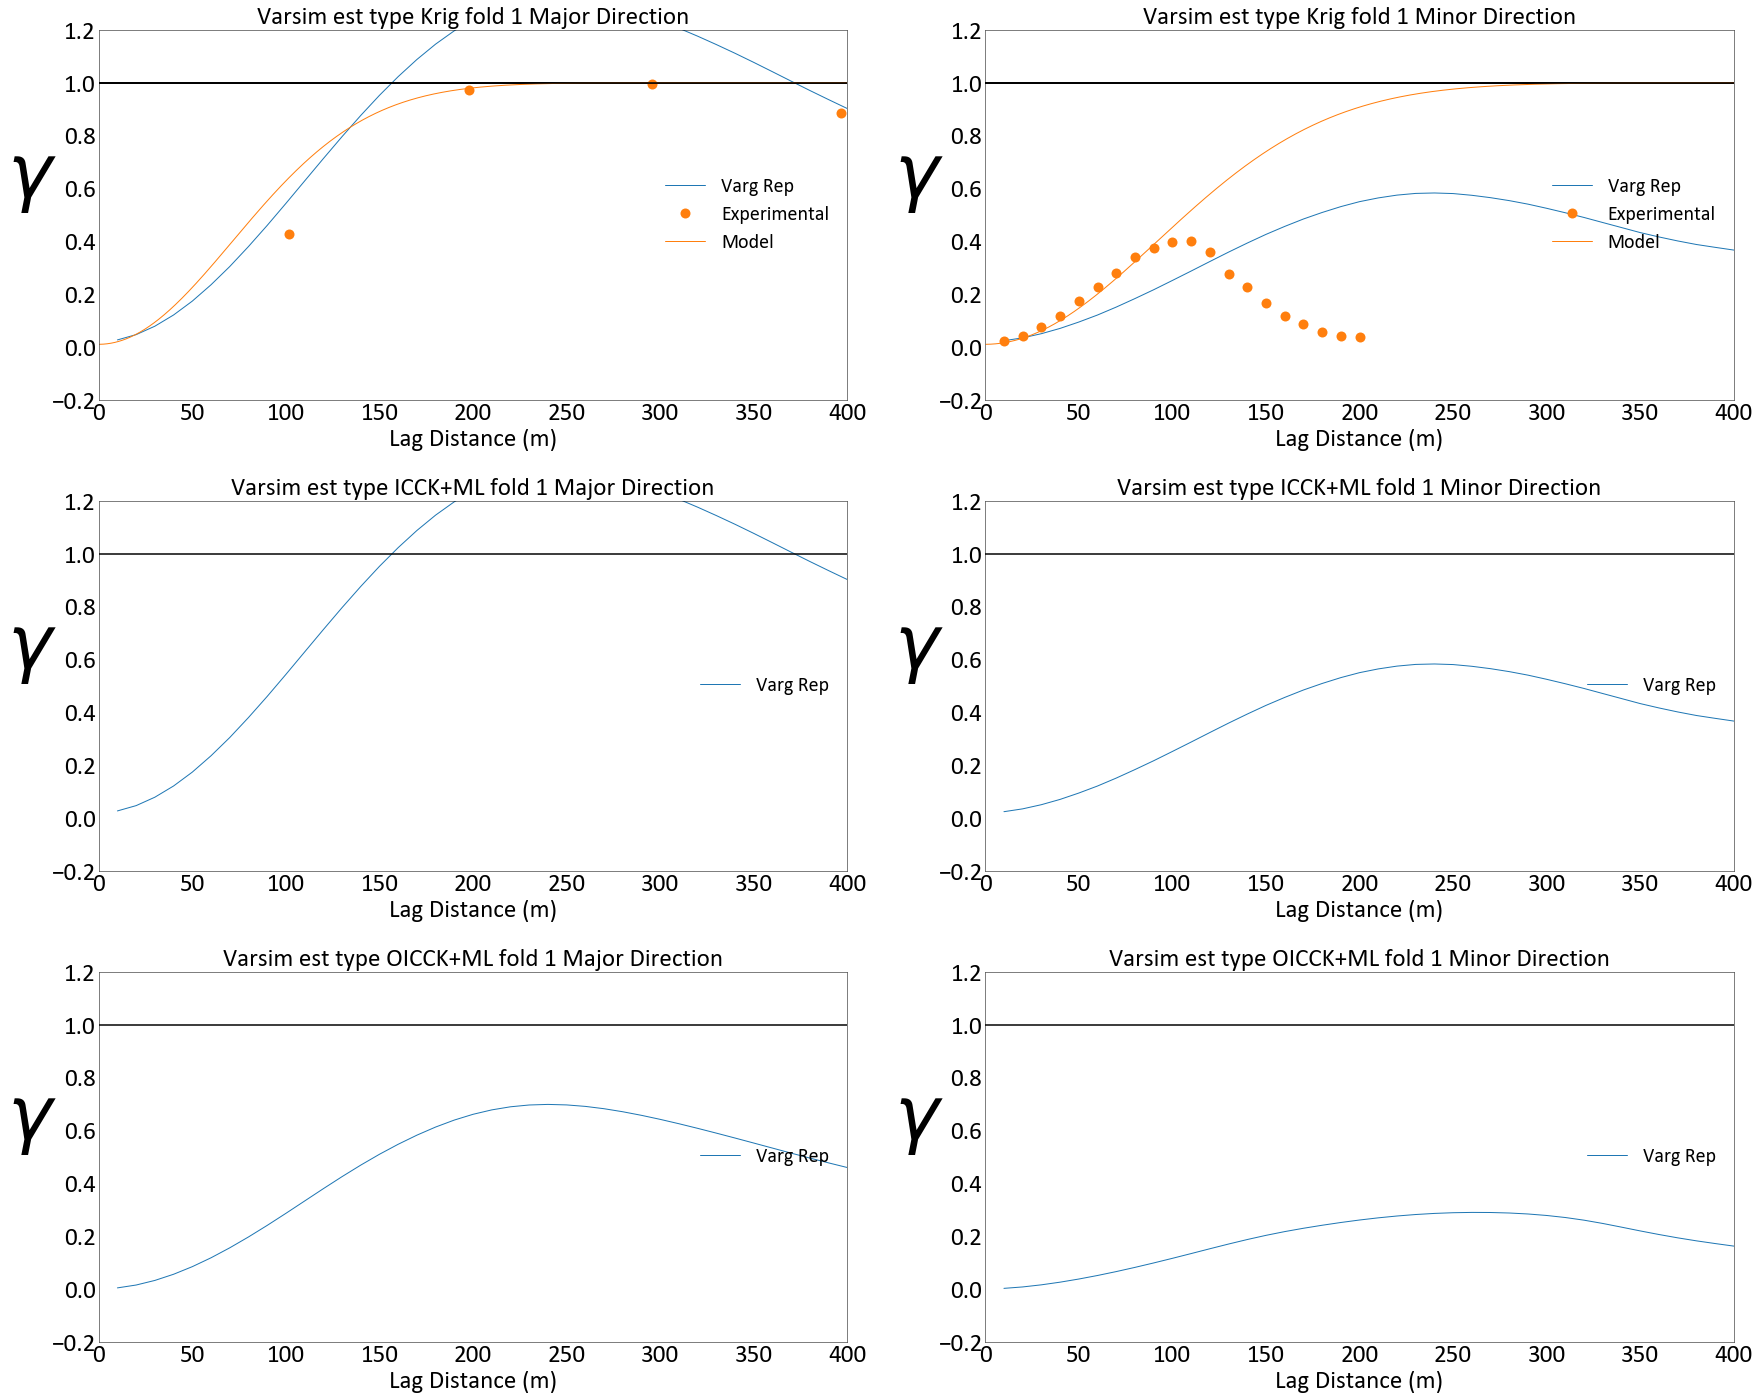

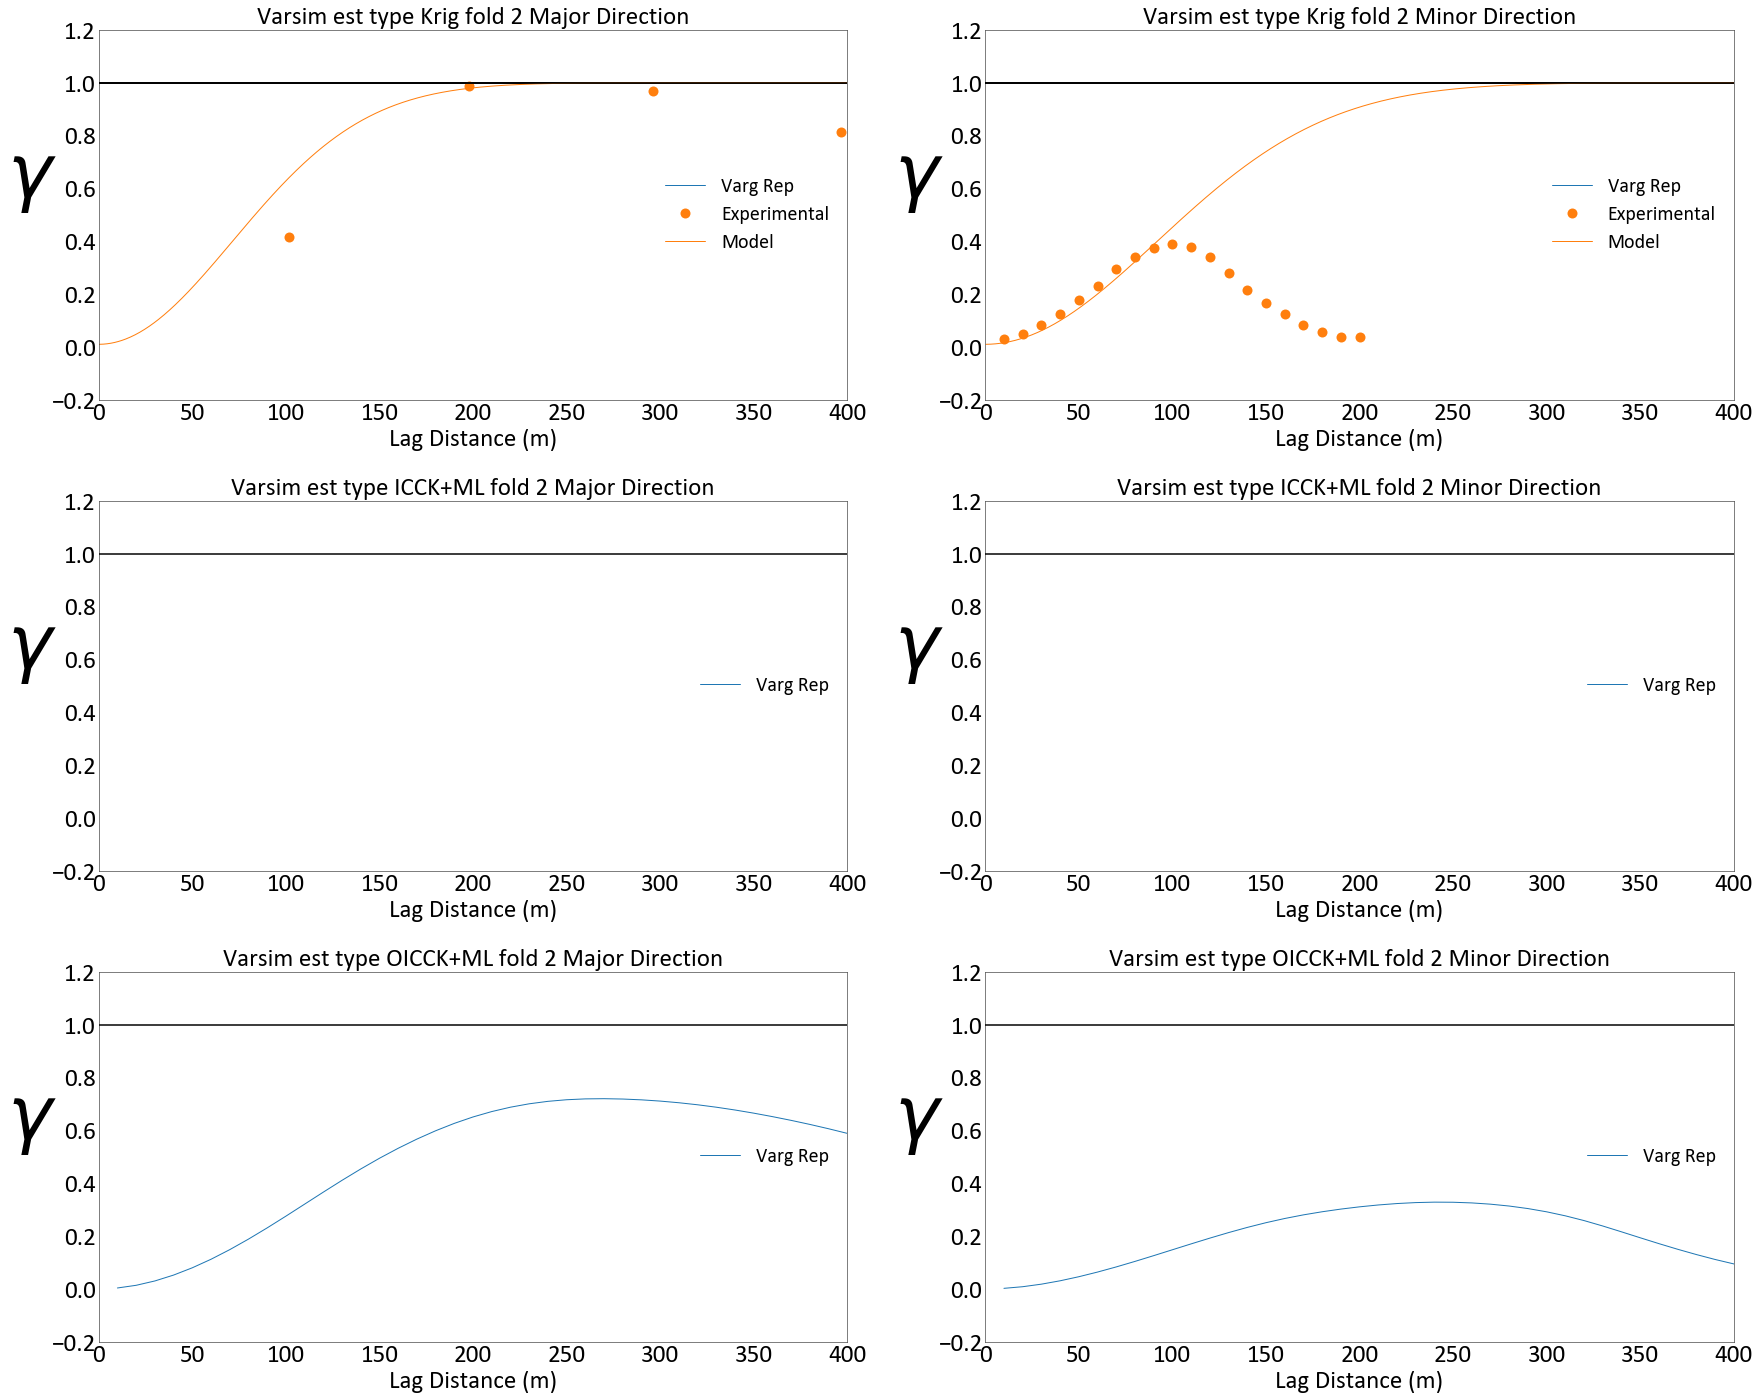

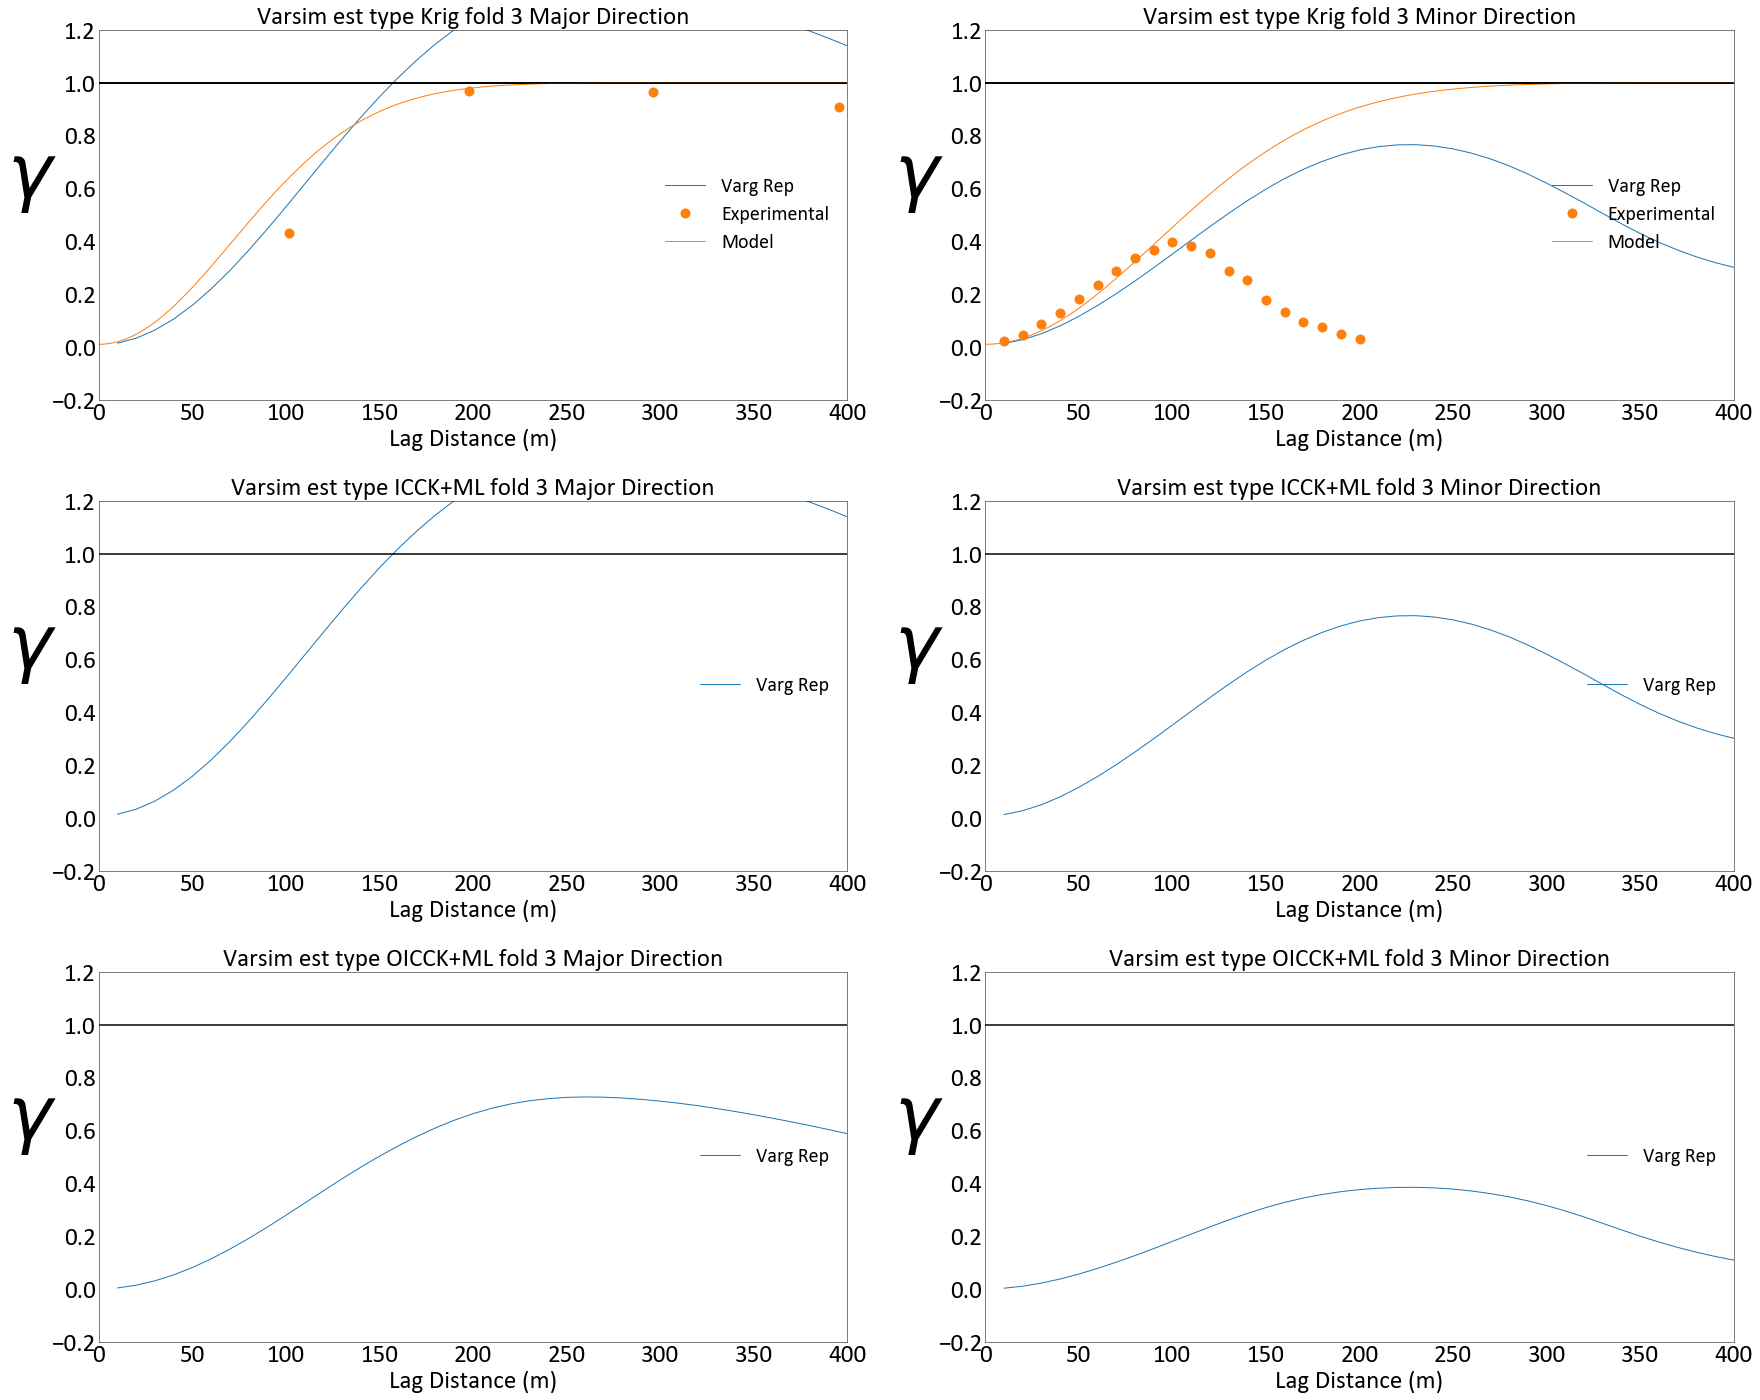

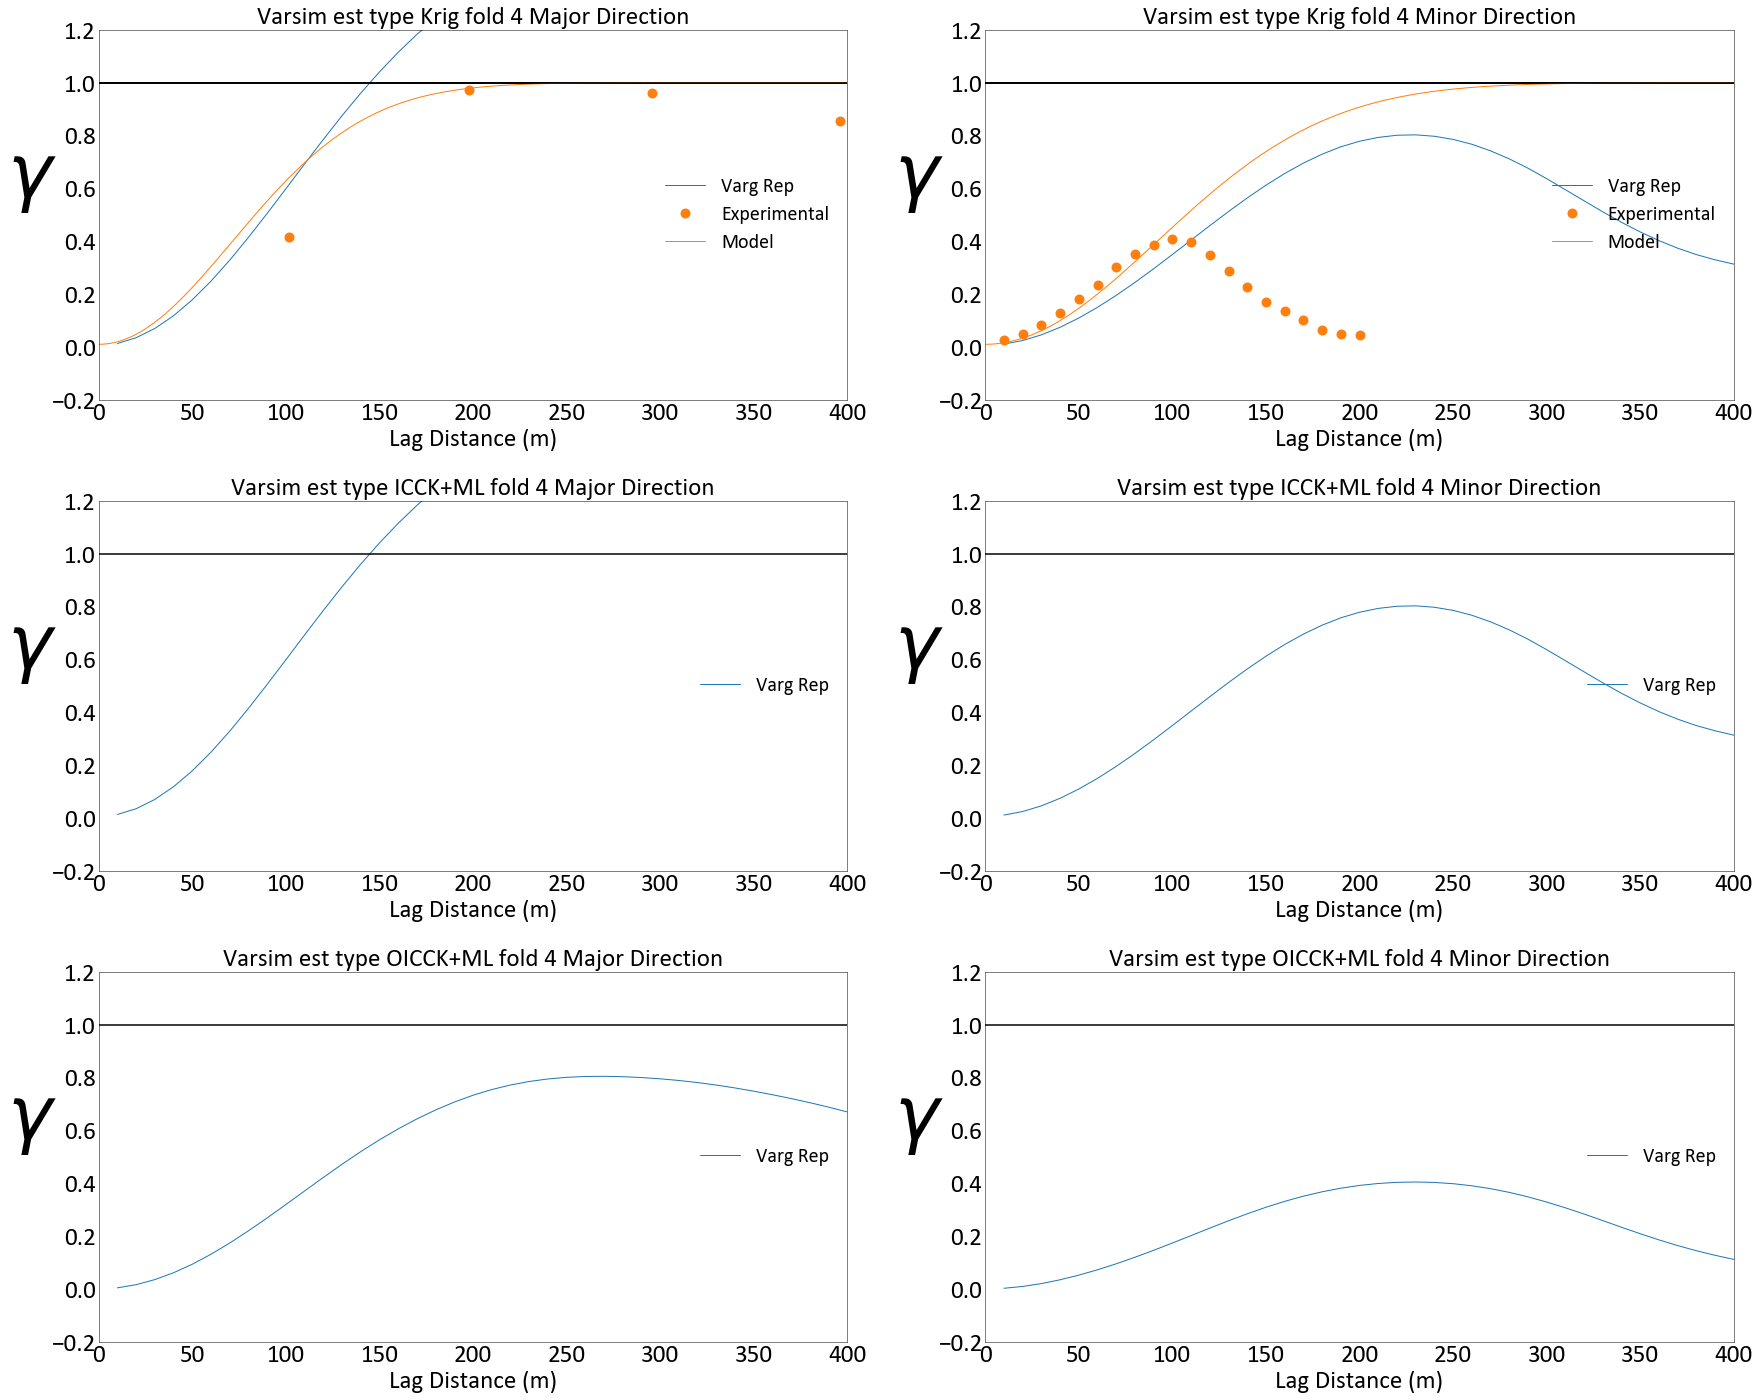

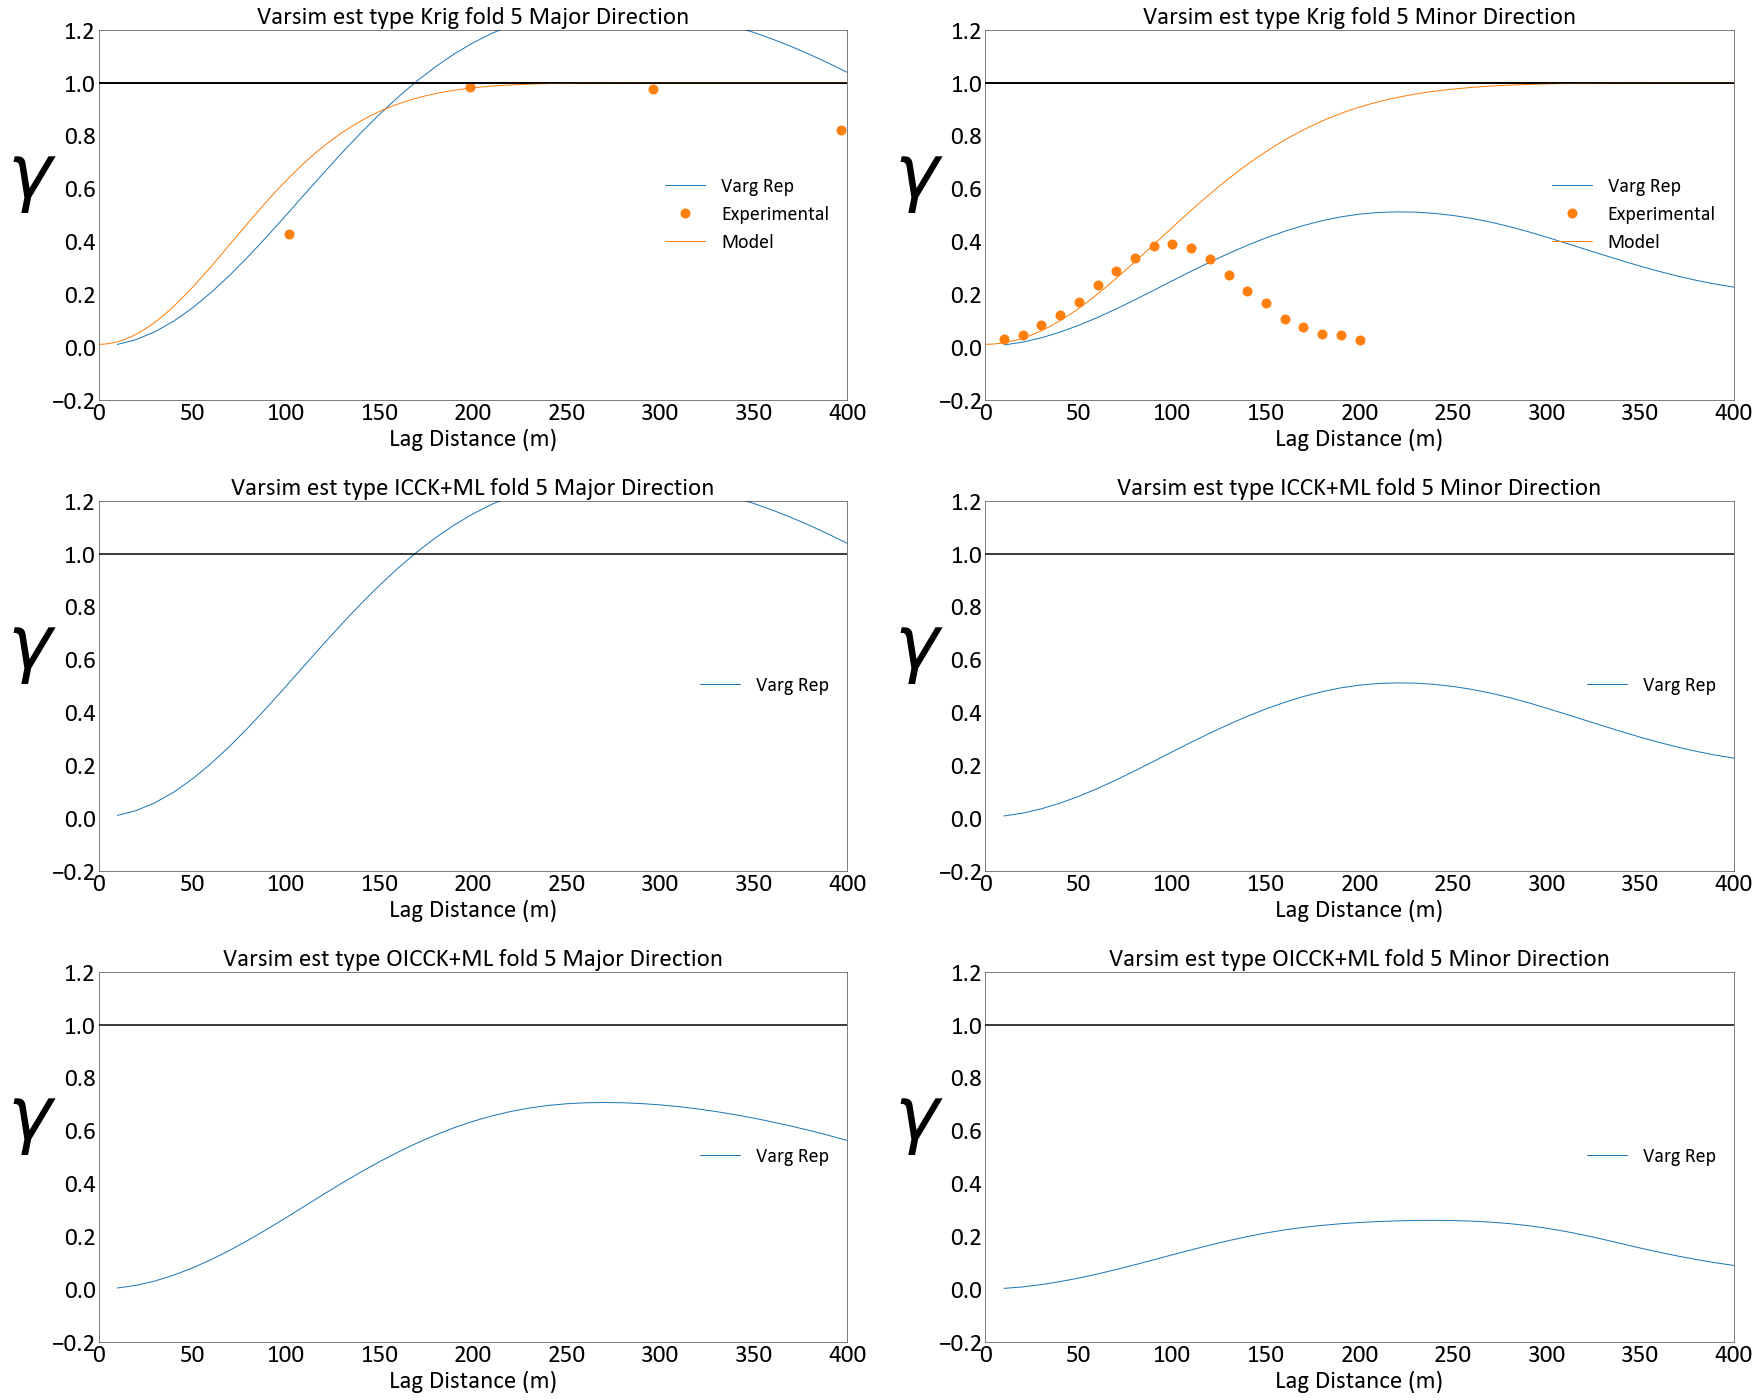

In [82]:
gs.set_style('pt25')
ylim = (-.2,1.2)
for fold in range(1,6):
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    f, axes = plt.subplots(3, 2, figsize=(25, 20))
    for p_type in list(['Krig','ICCK+ML','OICCK+ML']):
        if p_type == 'Krig':
            predfile = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
            col = 1
        if p_type == 'OICCK+ML':
            predfile = gs.DataFile('./backtr/backtr_UDDH_OICCK_{}.out'.format(fold),griddef=griddef)
            col = 3
        else:
            predfile = gs.DataFile('./backtr/backtr_UDDH_ICCK_{}.out'.format(fold),griddef=griddef)
            col = 1
            
        varsim.run(varsimparstr.format(datafl = predfile,
                                       p_type = p_type,
                                       fold = fold,
                                       col = col,
                                       griddef = griddef),quiet=True,liveoutput=False)
        varsimfl =  gs.DataFile('./vargs/varsim_reals_{}_{}.out'.format(p_type,fold))
    

        if p_type == 'Krig':
            ax = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax =axes[0,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax.legend(loc=7,prop={'size': 20})
            ax.set_xlim(0, 400)
            
            ax2 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax =axes[0,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax2.legend(loc=7,prop={'size': 20})
            ax2.set_xlim(0, 400)
            
#             ax3 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax =axes[0,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
#             ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
#             ax3.legend(loc=7,prop={'size': 20})
#             ax3.set_xlim(0, 400)
            
        if p_type == 'ICCK+ML':
            ax4 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[1,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax4.legend(loc=7,prop={'size': 20})
            ax4.set_xlim(0, 400)
            ax5 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[1,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax5.legend(loc=7,prop={'size': 20})
            ax5.set_xlim(0, 400)
#             ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
#             #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
#             ax6.legend(loc=7,prop={'size': 20})
#             ax6.set_xlim(0, 400)

        if p_type == 'OICCK+ML':
            ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[2,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax6.legend(loc=7,prop={'size': 20})
            ax6.set_xlim(0, 400)
            ax7 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[2,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax7.legend(loc=7,prop={'size': 20})
            ax7.set_xlim(0, 400)
#             ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
#             #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
#             #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
#             ax6.legend(loc=7,prop={'size': 20})
#             ax6.set_xlim(0, 400)


    plt.tight_layout()    
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/varg_rep_ERBFN_{}_{}.png'.format(plt_extent,fold))
    plt.show()


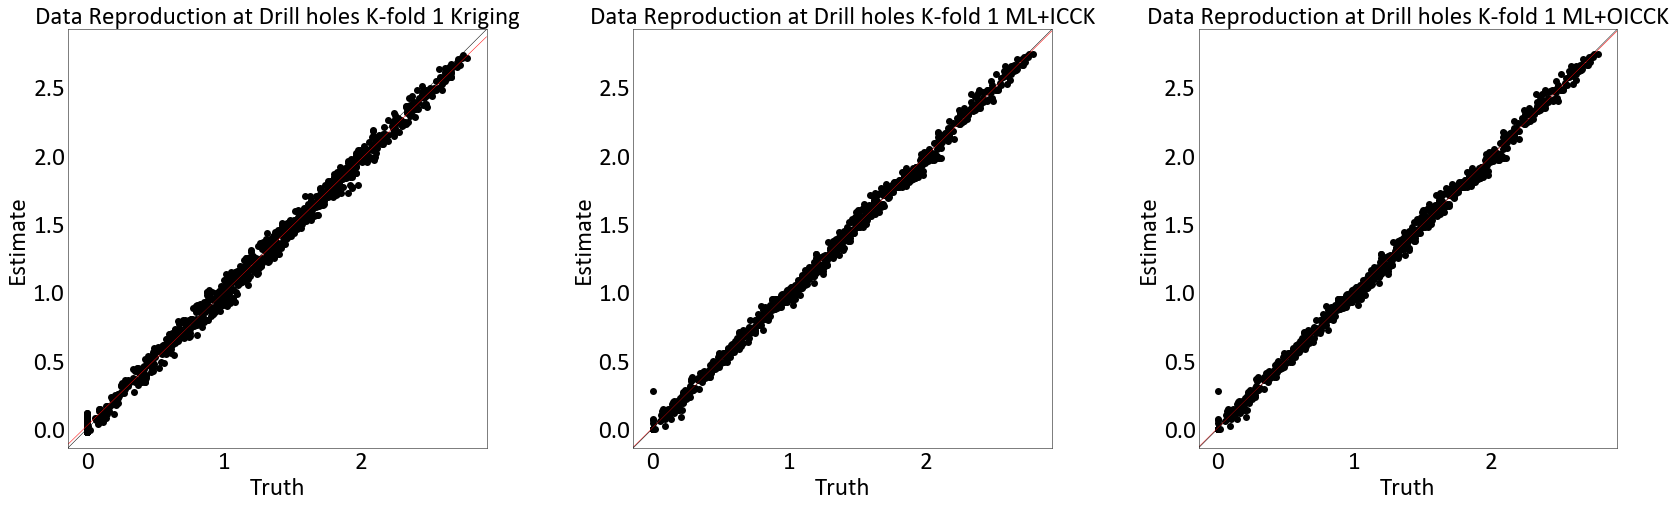

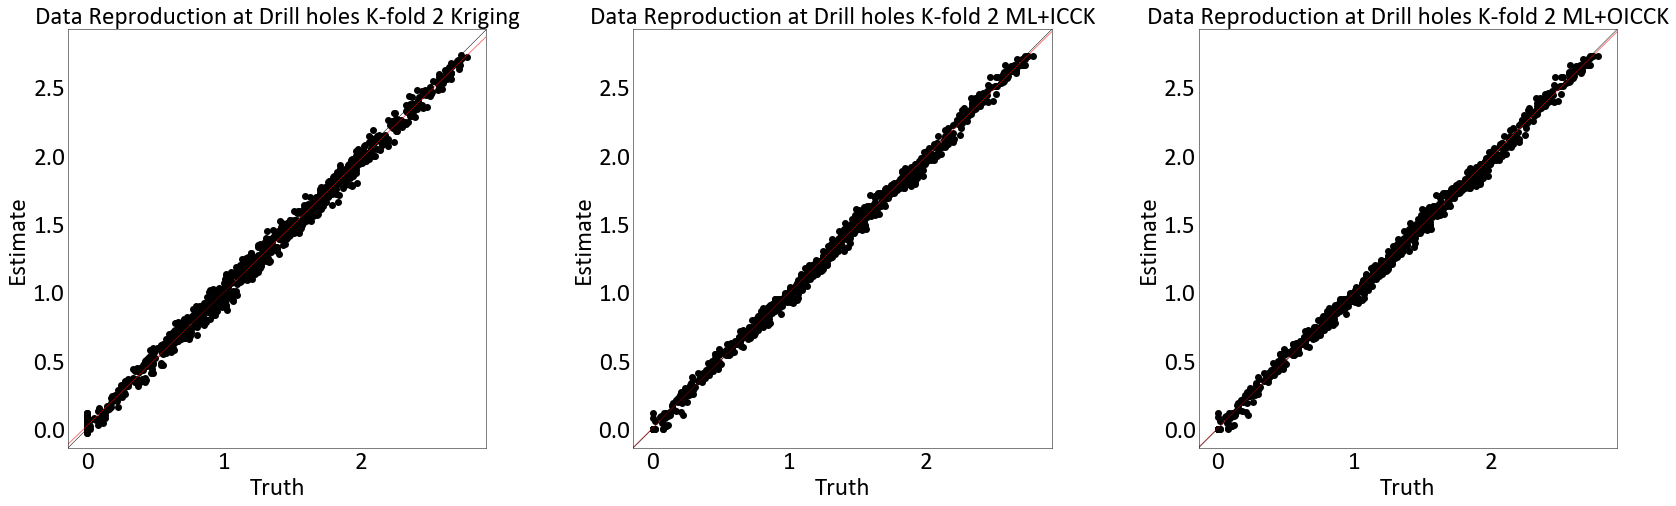

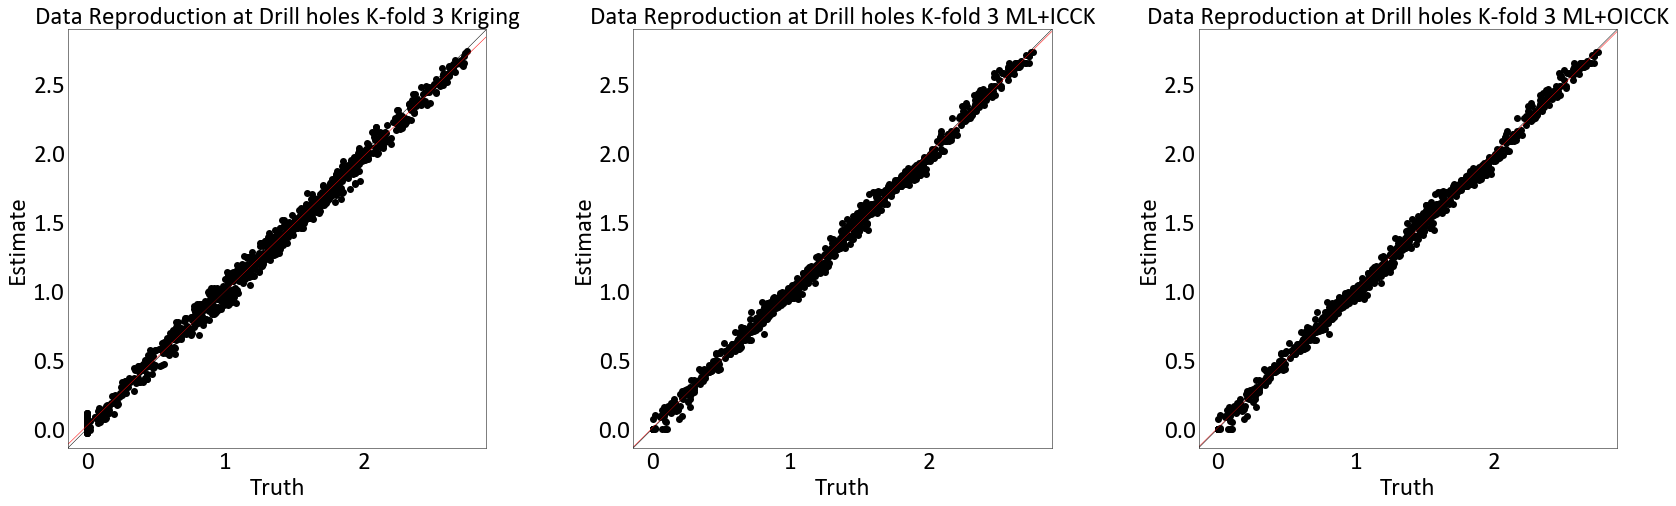

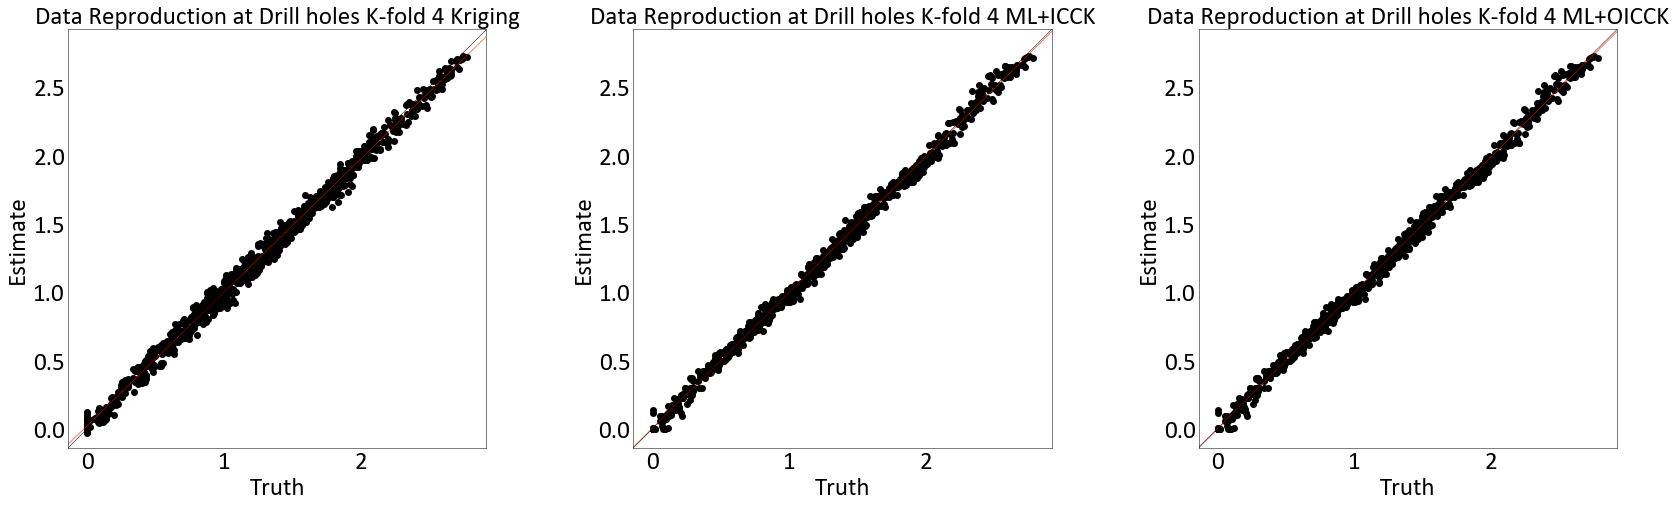

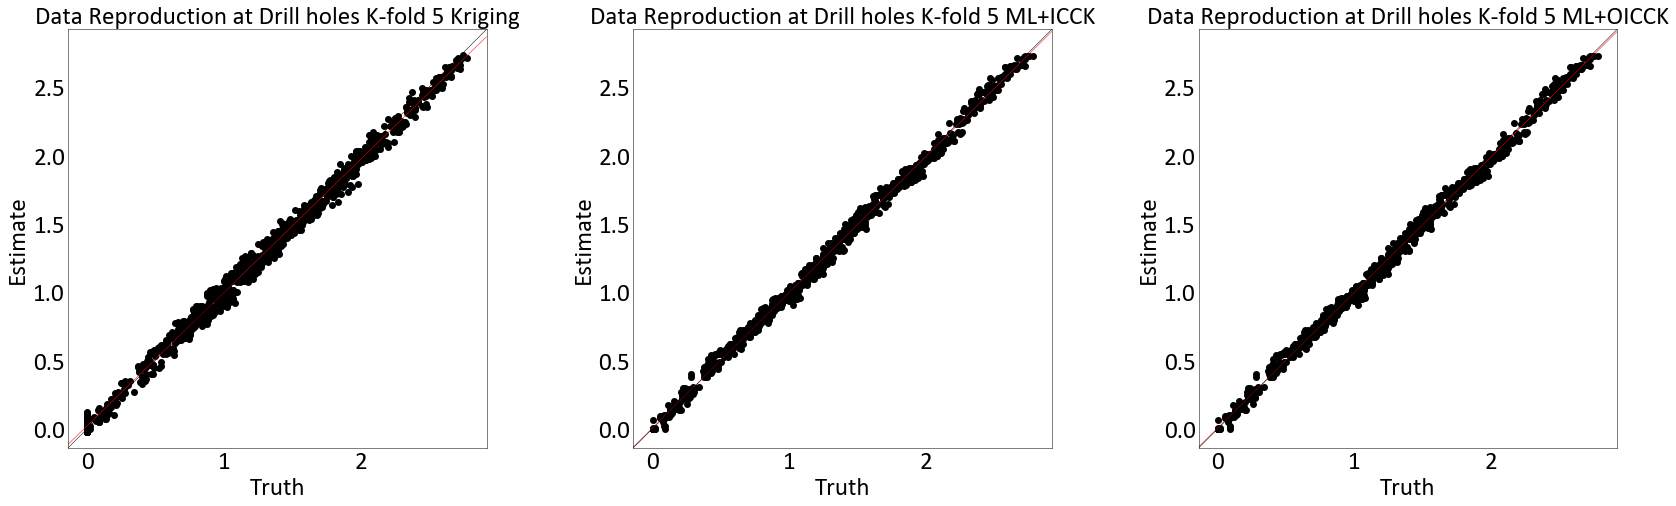

In [8]:
gs.set_style('pt25')
for fold in range (1,6):
    f, axes = plt.subplots(1, 3, figsize=(24, 8))
    Estimation_Data = gs.DataFile('./data/data_train_{}.dat'.format(fold),griddef=griddef)
    plt_data_ml = gs.DataFile('./backtr/backtr_ICCK_{}.out'.format(fold),griddef=griddef)
    plt_data_ml_icck = gs.DataFile('./backtr/backtr_OICCK_{}.out'.format(fold),griddef=griddef)
    plt_data_krig = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    idx,ingrid = griddef.coord_to_index1d(x=Estimation_Data.data['X'],y=Estimation_Data.data['Y'],z=Estimation_Data.data['Z'])
    realz_ml = plt_data_ml['Back Transform'][idx]
    realz_krig = plt_data_krig['Estimate'][idx]
    realz_ml_icck = plt_data_ml_icck['Back Transform'][idx]
    gs.scatxval(Estimation_Data.data['value'],realz_ml.values,xlabel='Truth', ylabel='Estimate',
                title = 'Data Reproduction at Drill holes K-fold {} ML+ICCK'.format(fold),dens=False,ax =axes[1],stat_blk=False )
    
    gs.scatxval(Estimation_Data.data['value'],realz_krig.values,xlabel='Truth', ylabel='Estimate',
                title = 'Data Reproduction at Drill holes K-fold {} Kriging'.format(fold),dens=False,ax =axes[0],stat_blk=False )
    gs.scatxval(Estimation_Data.data['value'],realz_ml_icck.values,xlabel='Truth', ylabel='Estimate',
                title = 'Data Reproduction at Drill holes K-fold {} ML+OICCK'.format(fold),dens=False,ax =axes[2],stat_blk=False)
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    axes[2].set_aspect('equal', 'box')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Drill_Hole_Reproduction_{}_{}.png'.format(plt_extent,fold),vlim=vlim)